# Air Quality Analysis- Esteban

## 1. Dataset Extraction

For the following analysis, we will use 6 cities around north America and central America, those are:

 * Costa Rica
 * Surrey, Canada
 * Anaheim, US
 * Reseda, US
 * Seattle, US
 * Boston, US

### Costa Rica

Because Costa Rica is the focus of our study, we'll start with this data set extraction. First, we import libraries and understand how OpenQA works. OpenQA has 2 primary methods for extraction: py-openaq and an HTML extraction with requests directly. For this implementation, we'll use a more streamlined approach with HTMl extraction. Both methods have a 1000 data limit per page so that doesn't chage it's efficiency.

In [ ]:

import requests
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as matdates

Now, the APi works in the following format. First, an accoutn is created and in settings, an API key should be available. We will provide an API key for example sake, but it will be removed in 7 days.

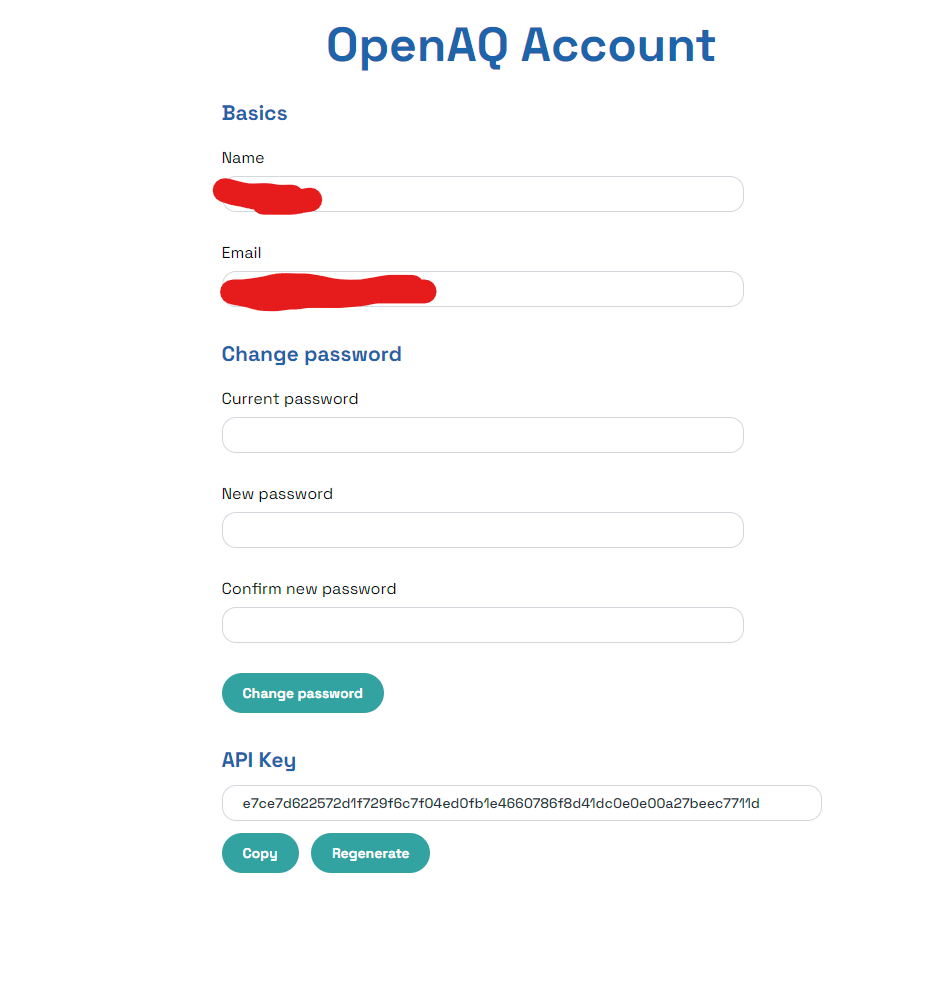

Now, we will use the following base URL: https://api.openaq.org/v2 based in the OPENAQ documentation. We'll add to it to extract the data the following format:{base_url}/measurements?country={country}&parameter={parameter}&date_from={date_start}&date_to={date_end}&limit={limit}&page={page}. Now, the header needs to be the API key. The following code starts the data extraction.

In [ ]:
# API key
api_key = "e7ce7d622572d1f729f6c7f04ed0fb1e4660786f8d41dc0e0e00a27beec7711d"

# Base URL for the OpenAQ API
base_url = "https://api.openaq.org/v2"

# Parameters for the request based on https://docs.openaq.org/docs
country = "CR"
parameter = "pm25" ## Only available data
date_start = "2014-01-01"
date_end = datetime.now().strftime("%Y-%m-%d") ##Get Current date
limit = 1000  # Maximum allowed by the API
page = 1

# List to store all results extracted
all_results = []
# Code for requests based on https://docs.openaq.org/docs and https://docs.python-requests.org/en/latest/index.html
while True:
    # Make the URL based on city to request
    url = f"{base_url}/measurements?country={country}&parameter={parameter}&date_from={date_start}&date_to={date_end}&limit={limit}&page={page}"

    # Use API in headers
    header = {  "X-API-Key": api_key  }
    response = requests.get(url, headers=header)
    if response.status_code == 200:
        data = response.json()
        results = data['results']
        if not results:
            break
        all_results.extend(results)
        page += 1
    else:
        break

# Convert results to pandas DataFrame
df = pd.DataFrame(all_results)
print(df.head(10))
print(f"\nTotal measurements gotten: {len(df)}")

   locationId                      location parameter  value  \
0        7077  US Diplomatic Post: San Jose      pm25 -999.0   
1        7077  US Diplomatic Post: San Jose      pm25 -999.0   
2        7077  US Diplomatic Post: San Jose      pm25 -999.0   
3        7077  US Diplomatic Post: San Jose      pm25 -999.0   
4        7077  US Diplomatic Post: San Jose      pm25 -999.0   
5        7077  US Diplomatic Post: San Jose      pm25 -999.0   
6        7077  US Diplomatic Post: San Jose      pm25 -999.0   
7        7077  US Diplomatic Post: San Jose      pm25 -999.0   
8        7077  US Diplomatic Post: San Jose      pm25 -999.0   
9        7077  US Diplomatic Post: San Jose      pm25 -999.0   

                                                date   unit  \
0  {'utc': '2024-09-25T00:00:00+00:00', 'local': ...  µg/m³   
1  {'utc': '2024-09-24T23:00:00+00:00', 'local': ...  µg/m³   
2  {'utc': '2024-09-24T22:00:00+00:00', 'local': ...  µg/m³   
3  {'utc': '2024-09-24T21:00:00+00:00', 'lo

Now, we begin with a little cleaning. For our analysis, we know the sensor is always in the same spot, which means coordinates, location, country and city are not of use. Then, the sensor type and isMobile columns also are constants that don't add anything to our analysis. The date needs to be converted into a useful, processable value with datetime library. We then proceed with this cleaning.

In [ ]:
# Extract 'utc' from 'date' column, idea gotten from https://stackoverflow.com/questions/55385497/how-can-i-convert-my-datetime-column-in-pandas-all-to-the-same-timezone
df['date'] = df['date'].apply(lambda x: x['utc'])

# Assign Column names
columns = ['date','value', 'unit']
df = df[columns]

# Print the total number of rows
print(f"\nTotal measurements gotten: {len(df)}")


# Remove Duplicates
df.drop_duplicates(inplace=True)


# First, ensure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

print(df.head(10))


Total measurements gotten: 36558
                       date  value   unit
0 2024-09-25 00:00:00+00:00 -999.0  µg/m³
1 2024-09-24 23:00:00+00:00 -999.0  µg/m³
2 2024-09-24 22:00:00+00:00 -999.0  µg/m³
3 2024-09-24 21:00:00+00:00 -999.0  µg/m³
4 2024-09-24 20:00:00+00:00 -999.0  µg/m³
5 2024-09-24 19:00:00+00:00 -999.0  µg/m³
6 2024-09-24 18:00:00+00:00 -999.0  µg/m³
7 2024-09-24 17:00:00+00:00 -999.0  µg/m³
8 2024-09-24 16:00:00+00:00 -999.0  µg/m³
9 2024-09-24 15:00:00+00:00 -999.0  µg/m³


Now, as we can see, the top values of the dataframe have an impossible physical value of -999, which indicates the sensor was either removed or it's faulty. This can tie in nicely to our missing value cleaning, as we can tackle them both at once.

First, this is an hourly measurement. Therefore, we need to make sure all dates are filled to avoid data inconsistencies. We'll fill in a NAN for value for now, which will be cleaned up later.


In [ ]:
# Record the original number of rows and create a set of original dates for comparison at the end
original_row_count = len(df)
original_dates = set(df['date'])

# Sort the DataFrame by descending dat
df = df.sort_values('date', ascending=False)

# Create a complete date range with hourly frequency
date_range = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='H')

Now that we have all dates the DF should have, we can use it to fill in the original DF.

In [ ]:
 # FIll in missing units if present
df['unit'] = df['unit'].fillna('µg/m³')
 # Create a new DataFrame with the complete date range
df_complete_dates = pd.DataFrame({'date': date_range})

# Merge the original DataFrame with the complete date range using Pandas merge function
df_merged = pd.merge(df_complete_dates, df, on='date', how='left')
# Fill the unit column with the most common value, which should be µg/m³, idea from https://stackoverflow.com/questions/62011392/how-to-merge-or-join-a-stacked-dataframe-in-pandas
df_merged['unit'] = df_merged['unit'].fillna(df['unit'].mode()[0])

# Sort the final DataFrame by date in descending order
df_merged = df_merged.sort_values('date', ascending=False)

# Reset the index with new values
df_merged = df_merged.reset_index(drop=True)

# Identify added rows with a mask to create an added rows DF
added_rows_mask = ~df_merged['date'].isin(original_dates)
added_rows = df_merged[added_rows_mask]

# Calculate and print the number of added row
print(f"\nNumber of rows added: {len(added_rows)}")
# Overwrite the original DF
df = df_merged.copy()
# Print new total measurements
print(f"\nTotal measurements gotten: {len(df)}")


Number of rows added: 6481

Total measurements gotten: 43039


As can be seen, there where 6481 missing hours, or about 270 days in 5 years of missing data.

Now, as we saw before, we can now proceed to remove the negative and missing values in the value column.

We chose to clean the DF in the following ways:

1. First, an air quality sensor typically doesn't deviate as much when it comes to hourly measurements and usually follows a pattern when it comes to daily measurements for the same hour.

2. Because of point 1, we chose to fill in negative and missing values by looking at 4 values: the value of the next hour, the value of the previous hour, the value of the following day amd the value of the previous day at the same time.

3. Now, this way doesn't work if theres a large number of incorrect values for several days straight, because it would fill in with another incorrect value. Therefore, we check that at least 3 of thoose values are non NAN and non negative. If they are, fill the value with the mean.

First, we implement the function to find relative values.

In [ ]:
# Function to get relative values
def get_relative_values(df, index):
    # First we use the iloc function to find the date for the value in question.
    date = df.iloc[index]['date']
    # We then use pandas to extract the values from the relative dates specified above.
    one_hour_ahead = df[df['date'] == date + pd.Timedelta(hours=1)]['value'].values
    one_hour_behind = df[df['date'] == date - pd.Timedelta(hours=1)]['value'].values
    day_before = df[df['date'] == date - pd.Timedelta(days=1)]['value'].values
    day_after = df[df['date'] == date + pd.Timedelta(days=1)]['value'].values

    return [one_hour_ahead, one_hour_behind, day_before, day_after]

Now, we implement a function to clean those values base don the relative values, in the way specified above. Fill a value with the mean if at least 3/4 relative values aren't invalid.

In [ ]:
# Function to clean value
def clean_value(row, df, index):
    value = row['value']
    # Check if value is empty, blank space, or negative
    if pd.isna(value) or (isinstance(value, str) and value.strip() == '') or (isinstance(value, (int, float)) and value < 0):
        # Use the previous function to find the relative values for the 4 relative dates.
        relative_values = get_relative_values(df, index)
        # Now, for these values, check if they aren't invalid themselves, if 3/4 aren't, fill with mean. If not, return a NAN to be removed later.
        valid_values=[v[0] for v in relative_values if len(v) > 0 and not pd.isna(v[0]) and v[0] >= 0]
        if len(valid_values) >= 3:
            return np.mean(valid_values)
        else:
            return np.nan
    return value


Now, we go ahead and apply these functions.

In [ ]:
# Count changes, defined
changes = 0

# Function to apply cleaning and count changes
def apply_clean_and_count(row, df, index):
    global changes
    # Assign fixed value.
    new_value = clean_value(row, df, index)
    # Compare new value to changed one to track changs
    if new_value != row['value']:
        changes += 1
    return new_value

We now call these functions. because it's an itnerative operation, function division was used.

In [ ]:
# Apply the cleaning function and count changes, using a lambda function for more efficient declaration
df['value'] = df.apply(lambda row: apply_clean_and_count(row, df, df.index.get_loc(row.name)), axis=1)

# Count rows removed
rows_before = len(df)
df = df.dropna(subset=['value'])
rows_after = len(df)
rows_removed = rows_before - rows_after

# Reset the index
df = df.reset_index(drop=True)

# Print the summary of changes
print(f"Number of values changed: {changes}")
print(f"Number of rows removed: {rows_removed}")
print(f"Total changes made: {changes + rows_removed}")
print(df.head(10))
print(df.tail(10))
# Print new total measurements
print(f"\nTotal measurements remaining: {len(df)}")

Number of values changed: 19544
Number of rows removed: 17945
Total changes made: 37489
                       date  value   unit
0 2023-09-13 23:00:00+00:00    9.0  µg/m³
1 2023-09-13 22:00:00+00:00    9.0  µg/m³
2 2023-09-13 21:00:00+00:00   17.0  µg/m³
3 2023-09-13 20:00:00+00:00   13.0  µg/m³
4 2023-09-13 19:00:00+00:00   10.0  µg/m³
5 2023-09-13 18:00:00+00:00    9.0  µg/m³
6 2023-09-13 17:00:00+00:00    6.0  µg/m³
7 2023-09-13 16:00:00+00:00   17.0  µg/m³
8 2023-09-13 15:00:00+00:00   13.0  µg/m³
9 2023-09-13 14:00:00+00:00    8.0  µg/m³
                           date  value   unit
25084 2019-10-29 03:00:00+00:00   16.0  µg/m³
25085 2019-10-29 02:00:00+00:00    5.0  µg/m³
25086 2019-10-29 01:00:00+00:00   16.0  µg/m³
25087 2019-10-29 00:00:00+00:00   17.0  µg/m³
25088 2019-10-28 23:00:00+00:00   10.0  µg/m³
25089 2019-10-28 22:00:00+00:00   11.0  µg/m³
25090 2019-10-28 21:00:00+00:00   10.0  µg/m³
25091 2019-10-28 20:00:00+00:00   16.0  µg/m³
25092 2019-10-28 19:00:00+00:00    8

As can be seen, we no longer have the negative numbers at the start, which means the sensor stopped working or was removed on september 13th, 2023. Now, lets graph the dataframe and see how it looks.

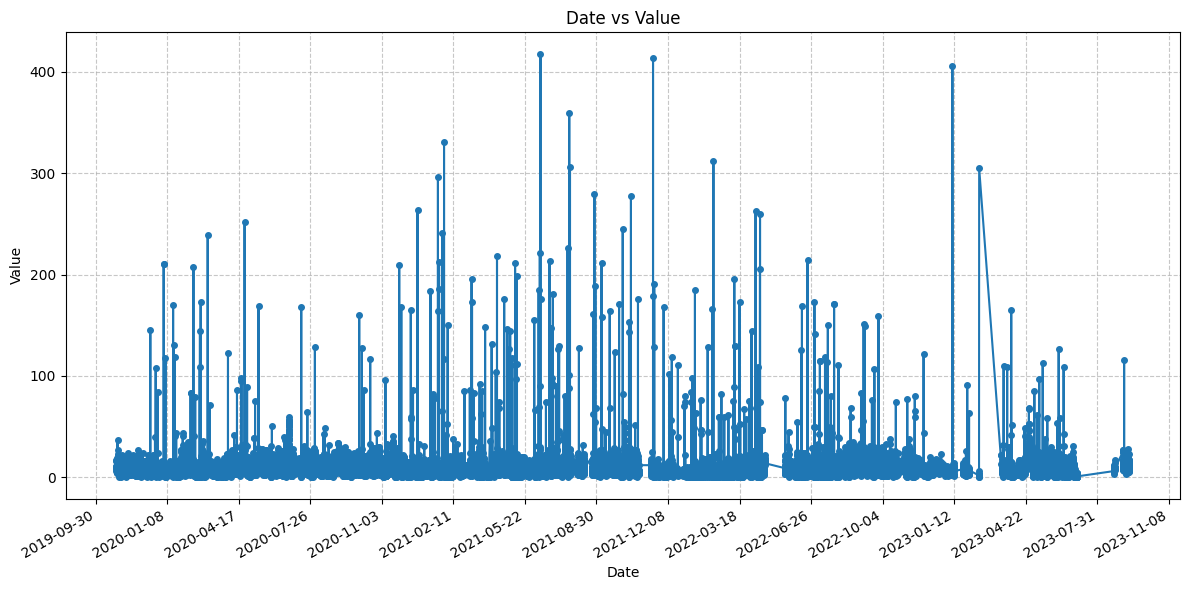

In [ ]:
# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['value'], linestyle='-', marker='o', markersize=4)

# Customize the plot
plt.title('Date vs Value')
plt.xlabel('Date')
plt.ylabel('Value')

# Format the x-axis to show dates in a way that can be seen
plt.gca().xaxis.set_major_formatter(matdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(matdates.DayLocator(interval=100))  # Show tick every 100 days
plt.gcf().autofmt_xdate()  # Rotate and align the tick labels

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

As can be seen, there are a lot of outliers that go beyond 200. Therefore, we use the 3 standard deviation rule to clean the dataset.

In [ ]:
# Count the number of rows before outlier removal
rows_before = len(df)

# Calculate mean and standard deviation for the entire dataset
overall_mean = df['value'].mean()
overall_std = df['value'].std()

# Function to remove outliers based on 3 standard deviations of the entire dataset
def remove_outliers(group):
    return group[(group['value'] >= overall_mean - 3*overall_std) &
                 (group['value'] <= overall_mean + 3*overall_std)]

# Apply the outlier removal function to the entire DataFrame
df = remove_outliers(df)

# Sort the DataFrame by date and reset the index
df = df.sort_values('date', ascending=False).reset_index(drop=True)

# Count the number of rows after outlier removal
rows_after = len(df)

# Calculate and print the number of rows removed to keep track
outliers_removed = rows_before - rows_after
print(f"Number of outliers removed: {outliers_removed}")

Number of outliers removed: 226


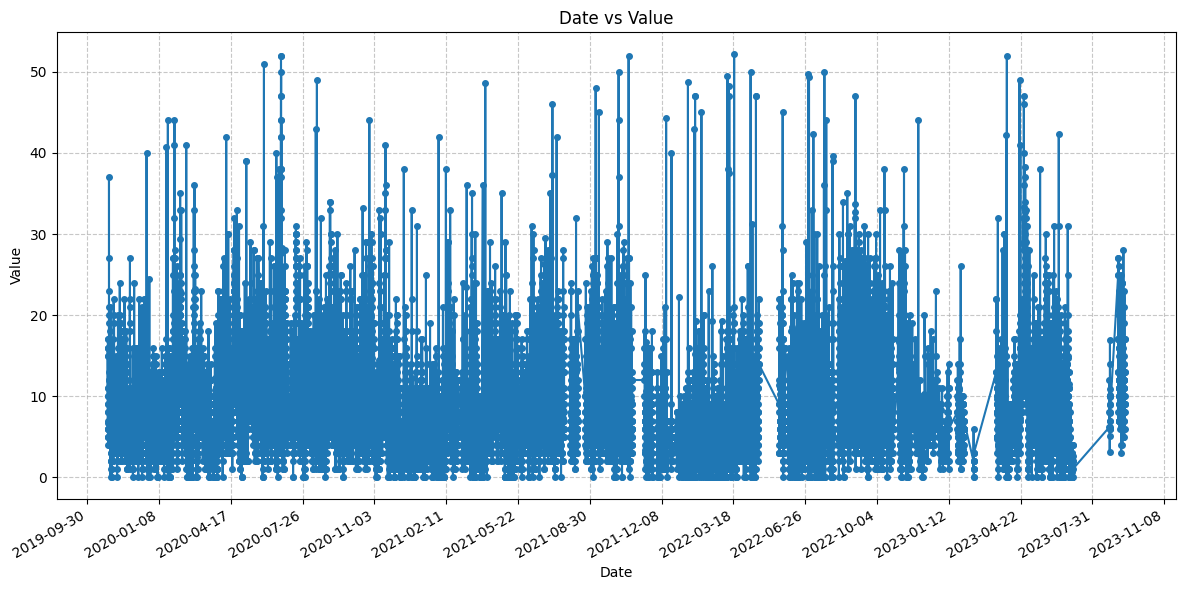

In [ ]:
# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['value'], linestyle='-', marker='o', markersize=4)

# Customize the plot
plt.title('Date vs Value')
plt.xlabel('Date')
plt.ylabel('Value')

# Format the x-axis to show dates in a way that can be seen
plt.gca().xaxis.set_major_formatter(matdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(matdates.DayLocator(interval=100))  # Show tick every 100 days
plt.gcf().autofmt_xdate()  # Rotate and align the tick labels

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

As can be seen, the outliers have reduced substancially. There are still some that go above 200, which will be analyzed later in the EDA. Finally, we transfer the DF to a Costa Rica DF.

In [ ]:
costa_rica_df = df.copy()

#save costa Rica Dataframe to csv
costa_rica_df.to_csv('costa_rica_df.csv', index=False)


### Other Cities

We now proceed with the other cities. Seeing as how they can be transformed the same way, we won't go into as much detail. For this, we will take the data from

In [ ]:
import requests
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as matdates
import time
import os

# Your API key
api_key = "e7ce7d622572d1f729f6c7f04ed0fb1e4660786f8d41dc0e0e00a27beec7711d"

# Base URL for the OpenAQ API
base_url = "https://api.openaq.org/v2"

# List of cities
cities = ["Anaheim", "Reseda", "Surrey East", "Seattle-Beacon Hill", "Boston - Roxbury"]

# Parameters for the request, this is different from the costa rica as we need 5 parameters.
parameters = ["no2", "no", "o3", "co", "pm25"]
date_from = "2019-10-28"
date_to = datetime.now().strftime("%Y-%m-%d")
limit = 1000  # Maximum allowed by the API

def extract_and_save_raw_data():
    # To the original used in costa rica, add a loop to iterate through the 5 cities.
    for i, location in enumerate(cities):
        print(f"\nExtracting data for {location}")

        all_results = []

        for parameter in parameters:
            page = 1
# This section remains the same as the one used in costa rica.
            while True:
                url = f"{base_url}/measurements?location={location}&parameter={parameter}&date_from={date_from}&date_to={date_to}&limit={limit}&page={page}"
                headers = {"X-API-Key": api_key}
                response = requests.get(url, headers=headers)

                if response.status_code == 200:
                    data = response.json()
                    results = data['results']

                    if not results:
                        break
                    all_results.extend(results)
                    page += 1
                else:

                    break
# Save the values in the df, adjust dates and adjust columns, same as CR
        df = pd.DataFrame(all_results)
        df['date'] = df['date'].apply(lambda x: x['utc'])
        columns = ['date', 'parameter', 'value', 'unit']
        df = df[columns]
# Save the csv of the cities
        city_name = location.lower().replace(" ", "_").replace("-", "_")
        csv_filename = f"{city_name}_raw_data.csv"
        df.to_csv(csv_filename, index=False)
        print(f"Saved raw data for {location} to {csv_filename}")
# Wait 10s before moving onto the next city to avoid API issues
        if i < len(cities) - 1:
            print(f"\nWaiting for 10 seconds for API compatibility")
            time.sleep(10)






In [ ]:
# Main function for data loading and processing
def load_and_process_data():
    # Array to save all the DFs
    city_dfs = {}
    city_dfs_NO = {}
    #start location for loop to process all cities
    for location in cities:
        # prepare the name for data extraction from CSV
        city_name = location.lower().replace(" ", "_").replace("-", "_")
        csv_filename = f"{city_name}_raw_data.csv"

        print(f"\nProcessing data for {location}")
        # Read CSV files
        df = pd.read_csv(csv_filename)
        df['date'] = pd.to_datetime(df['date'])
        # Define parameters for column assignment
        parameter_mapping = {
            'no2': 'NO₂ ppm',
            'no': 'NO ppm',
            'o3': 'O₃ ppm',
            'co': 'CO ppm',
            'pm25': 'PM2.5 µg/m³'
        }
        # Assign the parameter column the name of the respective parameter for all 5
        df['parameter'] = df['parameter'].map(parameter_mapping)
        # Create a Pivot Table to place parameters as columns with their values, all side by side.
        # before, this was a list with repeated dates, this centralizes all values into a single date.
        pivot_df = df.pivot(index='date', columns='parameter', values='value')
        pivot_df = pivot_df.reset_index()
        pivot_df = pivot_df.sort_values('date', ascending=False)

        pivot_df = pivot_df.rename(columns={
            'NO₂ ppm': 'NO₂ ppm',
            'NO ppm': 'NO ppm',
            'O₃ ppm': 'O₃ ppm',
            'CO ppm': 'CO ppm',
            'PM2.5 µg/m³': 'PM2.5 µg/m³'
        })
        # Assign the new pivoted DF to the original DF.
        df = pivot_df.copy()

        # Just like in CR, fill all the dates not available
        original_row_count = len(df)
        original_dates = set(df['date'])

         # Just like in CR, fill all the dates not available
        df = df.sort_values('date', ascending=False)

         # Just like in CR,fill all the dates not available by filling the entire date range
        date_range = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='H')
        df_complete = pd.DataFrame({'date': date_range})
        df_merged = pd.merge(df_complete, df, on='date', how='left')
        df_merged = df_merged.sort_values('date', ascending=False)
        df_merged = df_merged.reset_index(drop=True)

        # Use a mask to find out the difference and calculate the number of added rows for dates
        added_rows_mask = ~df_merged['date'].isin(original_dates)
        added_rows = df_merged[added_rows_mask]
        print(f"Number of rows added: {len(added_rows)}")

        df = df_merged.copy()

        print("\nFirst 30 rows of the data:")
        print(df.head(30))

        ## Function to get the NAN percentages for printing by counting NULL in every column
        def calculate_nan_percentage(df):
            total_rows = len(df)
            nan_counts = df.isnull().sum()
            nan_percentages = (nan_counts / total_rows) * 100
            nan_percentages = nan_percentages.round(2)
            nan_percentages_sorted = nan_percentages.sort_values(ascending=False)
            return nan_percentages_sorted

        # Print NANs
        nan_percentages = calculate_nan_percentage(df)
        print("NaN Percentages in each column:")
        print(nan_percentages)

        # Separate NO column because it only has values from 2023 upwards, so it requires special treatment
        df_NO = df[['date', 'NO ppm']].copy()
        df = df.drop('NO ppm', axis=1)

        # Define same relative function used in CR to get values for day after, day before, hour after and hour before.

        def get_relative_values(df, index, column):
            date = df.iloc[index]['date']
            one_hour_ahead = df[df['date'] == date + pd.Timedelta(hours=1)][column].values
            one_hour_behind = df[df['date'] == date - pd.Timedelta(hours=1)][column].values
            day_before = df[df['date'] == date - pd.Timedelta(days=1)][column].values
            day_after = df[df['date'] == date + pd.Timedelta(days=1)][column].values
            return [one_hour_ahead, one_hour_behind, day_before, day_after]

        # Define same clean value function in CR to get clean values based on day after, day before, hour after and hour before.
        # If value is NAN or negative, try to change it with the average between 3/4 values, if they are invalid, fill in NAN
        def clean_value(value, df, index, column):
            if pd.isna(value) or (isinstance(value, str) and value.strip() == '') or (isinstance(value, (int, float)) and value < 0):
                relative_values = get_relative_values(df, index, column)
                valid_values = [v[0] for v in relative_values if len(v) > 0 and not pd.isna(v[0]) and v[0] >= 0]
                return np.mean(valid_values) if len(valid_values) >= 3 else np.nan
            return value

        # Define columns to apply the relative cleaning to
        columns_to_clean = ['NO₂ ppm', 'O₃ ppm', 'CO ppm', 'PM2.5 µg/m³']

        #Apply the cleaning algorithms
        for column in columns_to_clean:
            df[column] = df.apply(lambda row: clean_value(row[column], df, df.index.get_loc(row.name), column), axis=1)

        df = df.dropna()
        df = df.reset_index(drop=True)

        print("Cleaning completed.")

        # Function to remove ourliers based on 3 std from the entire dataset. Same function used in CR, but applied to all columns
        def remove_outliers(df, columns):
            df = df.copy()
            rows_before = len(df)
            total_outliers_removed = 0
          # Use a for loop to apply the outlier trimming to all columns
          # Different from CR which only had 1 column.
            for column in columns:
                column_rows_before = len(df)
                mean = df[column].mean()
                std = df[column].std()
                df = df[(df[column] >= mean - 3*std) & (df[column] <= mean + 3*std)]

                column_rows_after = len(df)
                column_outliers_removed = column_rows_before - column_rows_after
                total_outliers_removed += column_outliers_removed

                print(f"Outliers removed from {column}: {column_outliers_removed}")
          # Figure out how many rows were trimmed
            rows_after = len(df)
            print(f"Total number of outliers removed: {total_outliers_removed}")
            print(f"Rows before: {rows_before}, Rows after: {rows_after}")

            return df

        # Assuming you have your DataFrame 'df' and 'columns_to_clean' list
        df = remove_outliers(df, columns_to_clean)

        # Sort the DataFrame by date in descending order and reset the index
        df = df.sort_values('date', ascending=False).reset_index(drop=True)
        #Save the DFs
        city_dfs[f"{city_name}_df"] = df.copy()
        city_dfs_NO[f"{city_name}_df_NO"] = df_NO.copy()

    return city_dfs, city_dfs_NO


# Function to clean the NO columns

def clean_no_df(df):
    # Take the DF and copy it.
    df = df.copy()

    # Replace white space and empty with NANs. Then, switch it to numeric
    df['NO ppm'] = df['NO ppm'].replace(r'^\s*$', np.nan, regex=True)
    df['NO ppm'] = pd.to_numeric(df['NO ppm'], errors='coerce')

    # Fill in the negative and NAN values with the the next available value or the last available value. Got interpolation idea from https://stackoverflow.com/questions/43772218/fastest-way-to-use-numpy-interp-on-a-2-d-array
    def fill_nan_and_negative(series):
      # Create a boolean mask for NaN missing or negative values
        mask = series.isna() | (series < 0)
        # Find indices of valid values, which are not NaN and not negative
        valid_idx = np.where(~mask)[0]
        # If there are no valid values, return the original series unchanged
        if len(valid_idx) == 0:
            return series
        # np.arange(len(series)) creates an array of indices for all elements
        # valid_idx provides the x-coordinates of known points
        interpolated = np.interp(np.arange(len(series)), valid_idx, series.iloc[valid_idx])
        # Replace NaN and negative values with interpolated values
        series.loc[mask] = interpolated[mask]
        return series

    df['NO ppm'] = fill_nan_and_negative(df['NO ppm'])
    return df
# Merge the column NO back into the original DF
def merge_no_df(main_df, no_df):
    merged_df = main_df.copy()
    merged_df = pd.merge(merged_df, no_df[['date', 'NO ppm']], on='date', how='left')
    cols = merged_df.columns.tolist()
    no2_index = cols.index('NO₂ ppm')
    cols.remove('NO ppm')
    cols.insert(no2_index + 1, 'NO ppm')
    merged_df = merged_df[cols]
    return merged_df

Raw Data

In [ ]:
#Main Function

# Check if raw data files exist
raw_data_exists = all(os.path.exists(f"{city.lower().replace(' ', '_').replace('-', '_')}_raw_data.csv") for city in cities)

if not raw_data_exists:
    print("Raw data files not found. Extracting raw data...")
    extract_and_save_raw_data()
else:
    print("Raw data files found. Skipping extraction.")



Raw data files not found. Extracting raw data...

Extracting data for Anaheim
Saved raw data for Anaheim to anaheim_raw_data.csv

Waiting for 10 seconds for API compatibility

Extracting data for Reseda
Saved raw data for Reseda to reseda_raw_data.csv

Waiting for 10 seconds for API compatibility

Extracting data for Surrey East
Saved raw data for Surrey East to surrey_east_raw_data.csv

Waiting for 10 seconds for API compatibility

Extracting data for Seattle-Beacon Hill
Saved raw data for Seattle-Beacon Hill to seattle_beacon_hill_raw_data.csv

Waiting for 10 seconds for API compatibility

Extracting data for Boston - Roxbury
Saved raw data for Boston - Roxbury to boston___roxbury_raw_data.csv


Data Processing

In [ ]:
print("\nProcessing data...")
## Execute code to load and process the data
city_dfs, city_dfs_NO = load_and_process_data()

# Assign the DataFrames to their respective variables
anaheim_df = city_dfs["anaheim_df"]
anaheim_df_NO = city_dfs_NO["anaheim_df_NO"]

reseda_df = city_dfs["reseda_df"]
reseda_df_NO = city_dfs_NO["reseda_df_NO"]

surrey_df = city_dfs["surrey_east_df"]
surrey_df_NO = city_dfs_NO["surrey_east_df_NO"]

seattle_df = city_dfs["seattle_beacon_hill_df"]
seattle_df_NO = city_dfs_NO["seattle_beacon_hill_df_NO"]

boston_df = city_dfs["boston___roxbury_df"]
boston_df_NO = city_dfs_NO["boston___roxbury_df_NO"]

print("\nAll DataFrames have been created successfully.")

# Clean NO DataFrames
no_dfs = [anaheim_df_NO, reseda_df_NO, surrey_df_NO, seattle_df_NO, boston_df_NO]
city_names = ['Anaheim', 'Reseda', 'Surrey East', 'Seattle-Beacon Hill', 'Boston - Roxbury']

for df, city in zip(no_dfs, city_names):
    df = clean_no_df(df)
    nan_percentage = (df['NO ppm'].isna().sum() / len(df)) * 100
    print(f"\n{city} NO DataFrame:")
    print(f"NaN percentage after cleaning: {nan_percentage:.2f}%")

# Update the original DataFrames with the cleaned versions
anaheim_df_NO = clean_no_df(anaheim_df_NO)
reseda_df_NO = clean_no_df(reseda_df_NO)
surrey_df_NO = clean_no_df(surrey_df_NO)
seattle_df_NO = clean_no_df(seattle_df_NO)
boston_df_NO = clean_no_df(boston_df_NO)

print("\nAll NO DataFrames have been cleaned and updated.")

# Merge NO DataFrames back into main DataFrames
anaheim_df = merge_no_df(anaheim_df, anaheim_df_NO)
reseda_df = merge_no_df(reseda_df, reseda_df_NO)
surrey_df = merge_no_df(surrey_df, surrey_df_NO)
seattle_df = merge_no_df(seattle_df, seattle_df_NO)
boston_df = merge_no_df(boston_df, boston_df_NO)

print("\nAll DataFrames have been merged successfully.")
print("\nFirst few rows of Anaheim DataFrame:")
print(anaheim_df.head())


Processing data...

Processing data for Anaheim
Number of rows added: 6376

First 30 rows of the data:
                        date  CO ppm  NO ppm  NO₂ ppm  O₃ ppm  PM2.5 µg/m³
0  2024-09-25 00:00:00+00:00     0.4  0.0015   0.0050   0.043          7.6
1  2024-09-24 23:00:00+00:00     0.4  0.0019   0.0054   0.047          8.6
2  2024-09-24 22:00:00+00:00     0.4  0.0025   0.0075   0.049         11.6
3  2024-09-24 21:00:00+00:00     0.4  0.0024   0.0064   0.048         15.9
4  2024-09-24 20:00:00+00:00     0.4  0.0022   0.0061   0.050         19.6
5  2024-09-24 19:00:00+00:00     0.4  0.0023   0.0048   0.042         12.3
6  2024-09-24 18:00:00+00:00     0.4  0.0030   0.0058   0.036         12.1
7  2024-09-24 17:00:00+00:00     0.4  0.0029   0.0057   0.033         16.7
8  2024-09-24 16:00:00+00:00     0.4  0.0025   0.0063   0.028         12.7
9  2024-09-24 15:00:00+00:00     0.4  0.0021   0.0077   0.024         14.7
10 2024-09-24 14:00:00+00:00     0.4  0.0019   0.0083   0.023         1

<ipython-input-16-4c048211e7e1>:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series.loc[mask] = interpolated[mask]


Save the data for later analysis

In [ ]:
seattle_df.to_csv('seattle_df.csv', index=False)
boston_df.to_csv('boston_df.csv', index=False)
surrey_df.to_csv('surrey_df.csv', index=False)
reseda_df.to_csv('reseda_df.csv', index=False)
anaheim_df.to_csv('anaheim_df.csv', index=False)
costa_rica_df.to_csv('costa_rica_df.csv', index=False)

## EDA Analysis

Let's first start by loading the dataset

In [ ]:
import pandas as pd
import numpy as np
costa_rica_df = pd.read_csv('costa_rica_df.csv')
annaheim_df = pd.read_csv('annaheim_df.csv')
boston_df = pd.read_csv('boston_df.csv')
seattle_df = pd.read_csv('seattle_df.csv')
reseda_df = pd.read_csv('reseda_df.csv')
surrey_df = pd.read_csv('surrey_df.csv')

### Univariable

#### PM2.5 µg/m³ box plot

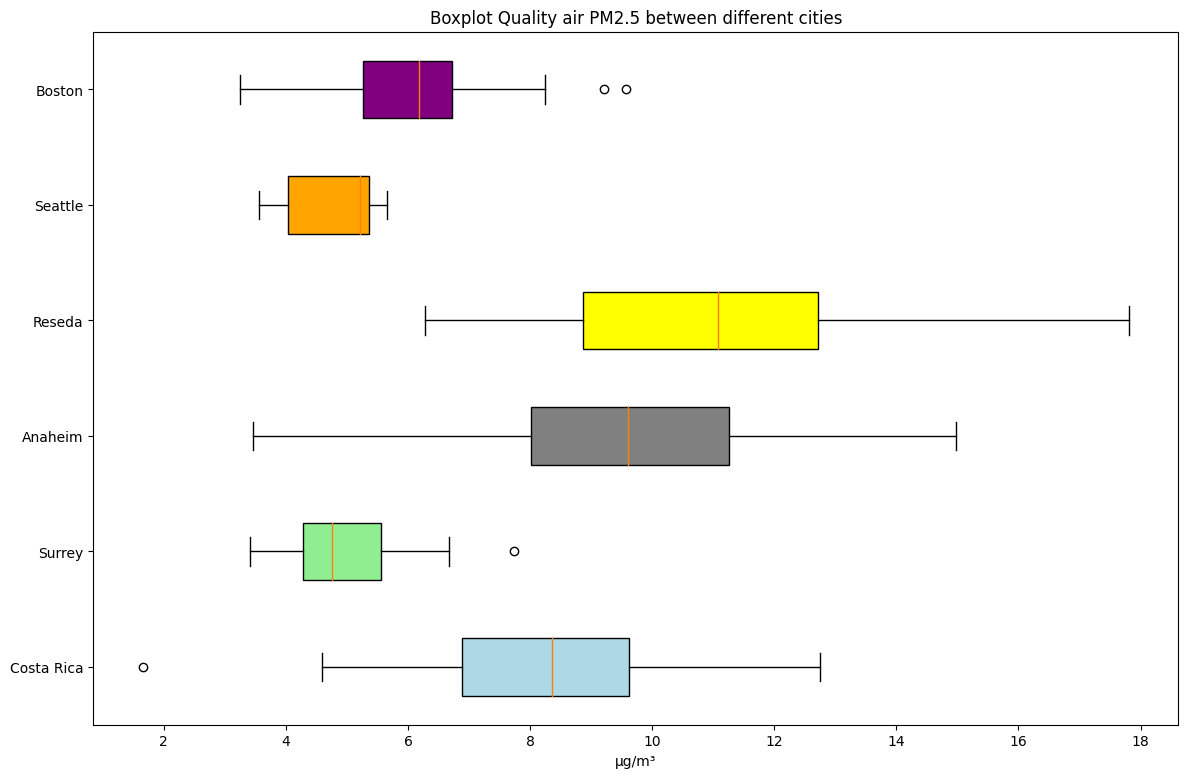

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# Logic to do box plot for selected cities
# Costa Rica data preparation
cr_df_filtered = costa_rica_df.copy() # Copy creation of the df
cr_df_filtered['date'] = pd.to_datetime(cr_df_filtered['date']) # Convert the date column to datetime objects for proper manipulation
cr_df_filtered['value'] = pd.to_numeric(cr_df_filtered['value'], errors='coerce') # Convert the value to numeric type, coercing to handle errors
cr_df_filtered = cr_df_filtered.dropna(subset=['value']) # Drop any rows where 'value' is NaN because cannot be used in numerical calculations
cr_df_filtered.set_index('date', inplace=True) # Set the 'date' column as index of the DataFrame because is required for resampling
cr_monthly_avg = cr_df_filtered['value'].resample('M').mean() # Resample the data to monthly frequency (calc month mean)
cr_monthly_avg = cr_monthly_avg.to_frame() # Convert resulting series from resampling to DataFrame
cr_monthly_avg['Year'] = cr_monthly_avg.index.year # Extract the year and create a new 'Year' column
cr_monthly_avg['Month'] = cr_monthly_avg.index.month # Extract the month and create a new 'Month' column

# Combine the 'Year' and 'Month' columns to create a column in 'YYYY-MM' format
cr_monthly_avg['Year-Month'] = cr_monthly_avg['Year'].astype(str) + '-' + cr_monthly_avg['Month'].astype(str).str.zfill(2)
cr_monthly_avg.rename(columns={'value': 'PM2.5 µg/m³'}, inplace=True)  # Renaming column

# Surrey data preparation
SR_df_filtered = surrey_df.copy() # Df copy
SR_df_filtered['date'] = pd.to_datetime(SR_df_filtered['date']) # Convert the date column to datetime objects for proper manipulation
SR_df_filtered['PM2.5 µg/m³'] = pd.to_numeric(SR_df_filtered['PM2.5 µg/m³'], errors='coerce') # Convert the value to numeric type, coercing to handle errors
SR_df_filtered = SR_df_filtered.dropna(subset=['PM2.5 µg/m³']) # Drop any rows where 'value' is NaN because cannot be used in numerical calculations
SR_df_filtered.set_index('date', inplace=True) # Set the 'date' column as index of the DataFrame because is required for resampling
SR_monthly_avg = SR_df_filtered['PM2.5 µg/m³'].resample('M').mean() # Resample the data to monthly frequency (calc month mean)

# Annaheim data preparation
# Follow the same structure as Surrey plot, comments are the same
anaheim_df_filtered = anaheim_df.copy()
anaheim_df_filtered['date'] = pd.to_datetime(anaheim_df_filtered['date'])
anaheim_df_filtered['PM2.5 µg/m³'] = pd.to_numeric(anaheim_df_filtered['PM2.5 µg/m³'], errors='coerce')
anaheim_df_filtered = anaheim_df_filtered.dropna(subset=['PM2.5 µg/m³'])
anaheim_df_filtered.set_index('date', inplace=True)
anaheim_monthly_avg = anaheim_df_filtered['PM2.5 µg/m³'].resample('M').mean()

# Reseda data preparation
# Follow the same structure as Surrey plot, comments are the same
reseda_df_filtered = reseda_df.copy()
reseda_df_filtered['date'] = pd.to_datetime(reseda_df_filtered['date'])
reseda_df_filtered['PM2.5 µg/m³'] = pd.to_numeric(reseda_df_filtered['PM2.5 µg/m³'], errors='coerce')
reseda_df_filtered = reseda_df_filtered.dropna(subset=['PM2.5 µg/m³'])
reseda_df_filtered.set_index('date', inplace=True)
reseda_monthly_avg = reseda_df_filtered['PM2.5 µg/m³'].resample('M').mean()

# Seattle data preparation
# Follow the same structure as Surrey plot, comments are the same
seattle_df_filtered = seattle_df.copy()
seattle_df_filtered['date'] = pd.to_datetime(seattle_df_filtered['date'])
seattle_df_filtered['PM2.5 µg/m³'] = pd.to_numeric(seattle_df_filtered['PM2.5 µg/m³'], errors='coerce')
seattle_df_filtered = seattle_df_filtered.dropna(subset=['PM2.5 µg/m³'])
seattle_df_filtered.set_index('date', inplace=True)
seattle_monthly_avg = seattle_df_filtered['PM2.5 µg/m³'].resample('M').mean()

# Boston data preparation
# Follow the same structure as Surrey plot, comments are the same
boston_df_filtered = boston_df.copy()
boston_df_filtered['date'] = pd.to_datetime(boston_df_filtered['date'])
boston_df_filtered['PM2.5 µg/m³'] = pd.to_numeric(boston_df_filtered['PM2.5 µg/m³'], errors='coerce')
boston_df_filtered = boston_df_filtered.dropna(subset=['PM2.5 µg/m³'])
boston_df_filtered.set_index('date', inplace=True)
boston_monthly_avg = boston_df_filtered['PM2.5 µg/m³'].resample('M').mean()

# Creation of the graph and its dimensions
plt.figure(figsize=(14, 9))

# Add the boxplots for each city in different positions of the plot
# Also added parameters that are specific to the plt.boxplot
plt.boxplot(cr_monthly_avg['PM2.5 µg/m³'], positions=[1], vert=False, patch_artist=True, widths=0.5, boxprops=dict(facecolor='lightblue'))
plt.boxplot(SR_monthly_avg, positions=[2], vert=False, patch_artist=True, widths=0.5, boxprops=dict(facecolor='lightgreen'))
plt.boxplot(anaheim_monthly_avg, positions=[3], vert=False, patch_artist=True, widths=0.5, boxprops=dict(facecolor='grey'))
plt.boxplot(reseda_monthly_avg, positions=[4], vert=False, patch_artist=True, widths=0.5, boxprops=dict(facecolor='yellow'))
plt.boxplot(seattle_monthly_avg, positions=[5], vert=False, patch_artist=True, widths=0.5, boxprops=dict(facecolor='orange'))
plt.boxplot(boston_monthly_avg, positions=[6], vert=False, patch_artist=True, widths=0.5, boxprops=dict(facecolor='purple'))

# Create lebels for each city
plt.yticks([1, 2, 3, 4, 5, 6], ['Costa Rica', 'Surrey', 'Anaheim', 'Reseda', 'Seattle', 'Boston'])
plt.title('Boxplot Quality air PM2.5 between different cities')
plt.xlabel('µg/m³')

# Show plot
plt.show()

In this graph we can see how Surrey has the best air quality compared to the other cities in the study, but we can also clearly see that Reseda has an average of around 11 µg/m³, which qualifies it as the city with the worst air quality in the study. We can also observe that although Seattle has several very high values, these are outliers and its average is around 6 µg/m³, putting it in second place, followed by Boston and Costa Rica.

#### CO ppm (Carbon monoxide) box plot

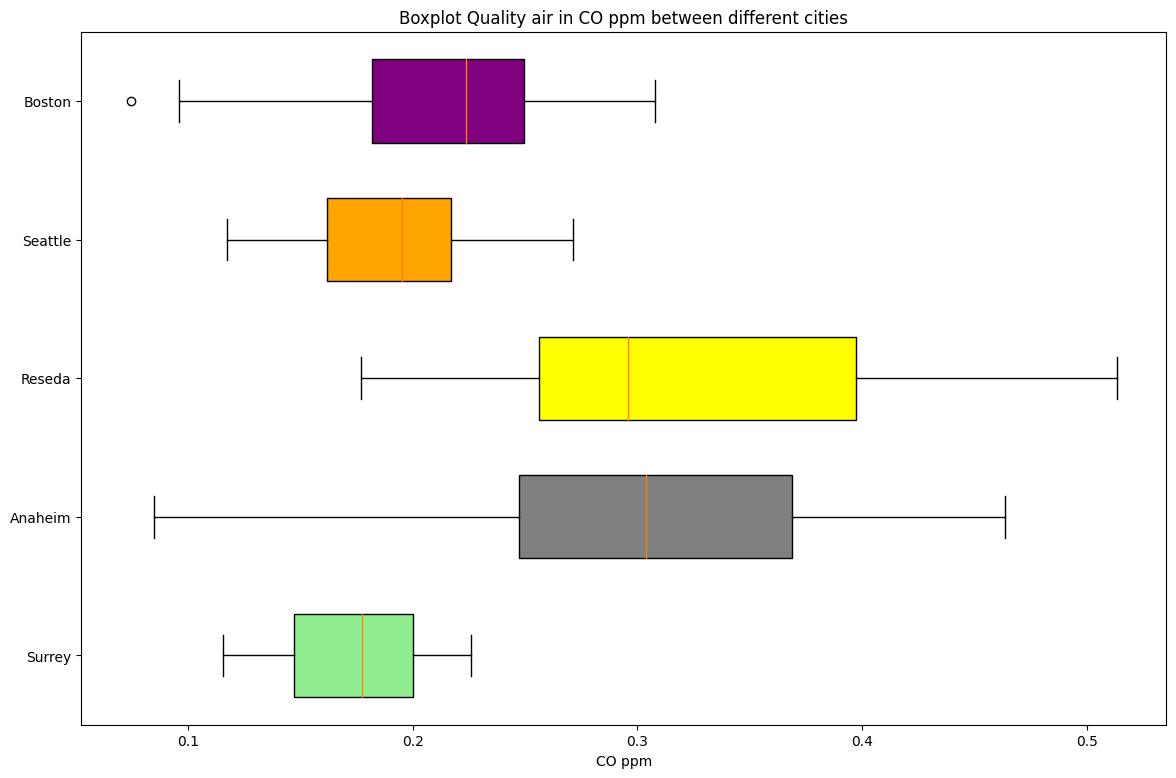

In [ ]:
# Surrey data preparation
SR_df_filtered = surrey_df.copy() # Df copy
SR_df_filtered['date'] = pd.to_datetime(SR_df_filtered['date']) # Convert the date column to datetime objects for proper manipulation
SR_df_filtered['CO ppm'] = pd.to_numeric(SR_df_filtered['CO ppm'], errors='coerce') # Convert the value to numeric type, coercing to handle errors
SR_df_filtered = SR_df_filtered.dropna(subset=['CO ppm']) # Drop any rows where 'value' is NaN because cannot be used in numerical calculations
SR_df_filtered.set_index('date', inplace=True) # Set the 'date' column as index of the DataFrame because is required for resampling
SR_monthly_avg = SR_df_filtered['CO ppm'].resample('M').mean() # Resample the data to monthly frequency (calc month mean)

# Annaheim data preparation
# Follow the same structure as Surrey plot, comments are the same
anaheim_df_filtered = anaheim_df.copy()
anaheim_df_filtered['date'] = pd.to_datetime(anaheim_df_filtered['date'])
anaheim_df_filtered['CO ppm'] = pd.to_numeric(anaheim_df_filtered['CO ppm'], errors='coerce')
anaheim_df_filtered = anaheim_df_filtered.dropna(subset=['CO ppm'])
anaheim_df_filtered.set_index('date', inplace=True)
anaheim_monthly_avg = anaheim_df_filtered['CO ppm'].resample('M').mean()

# Reseda data preparation
# Follow the same structure as Surrey plot, comments are the same
reseda_df_filtered = reseda_df.copy()
reseda_df_filtered['date'] = pd.to_datetime(reseda_df_filtered['date'])
reseda_df_filtered['CO ppm'] = pd.to_numeric(reseda_df_filtered['CO ppm'], errors='coerce')
reseda_df_filtered = reseda_df_filtered.dropna(subset=['CO ppm'])
reseda_df_filtered.set_index('date', inplace=True)
reseda_monthly_avg = reseda_df_filtered['CO ppm'].resample('M').mean()

# Seattle data preparation
# Follow the same structure as Surrey plot, comments are the same
seattle_df_filtered = seattle_df.copy()
seattle_df_filtered['date'] = pd.to_datetime(seattle_df_filtered['date'])
seattle_df_filtered['CO ppm'] = pd.to_numeric(seattle_df_filtered['CO ppm'], errors='coerce')
seattle_df_filtered = seattle_df_filtered.dropna(subset=['CO ppm'])
seattle_df_filtered.set_index('date', inplace=True)
seattle_monthly_avg = seattle_df_filtered['CO ppm'].resample('M').mean()

# Boston data preparation
# Follow the same structure as Surrey plot, comments are the same
boston_df_filtered = boston_df.copy()
boston_df_filtered['date'] = pd.to_datetime(boston_df_filtered['date'])
boston_df_filtered['CO ppm'] = pd.to_numeric(boston_df_filtered['CO ppm'], errors='coerce')
boston_df_filtered = boston_df_filtered.dropna(subset=['CO ppm'])
boston_df_filtered.set_index('date', inplace=True)
boston_monthly_avg = boston_df_filtered['CO ppm'].resample('M').mean()

# Creation of the graph and its dimensions
plt.figure(figsize=(14, 9))

# Add the boxplots for each city in different positions of the plot
# Also added parameters that are specific to the plot
plt.boxplot(SR_monthly_avg, positions=[1], vert=False, patch_artist=True, widths=0.6, boxprops=dict(facecolor='lightgreen'))
plt.boxplot(anaheim_monthly_avg, positions=[2], vert=False, patch_artist=True, widths=0.6, boxprops=dict(facecolor='grey'))
plt.boxplot(reseda_monthly_avg, positions=[3], vert=False, patch_artist=True, widths=0.6, boxprops=dict(facecolor='yellow'))
plt.boxplot(seattle_monthly_avg, positions=[4], vert=False, patch_artist=True, widths=0.6, boxprops=dict(facecolor='orange'))
plt.boxplot(boston_monthly_avg, positions=[5], vert=False, patch_artist=True, widths=0.6, boxprops=dict(facecolor='purple'))

# Create lebels for each city
plt.yticks([1, 2, 3, 4, 5], ['Surrey', 'Anaheim', 'Reseda', 'Seattle', 'Boston'])
plt.title('Boxplot Quality air in CO ppm between different cities')
plt.xlabel('CO ppm')

# Show plot
plt.show()

When analyzing the distribution of carbon monoxide or CO pollution between cities, it can be inferred that, as in the previous graph, Surrey continues to be the city with the least pollution of these two types already analyzed; however, a certain closeness can be noted between Reseda and Anaheim in terms of the distribution of their measurements. For this case and the following ones, Costa Rica will not be considered any more since it does not have measurements of the sensors that will be presented.

#### NO ppm box plot

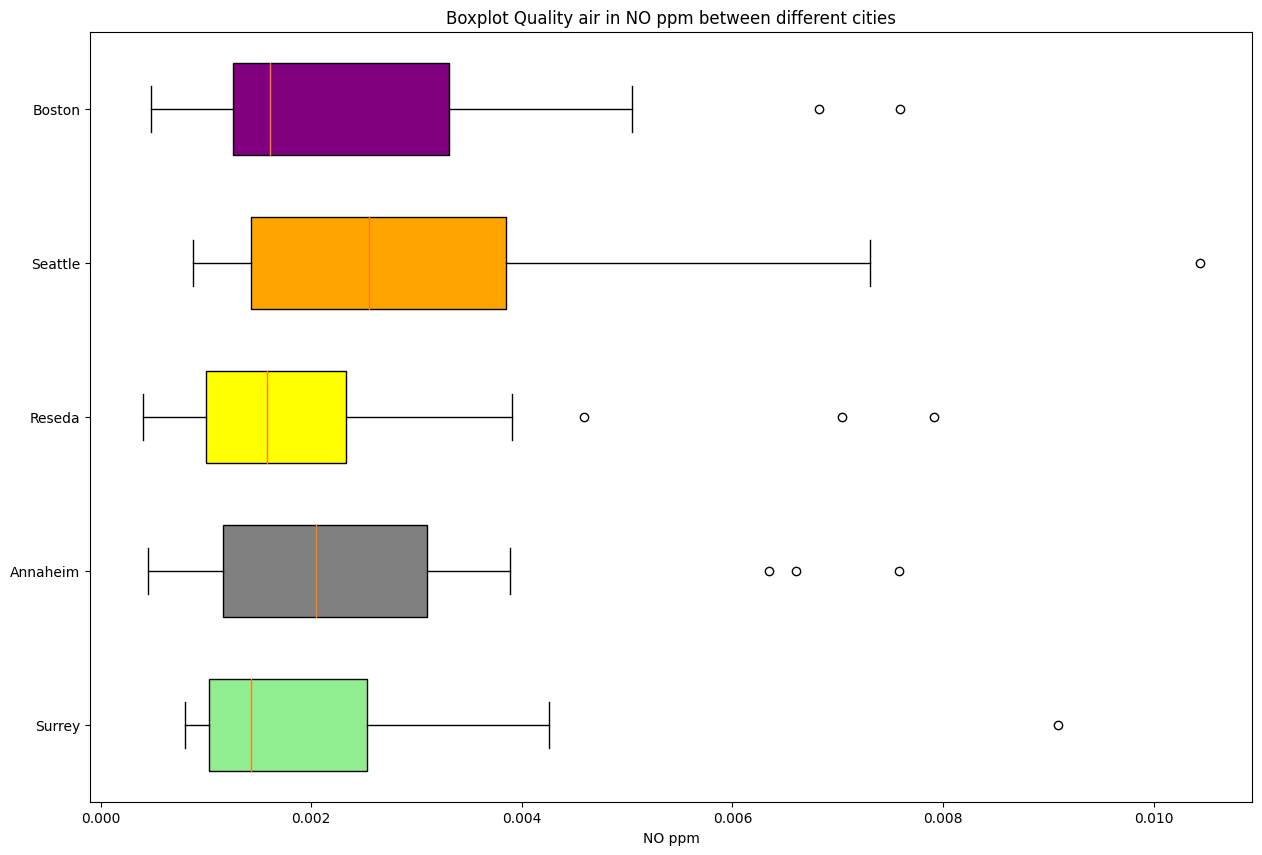

In [ ]:
# IMPORTANT: Follow the same structure as previous grahps

# Surrey data preparation
SR_df_filtered = surrey_df.copy()
SR_df_filtered = SR_df_filtered[SR_df_filtered['date'] > '2023-04']
SR_df_filtered['date'] = pd.to_datetime(SR_df_filtered['date'])
SR_df_filtered['NO ppm'] = pd.to_numeric(SR_df_filtered['NO ppm'], errors='coerce')
SR_df_filtered = SR_df_filtered.dropna(subset=['NO ppm'])
SR_df_filtered.set_index('date', inplace=True)
SR_monthly_avg = SR_df_filtered['NO ppm'].resample('M').mean()

# Annaheim data preparation
anaheim_df_filtered = anaheim_df.copy()
anaheim_df_filtered = anaheim_df_filtered[anaheim_df_filtered['date'] > '2023-04']
anaheim_df_filtered['date'] = pd.to_datetime(anaheim_df_filtered['date'])
anaheim_df_filtered['NO ppm'] = pd.to_numeric(anaheim_df_filtered['NO ppm'], errors='coerce')
anaheim_df_filtered = anaheim_df_filtered.dropna(subset=['NO ppm'])
anaheim_df_filtered.set_index('date', inplace=True)
anaheim_monthly_avg = anaheim_df_filtered['NO ppm'].resample('M').mean()

# Reseda data preparation
reseda_df_filtered = reseda_df.copy()
reseda_df_filtered = reseda_df_filtered[reseda_df_filtered['date'] > '2023-04']
reseda_df_filtered['date'] = pd.to_datetime(reseda_df_filtered['date'])
reseda_df_filtered['NO ppm'] = pd.to_numeric(reseda_df_filtered['NO ppm'], errors='coerce')
reseda_df_filtered = reseda_df_filtered.dropna(subset=['NO ppm'])
reseda_df_filtered.set_index('date', inplace=True)
reseda_monthly_avg = reseda_df_filtered['NO ppm'].resample('M').mean()

# Seattle data preparation
seattle_df_filtered = seattle_df.copy()
seattle_df_filtered = seattle_df_filtered[seattle_df_filtered['date'] > '2023-04']
seattle_df_filtered['date'] = pd.to_datetime(seattle_df_filtered['date'])
seattle_df_filtered['NO ppm'] = pd.to_numeric(seattle_df_filtered['NO ppm'], errors='coerce')
seattle_df_filtered = seattle_df_filtered.dropna(subset=['NO ppm'])
seattle_df_filtered.set_index('date', inplace=True)
seattle_monthly_avg = seattle_df_filtered['NO ppm'].resample('M').mean()

# Boston data preparation
boston_df_filtered = boston_df.copy()
boston_df_filtered = boston_df_filtered[boston_df_filtered['date'] > '2023-04']
boston_df_filtered['date'] = pd.to_datetime(boston_df_filtered['date'])
boston_df_filtered['NO ppm'] = pd.to_numeric(boston_df_filtered['NO ppm'], errors='coerce')
boston_df_filtered = boston_df_filtered.dropna(subset=['NO ppm'])
boston_df_filtered.set_index('date', inplace=True)
boston_monthly_avg = boston_df_filtered['NO ppm'].resample('M').mean()

# Creation of the graph and its dimensions
plt.figure(figsize=(15, 10))

# Add the boxplots for each city in different positions of the plot
# Also added parameters that are specific to the plot
plt.boxplot(SR_monthly_avg, positions=[1], vert=False, patch_artist=True, widths=0.6, boxprops=dict(facecolor='lightgreen'))
plt.boxplot(anaheim_monthly_avg, positions=[2], vert=False, patch_artist=True, widths=0.6, boxprops=dict(facecolor='grey'))
plt.boxplot(reseda_monthly_avg, positions=[3], vert=False, patch_artist=True, widths=0.6, boxprops=dict(facecolor='yellow'))
plt.boxplot(seattle_monthly_avg, positions=[4], vert=False, patch_artist=True, widths=0.6, boxprops=dict(facecolor='orange'))
plt.boxplot(boston_monthly_avg, positions=[5], vert=False, patch_artist=True, widths=0.6, boxprops=dict(facecolor='purple'))

# Create lebels for each city
plt.yticks([1, 2, 3, 4, 5], ['Surrey', 'Annaheim', 'Reseda', 'Seattle', 'Boston'])
plt.title('Boxplot Quality air in NO ppm between different cities')
plt.xlabel('NO ppm')

# Show plot
plt.show()

#### NO₂ ppm (Nitrogen dioxide) box plot

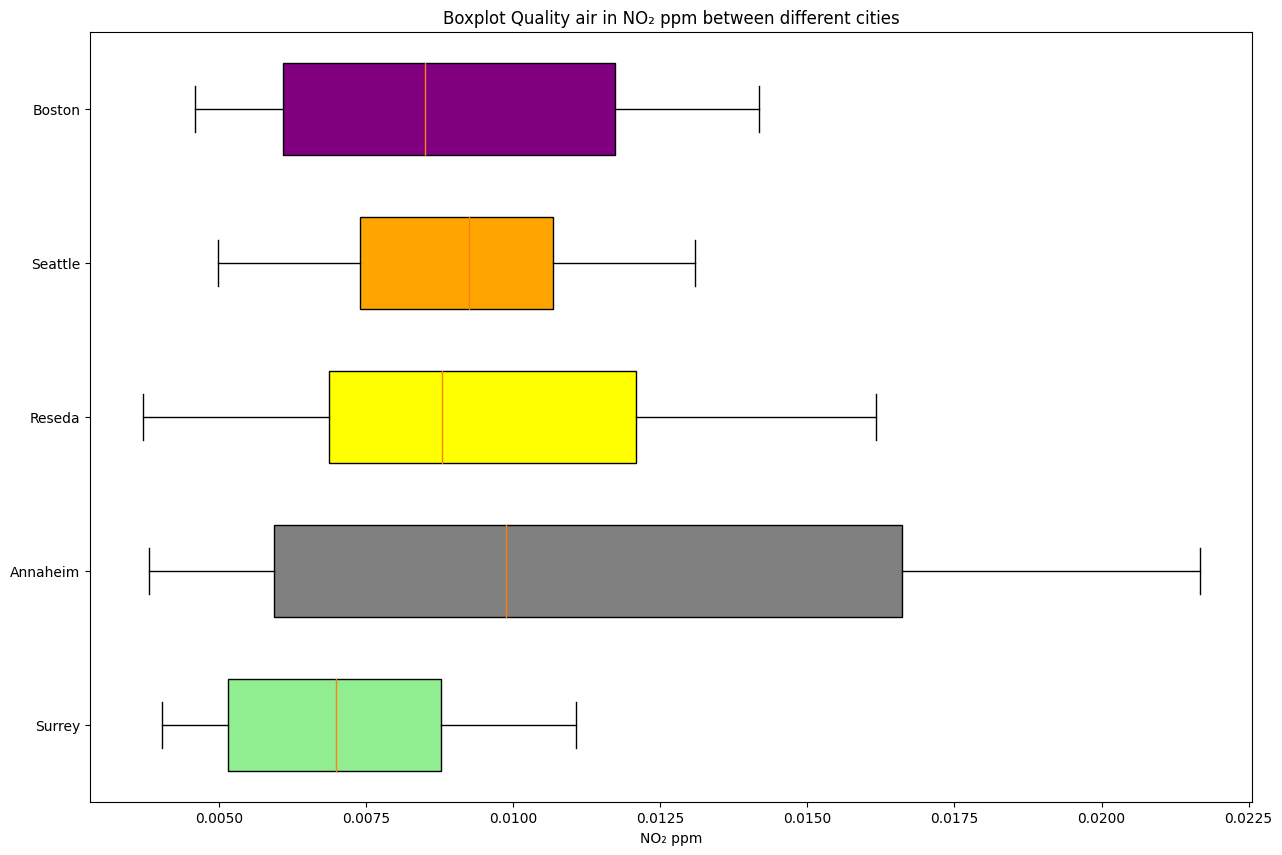

In [ ]:
# IMPORTANT: Follow the same structure as previous grahps

# Surrey data preparation
SR_df_filtered = surrey_df.copy()
SR_df_filtered['date'] = pd.to_datetime(SR_df_filtered['date'])
SR_df_filtered['NO₂ ppm'] = pd.to_numeric(SR_df_filtered['NO₂ ppm'], errors='coerce')
SR_df_filtered = SR_df_filtered.dropna(subset=['NO₂ ppm'])
SR_df_filtered.set_index('date', inplace=True)
SR_monthly_avg = SR_df_filtered['NO₂ ppm'].resample('M').mean()

# Annaheim data preparation
anaheim_df_filtered = anaheim_df.copy()
anaheim_df_filtered['date'] = pd.to_datetime(anaheim_df_filtered['date'])
anaheim_df_filtered['NO₂ ppm'] = pd.to_numeric(anaheim_df_filtered['NO₂ ppm'], errors='coerce')
anaheim_df_filtered = anaheim_df_filtered.dropna(subset=['NO₂ ppm'])
anaheim_df_filtered.set_index('date', inplace=True)
anaheim_monthly_avg = anaheim_df_filtered['NO₂ ppm'].resample('M').mean()

# Reseda data preparation
reseda_df_filtered = reseda_df.copy()
reseda_df_filtered['date'] = pd.to_datetime(reseda_df_filtered['date'])
reseda_df_filtered['NO₂ ppm'] = pd.to_numeric(reseda_df_filtered['NO₂ ppm'], errors='coerce')
reseda_df_filtered = reseda_df_filtered.dropna(subset=['NO₂ ppm'])
reseda_df_filtered.set_index('date', inplace=True)
reseda_monthly_avg = reseda_df_filtered['NO₂ ppm'].resample('M').mean()

# Seattle data preparation
seattle_df_filtered = seattle_df.copy()
seattle_df_filtered['date'] = pd.to_datetime(seattle_df_filtered['date'])
seattle_df_filtered['NO₂ ppm'] = pd.to_numeric(seattle_df_filtered['NO₂ ppm'], errors='coerce')
seattle_df_filtered = seattle_df_filtered.dropna(subset=['NO₂ ppm'])
seattle_df_filtered.set_index('date', inplace=True)
seattle_monthly_avg = seattle_df_filtered['NO₂ ppm'].resample('M').mean()

# Boston data preparation
boston_df_filtered = boston_df.copy()
boston_df_filtered['date'] = pd.to_datetime(boston_df_filtered['date'])
boston_df_filtered['NO₂ ppm'] = pd.to_numeric(boston_df_filtered['NO₂ ppm'], errors='coerce')
boston_df_filtered = boston_df_filtered.dropna(subset=['NO₂ ppm'])
boston_df_filtered.set_index('date', inplace=True)
boston_monthly_avg = boston_df_filtered['NO₂ ppm'].resample('M').mean()

# Creation of the graph and its dimensions
plt.figure(figsize=(15, 10))

# Add the boxplots for each city in different positions of the plot
# Also added parameters that are specific to the plot
plt.boxplot(SR_monthly_avg, positions=[1], vert=False, patch_artist=True, widths=0.6, boxprops=dict(facecolor='lightgreen'))
plt.boxplot(anaheim_monthly_avg, positions=[2], vert=False, patch_artist=True, widths=0.6, boxprops=dict(facecolor='grey'))
plt.boxplot(reseda_monthly_avg, positions=[3], vert=False, patch_artist=True, widths=0.6, boxprops=dict(facecolor='yellow'))
plt.boxplot(seattle_monthly_avg, positions=[4], vert=False, patch_artist=True, widths=0.6, boxprops=dict(facecolor='orange'))
plt.boxplot(boston_monthly_avg, positions=[5], vert=False, patch_artist=True, widths=0.6, boxprops=dict(facecolor='purple'))

# Create lebels for each city
plt.yticks([1, 2, 3, 4, 5], ['Surrey', 'Annaheim', 'Reseda', 'Seattle', 'Boston'])
plt.title('Boxplot Quality air in NO₂ ppm between different cities')
plt.xlabel('NO₂ ppm')

# Show plot
plt.show()

Based on the above graph, we can observe some points, first, every city has a similar lowest value of nitrogen dioxide (NO₂) in the air, except Seattle and Boston, that its lower value is bigger than the rest where we can say that its lowest pollution is the worst between the other cities. Secondly, Surrey is the city with less pollution of NO₂ and this also match with the other graphs presented. And finally, Anaheim is the city with the most pollution, where it has the largest range, the largest value of pollution of NO₂ and the biggest section between the 25 and 75 percentiles.

#### O₃ ppm box plot

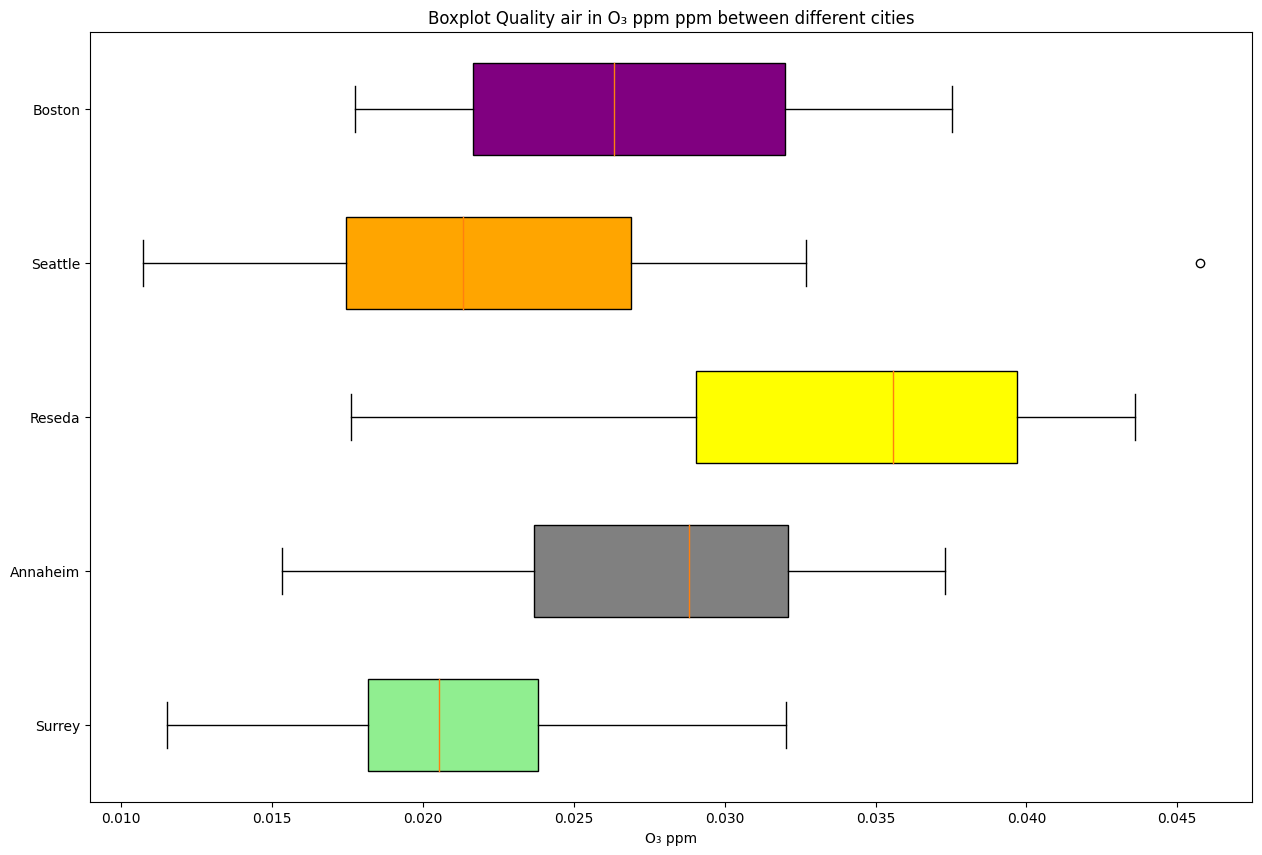

In [ ]:
# IMPORTANT: Follow the same structure as previous grahps

# Surrey data preparation
SR_df_filtered = surrey_df.copy()
SR_df_filtered['date'] = pd.to_datetime(SR_df_filtered['date'])
SR_df_filtered['O₃ ppm'] = pd.to_numeric(SR_df_filtered['O₃ ppm'], errors='coerce')
SR_df_filtered = SR_df_filtered.dropna(subset=['O₃ ppm'])
SR_df_filtered.set_index('date', inplace=True)
SR_monthly_avg = SR_df_filtered['O₃ ppm'].resample('M').mean()

# Annaheim data preparation
anaheim_df_filtered = anaheim_df.copy()
anaheim_df_filtered['date'] = pd.to_datetime(anaheim_df_filtered['date'])
anaheim_df_filtered['O₃ ppm'] = pd.to_numeric(anaheim_df_filtered['O₃ ppm'], errors='coerce')
anaheim_df_filtered = anaheim_df_filtered.dropna(subset=['O₃ ppm'])
anaheim_df_filtered.set_index('date', inplace=True)
anaheim_monthly_avg = anaheim_df_filtered['O₃ ppm'].resample('M').mean()

# Reseda data preparation
reseda_df_filtered = reseda_df.copy()
reseda_df_filtered['date'] = pd.to_datetime(reseda_df_filtered['date'])
reseda_df_filtered['O₃ ppm'] = pd.to_numeric(reseda_df_filtered['O₃ ppm'], errors='coerce')
reseda_df_filtered = reseda_df_filtered.dropna(subset=['O₃ ppm'])
reseda_df_filtered.set_index('date', inplace=True)
reseda_monthly_avg = reseda_df_filtered['O₃ ppm'].resample('M').mean()

# Seattle data preparation
seattle_df_filtered = seattle_df.copy()
seattle_df_filtered['date'] = pd.to_datetime(seattle_df_filtered['date'])
seattle_df_filtered['O₃ ppm'] = pd.to_numeric(seattle_df_filtered['O₃ ppm'], errors='coerce')
seattle_df_filtered = seattle_df_filtered.dropna(subset=['O₃ ppm'])
seattle_df_filtered.set_index('date', inplace=True)
seattle_monthly_avg = seattle_df_filtered['O₃ ppm'].resample('M').mean()

# Boston data preparation
boston_df_filtered = boston_df.copy()
boston_df_filtered['date'] = pd.to_datetime(boston_df_filtered['date'])
boston_df_filtered['O₃ ppm'] = pd.to_numeric(boston_df_filtered['O₃ ppm'], errors='coerce')
boston_df_filtered = boston_df_filtered.dropna(subset=['O₃ ppm'])
boston_df_filtered.set_index('date', inplace=True)
boston_monthly_avg = boston_df_filtered['O₃ ppm'].resample('M').mean()

# Creation of the graph and its dimensions
plt.figure(figsize=(15, 10))

# Add the boxplots for each city in different positions of the plot
# Also added parameters that are specific to the plot
plt.boxplot(SR_monthly_avg, positions=[1], vert=False, patch_artist=True, widths=0.6, boxprops=dict(facecolor='lightgreen'))
plt.boxplot(anaheim_monthly_avg, positions=[2], vert=False, patch_artist=True, widths=0.6, boxprops=dict(facecolor='grey'))
plt.boxplot(reseda_monthly_avg, positions=[3], vert=False, patch_artist=True, widths=0.6, boxprops=dict(facecolor='yellow'))
plt.boxplot(seattle_monthly_avg, positions=[4], vert=False, patch_artist=True, widths=0.6, boxprops=dict(facecolor='orange'))
plt.boxplot(boston_monthly_avg, positions=[5], vert=False, patch_artist=True, widths=0.6, boxprops=dict(facecolor='purple'))

# Create lebels for each city
plt.yticks([1, 2, 3, 4, 5], ['Surrey', 'Annaheim', 'Reseda', 'Seattle', 'Boston'])
plt.title('Boxplot Quality air in O₃ ppm ppm between different cities')
plt.xlabel('O₃ ppm')

# Show plot
plt.show()

Similar to the graph for NO2, we can conclude that every city has a similar range of values (distance between min and max values) except for Reseda, which has the largest range. Then, Reseda has the biggest value for O3, which makes it the most polluted in 03. Lastly, Seattle and Surrey share the position for cities with the lowest amount of O3.

### Multivariable

In [ ]:
costa_rica_df = costa_rica_df.drop('unit', axis=1)
# Change the "value" column name to "PM2.5 µg/m³"
costa_rica_df = costa_rica_df.rename(columns={"value": "PM2.5 µg/m³"})

# Convert date to datetimes for all datasets
costa_rica_df['date'] = pd.to_datetime(costa_rica_df['date'])
annaheim_df['date'] = pd.to_datetime(annaheim_df['date'])
boston_df['date'] = pd.to_datetime(boston_df['date'])
seattle_df['date'] = pd.to_datetime(seattle_df['date'])
reseda_df['date'] = pd.to_datetime(reseda_df['date'])
surrey_df['date'] = pd.to_datetime(surrey_df['date'])

Describe the datasets to confirm outliers are gone and dataset is clean

In [ ]:
#Describe the datasets
print("Costa Rica description")
costa_rica_df.describe()

Costa Rica description


PM2.5 µg/m³
count  24868.000000
mean       8.316750
std        5.613021
min        0.000000
25%        5.000000
50%        7.000000
75%       11.000000
max       52.250000

In [ ]:
print("Annaheim description")
annaheim_df.describe()

Annaheim description


CO ppm       NO₂ ppm        NO ppm        O₃ ppm   PM2.5 µg/m³
count  33787.000000  33787.000000  33787.000000  33787.000000  33787.000000
mean       0.302179      0.010634      0.001626      0.027346      9.661611
std        0.174219      0.009345      0.003672      0.014790      5.814644
min        0.000000      0.000000      0.000000      0.000000      0.000000
25%        0.200000      0.004000      0.001100      0.017000      5.600000
50%        0.270000      0.007000      0.001100      0.029000      8.800000
75%        0.360000      0.014550      0.001100      0.037333     12.400000
max        1.000000      0.043200      0.062700      0.073000     34.100000

In [ ]:
print("Boston description")
boston_df.describe()


Boston description


CO ppm       NO₂ ppm        NO ppm        O₃ ppm   PM2.5 µg/m³
count  31584.000000  31584.000000  31584.000000  31584.000000  31584.000000
mean       0.215142      0.008946      0.002912      0.026759      6.081863
std        0.104318      0.006425      0.003137      0.011849      3.654675
min        0.000000      0.000000      0.000000      0.000000      0.000000
25%        0.160000      0.004000      0.002000      0.019000      3.800000
50%        0.200000      0.007000      0.003100      0.027000      5.100000
75%        0.260000      0.012000      0.003100      0.034000      8.000000
max        1.040000      0.032900      0.101000      0.063000     19.900000

In [ ]:
print("Seattle description")
seattle_df.describe()

Seattle description


CO ppm       NO₂ ppm        NO ppm        O₃ ppm   PM2.5 µg/m³
count  32382.000000  32382.000000  32382.000000  32382.000000  32382.000000
mean       0.191876      0.009143      0.004058      0.021876      5.026566
std        0.079839      0.006532      0.004362      0.011413      3.614253
min        0.000000      0.000000      0.000000      0.000000      0.000000
25%        0.130000      0.004000      0.001900      0.013250      2.333333
50%        0.190000      0.007300      0.004500      0.022000      4.000000
75%        0.213333      0.013000      0.004500      0.030000      7.000000
max        0.560000      0.031800      0.070300      0.056000     22.000000

In [ ]:
print("Reseda description")
reseda_df.describe()

Reseda description


CO ppm       NO₂ ppm        NO ppm        O₃ ppm   PM2.5 µg/m³
count  34444.000000  34444.000000  34444.000000  34444.000000  34444.000000
mean       0.326251      0.009327      0.001196      0.033482     10.960928
std        0.200535      0.007758      0.003573      0.019407      6.118115
min        0.000000      0.000000      0.000000      0.000000      0.000000
25%        0.200000      0.003600      0.000600      0.019000      6.600000
50%        0.260000      0.006400      0.000600      0.034000     10.200000
75%        0.384167      0.013000      0.000600      0.045000     14.200000
max        1.120000      0.035900      0.062400      0.093000     34.000000

Make sure all the data correspond to the time frame where we got data for Costa Rica

In [ ]:
#Make the dataframes fit in the same date times as Costa Rica
annaheim_df = annaheim_df[(annaheim_df['date'] >= costa_rica_df['date'].min()) & (annaheim_df['date'] <= costa_rica_df['date'].max())]
boston_df = boston_df[(boston_df['date'] >= costa_rica_df['date'].min()) & (boston_df['date'] <= costa_rica_df['date'].max())]
seattle_df = seattle_df[(seattle_df['date'] >= costa_rica_df['date'].min()) & (seattle_df['date'] <= costa_rica_df['date'].max())]
reseda_df = reseda_df[(reseda_df['date'] >= costa_rica_df['date'].min()) & (reseda_df['date'] <= costa_rica_df['date'].max())]
surrey_df = surrey_df[(surrey_df['date'] >= costa_rica_df['date'].min()) & (surrey_df['date'] <= costa_rica_df['date'].max())]

Start by plotting all the available metrics, this way we can detect some trends in the data.

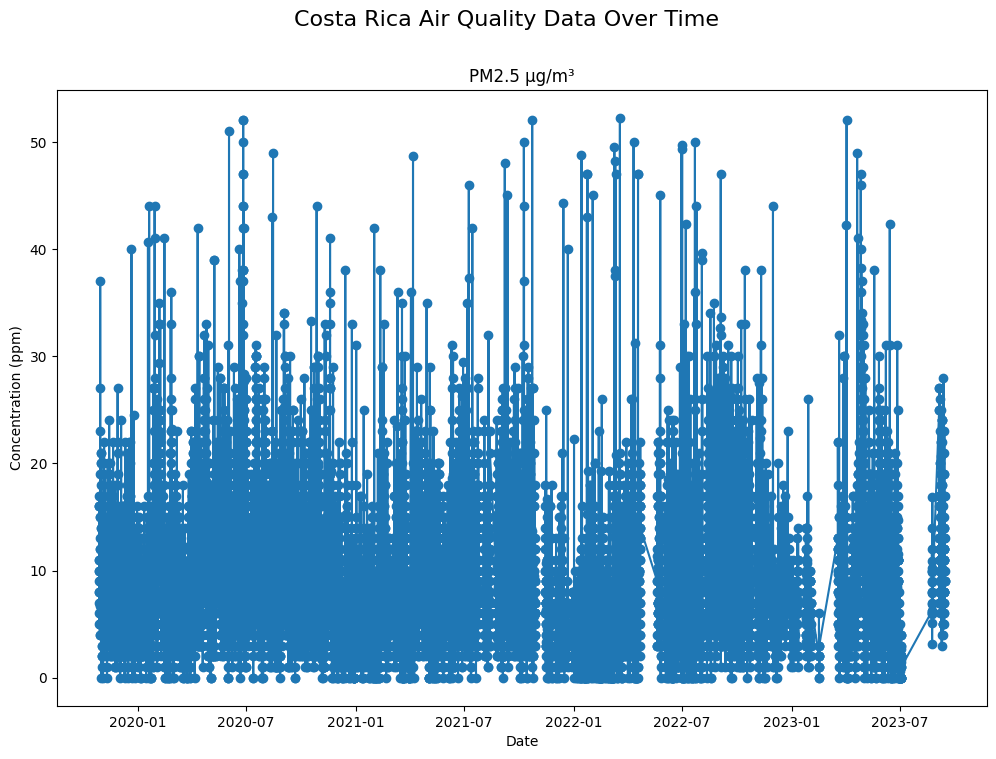

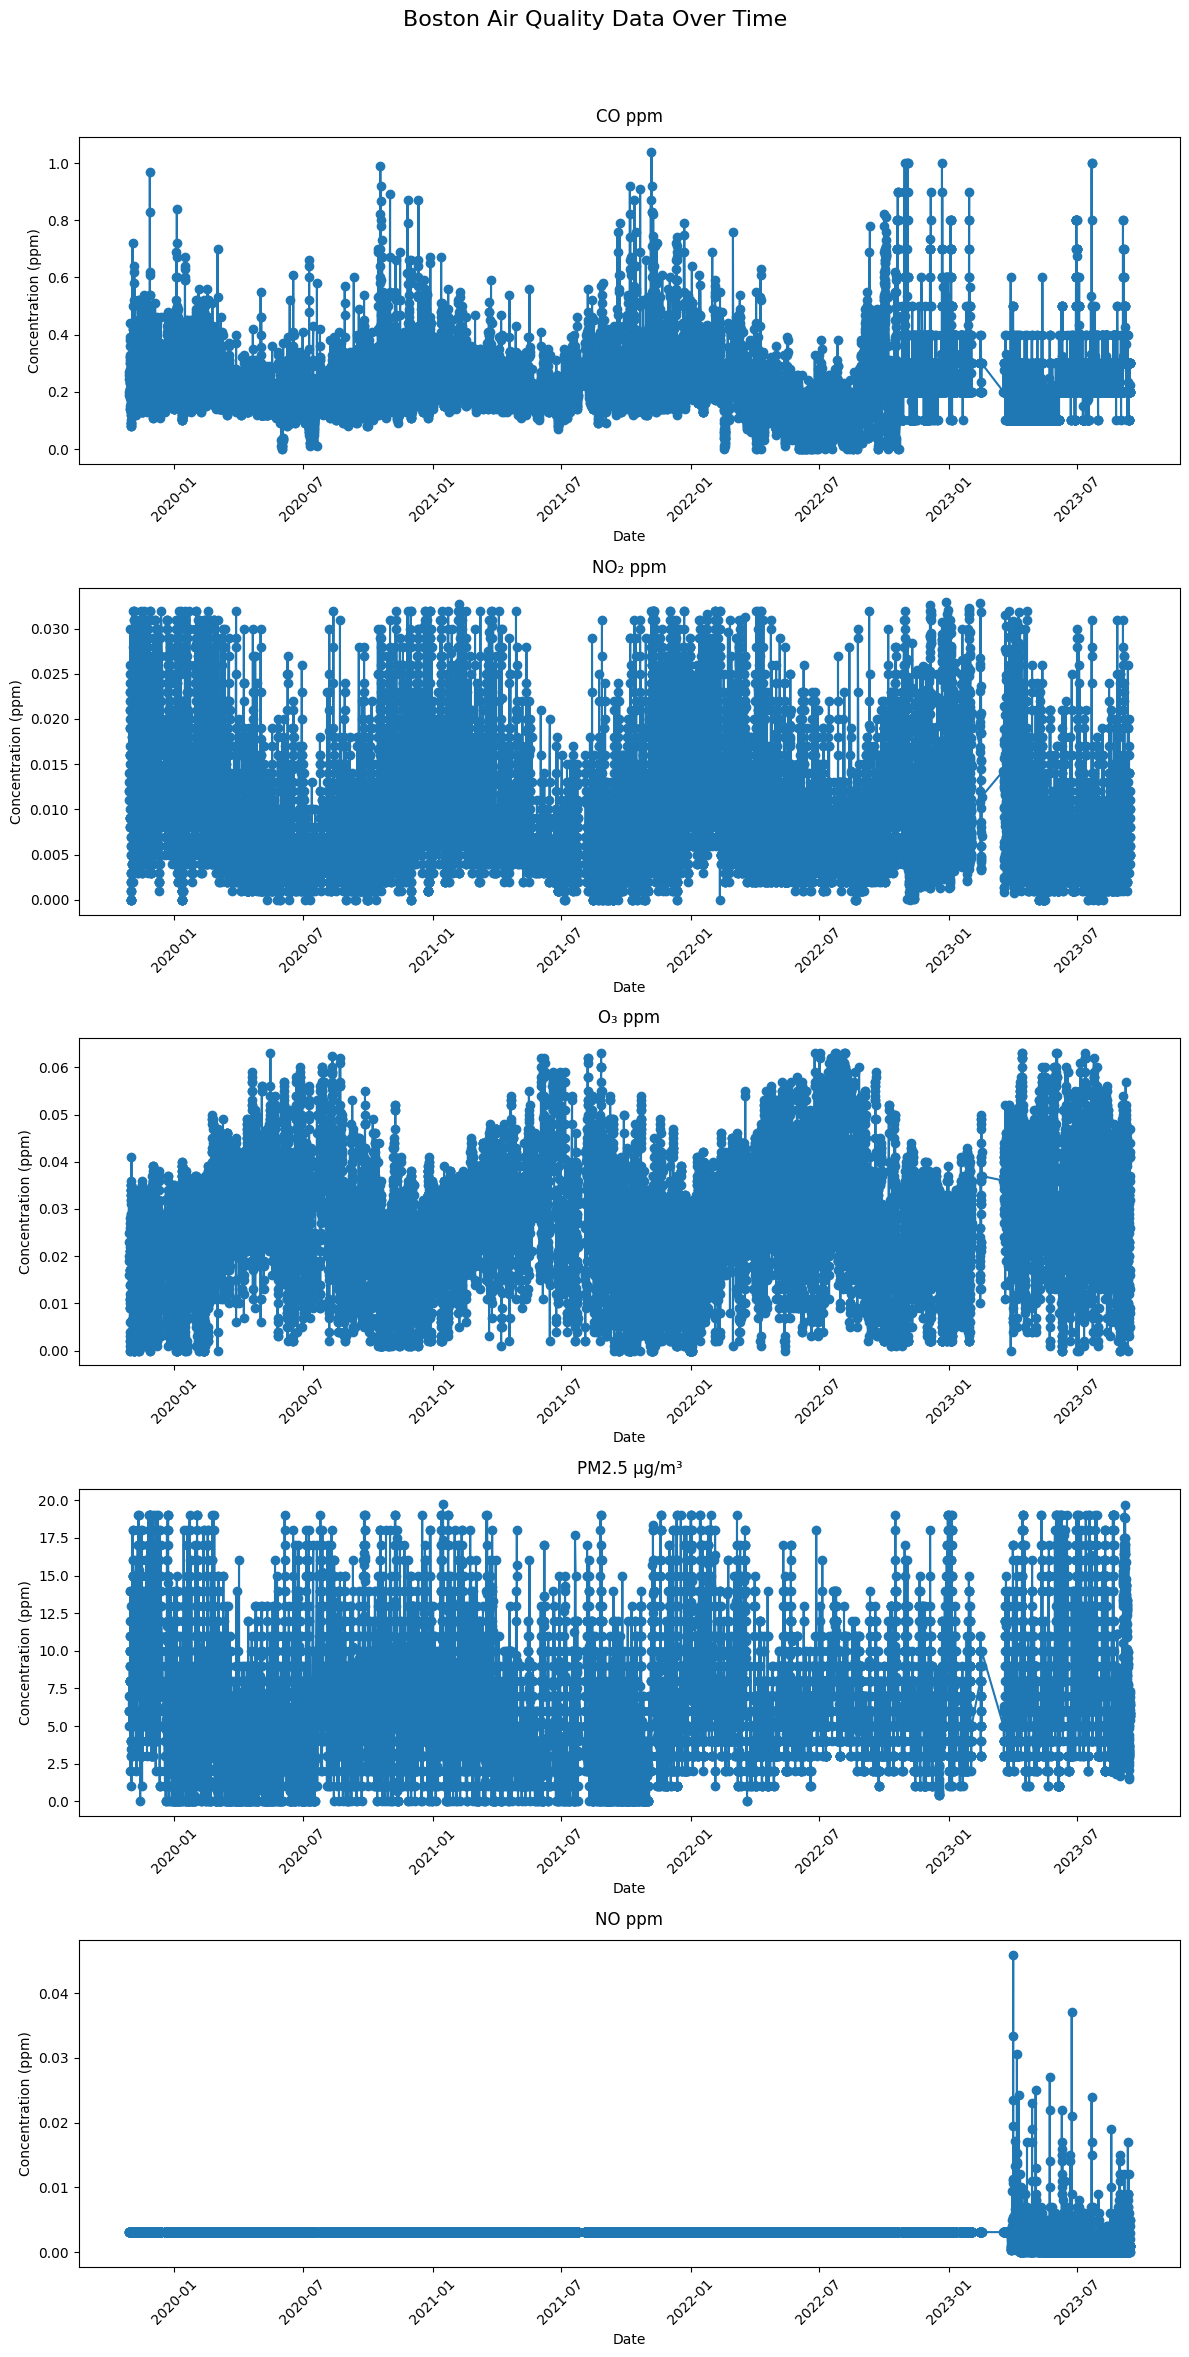

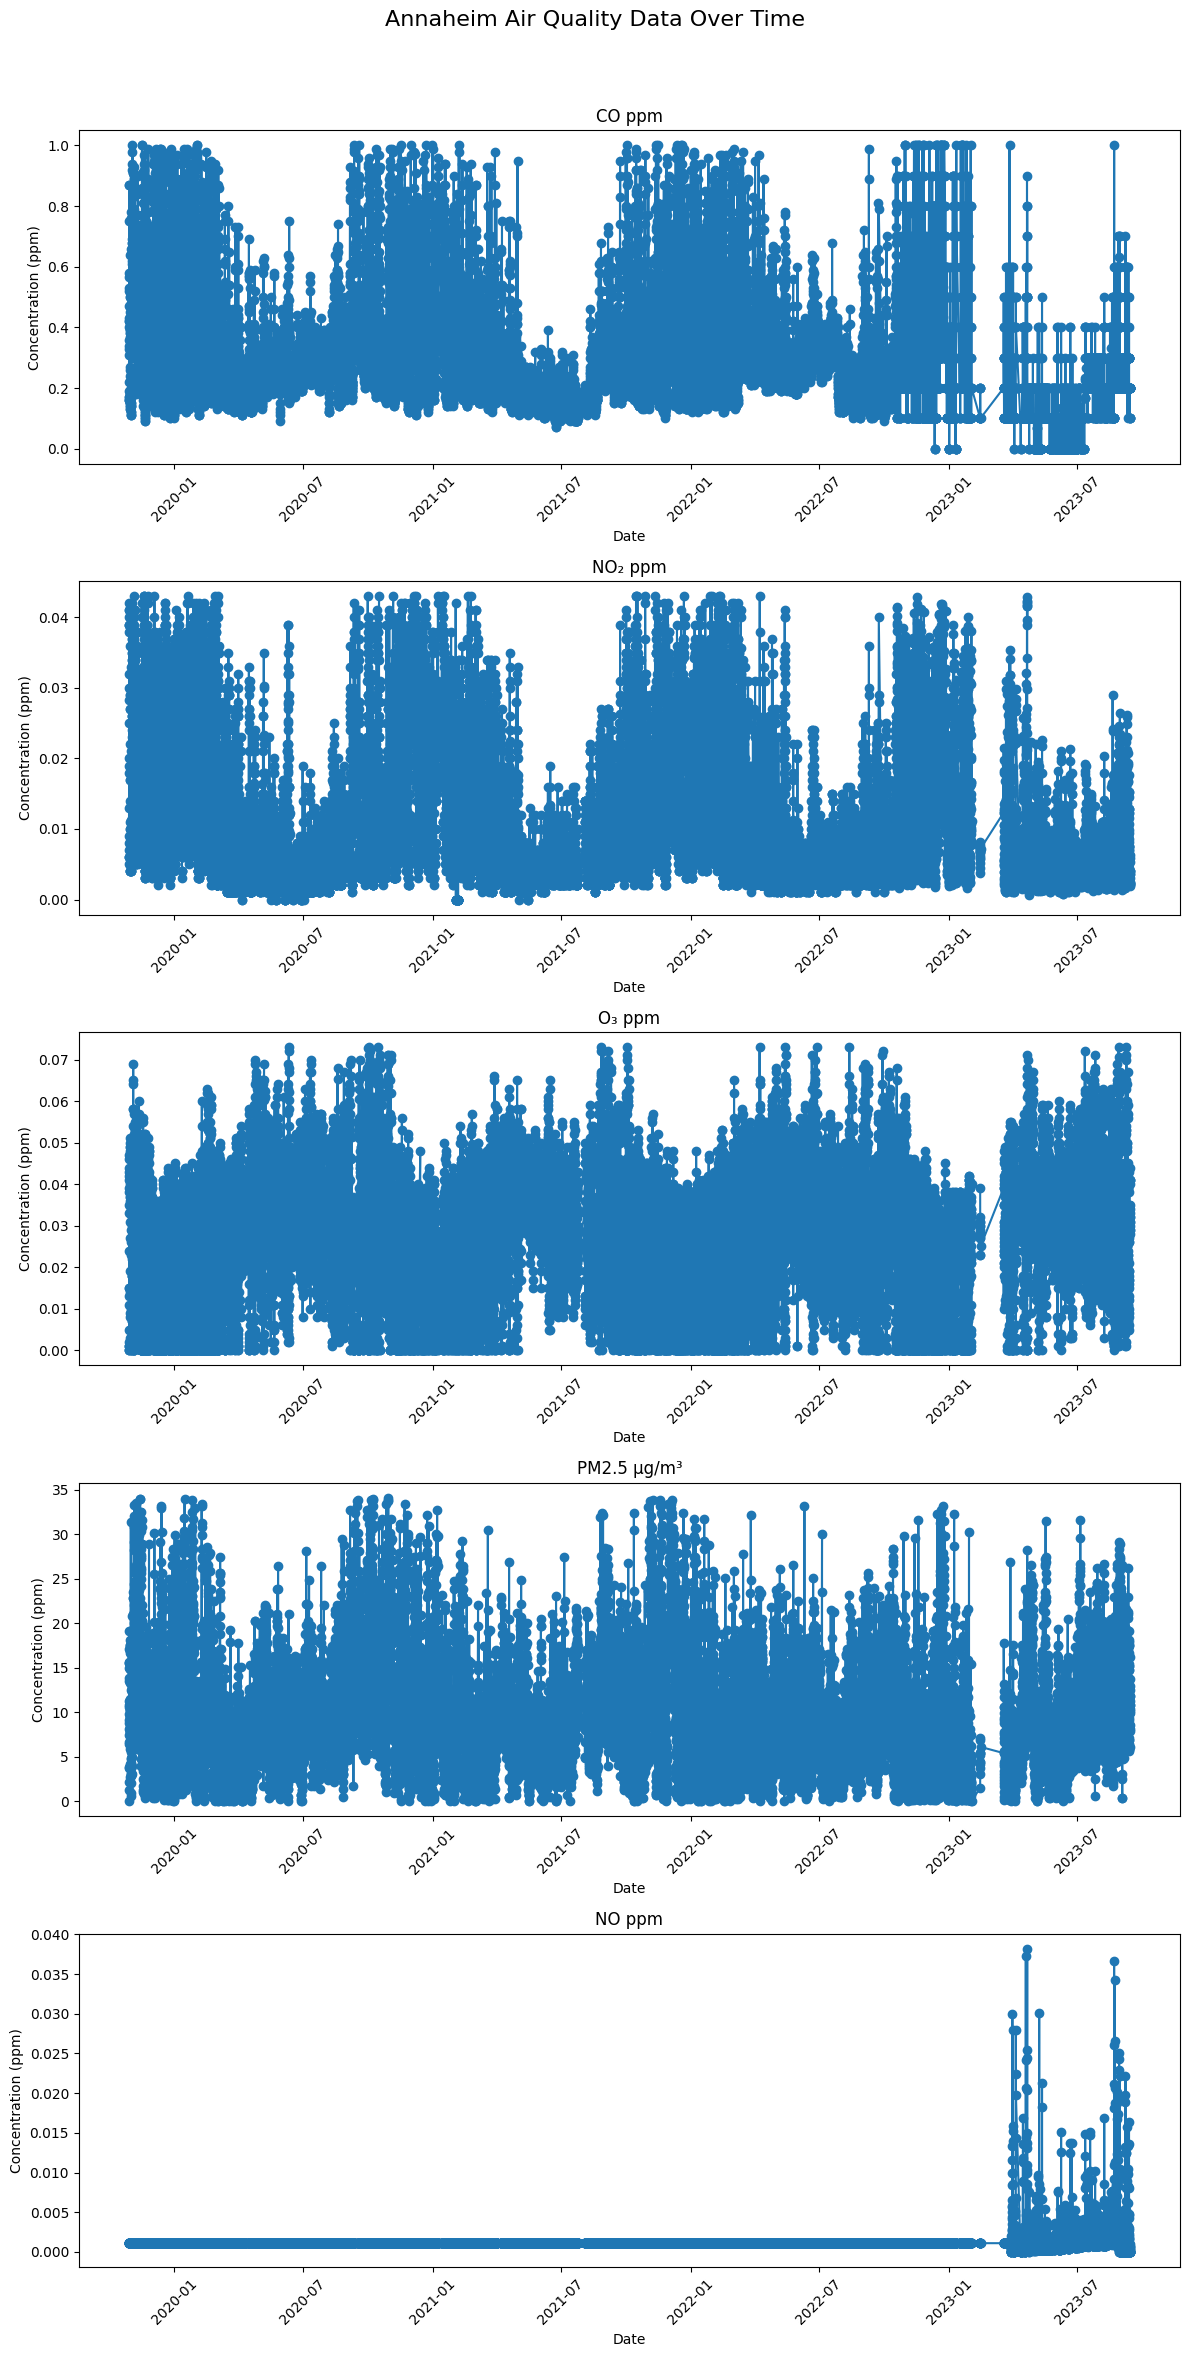

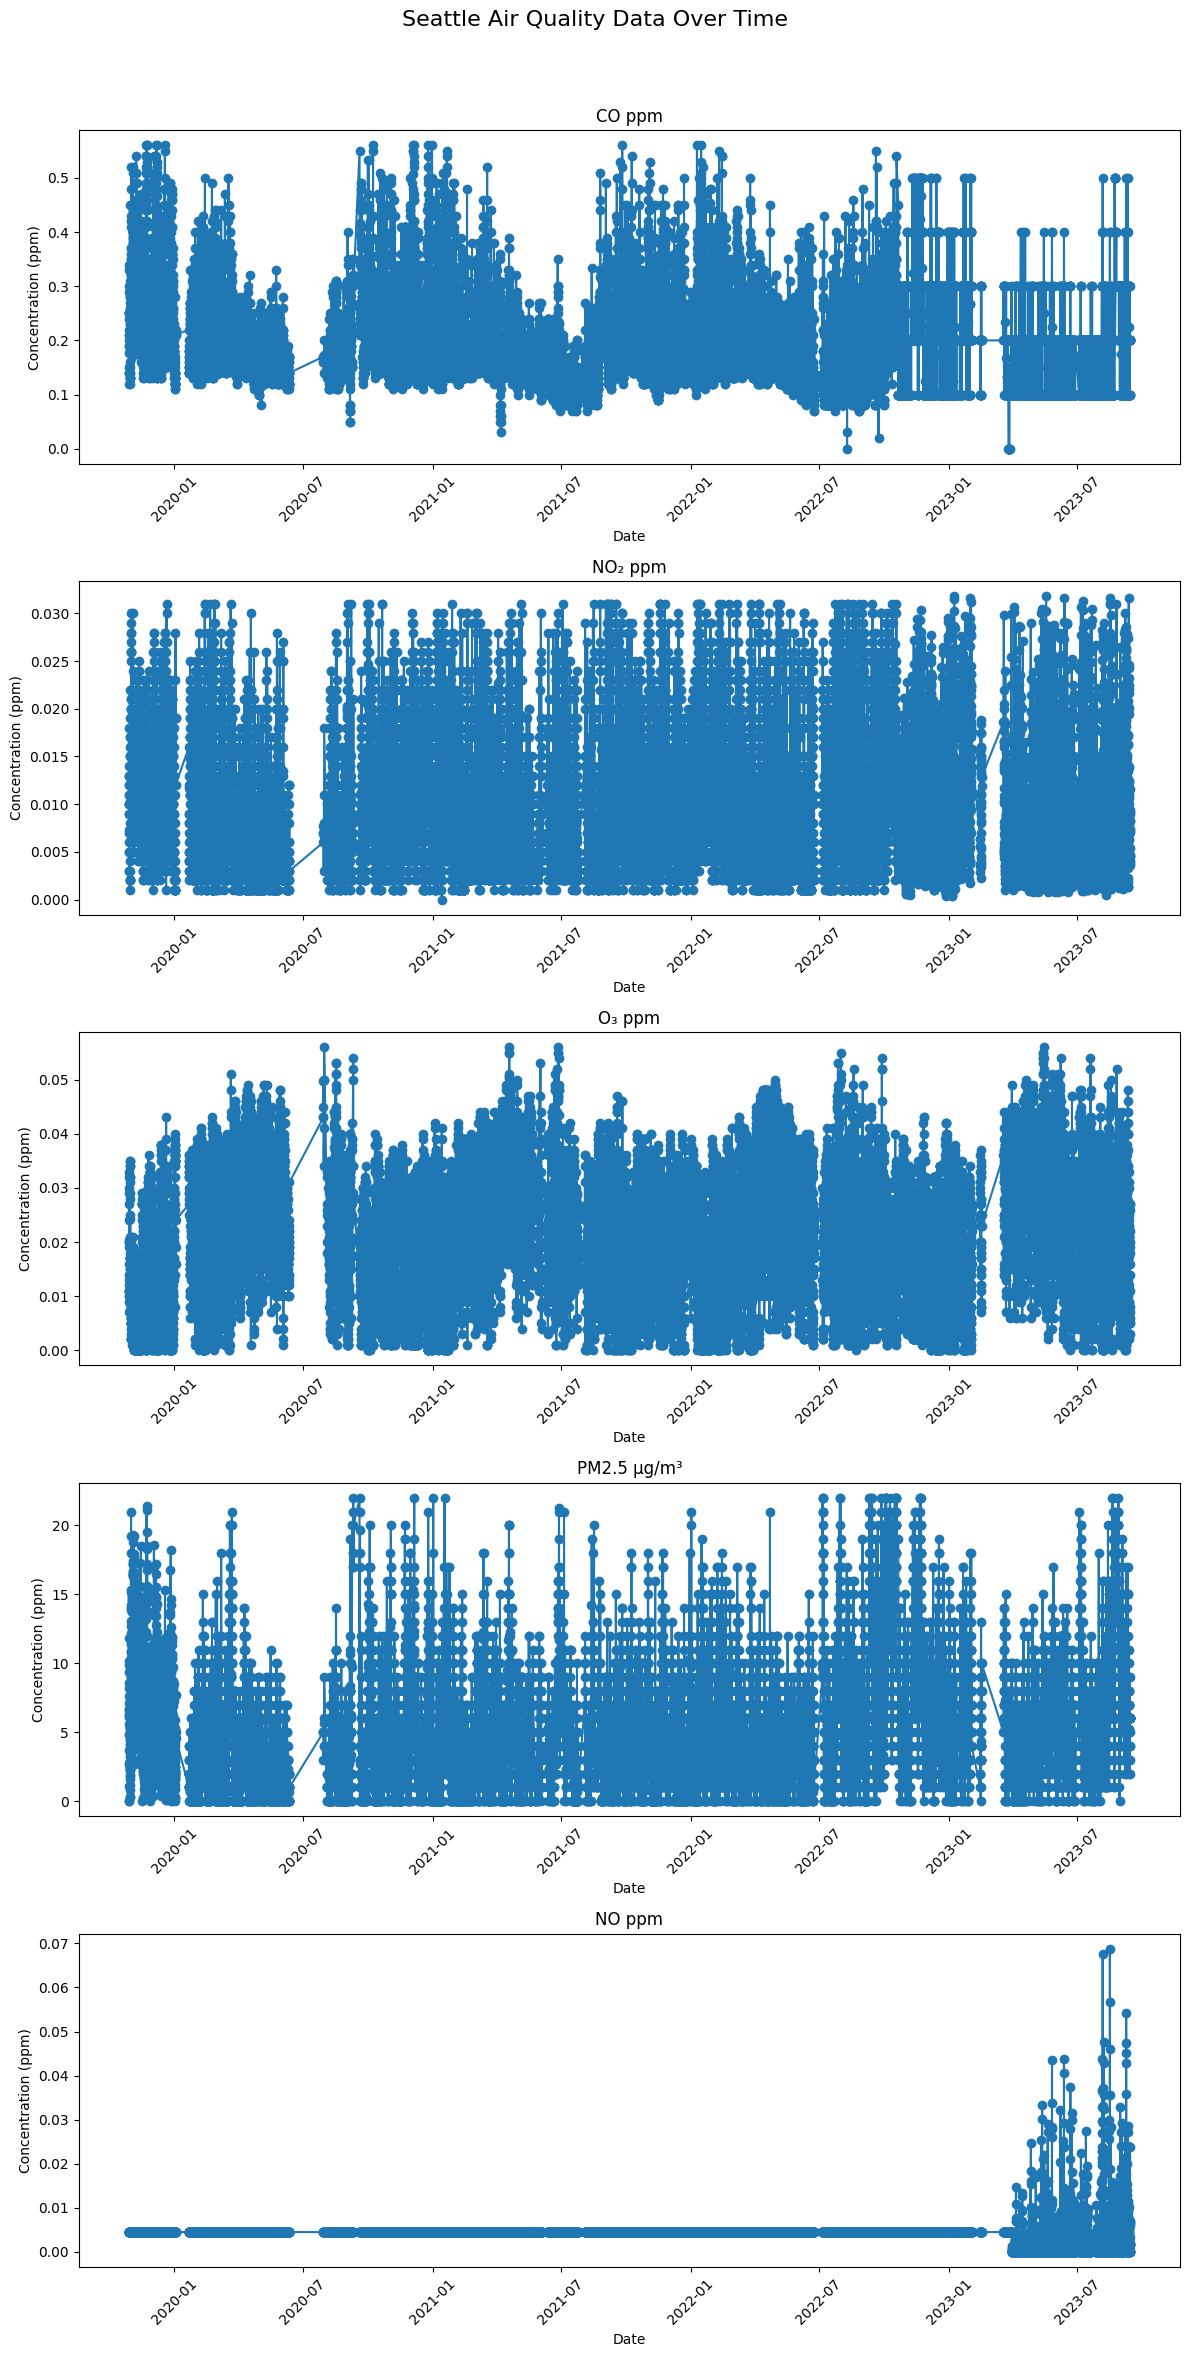

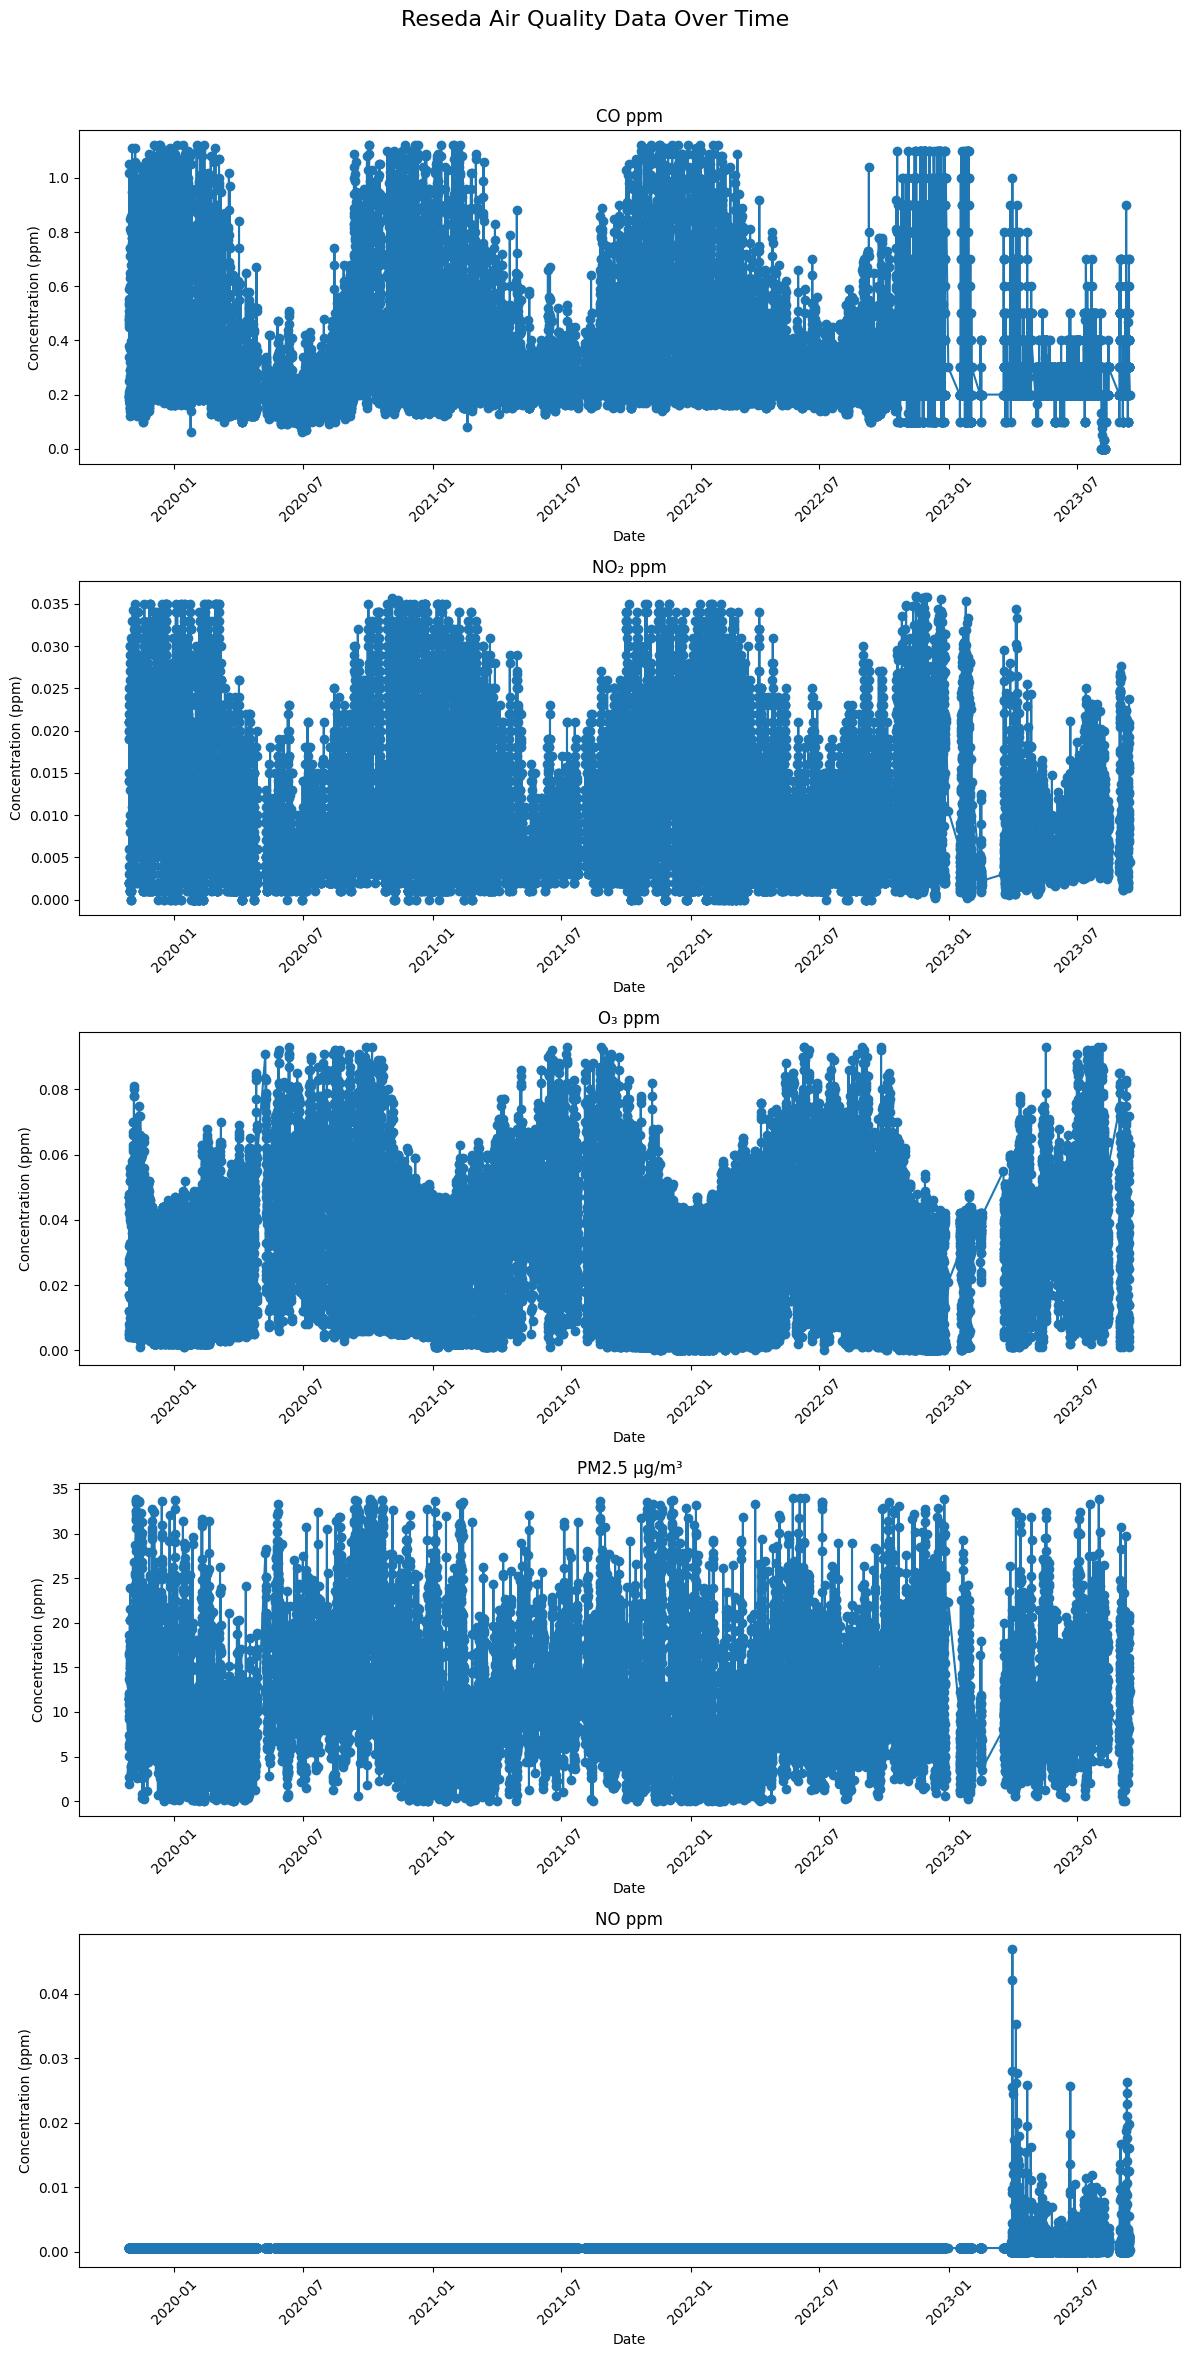

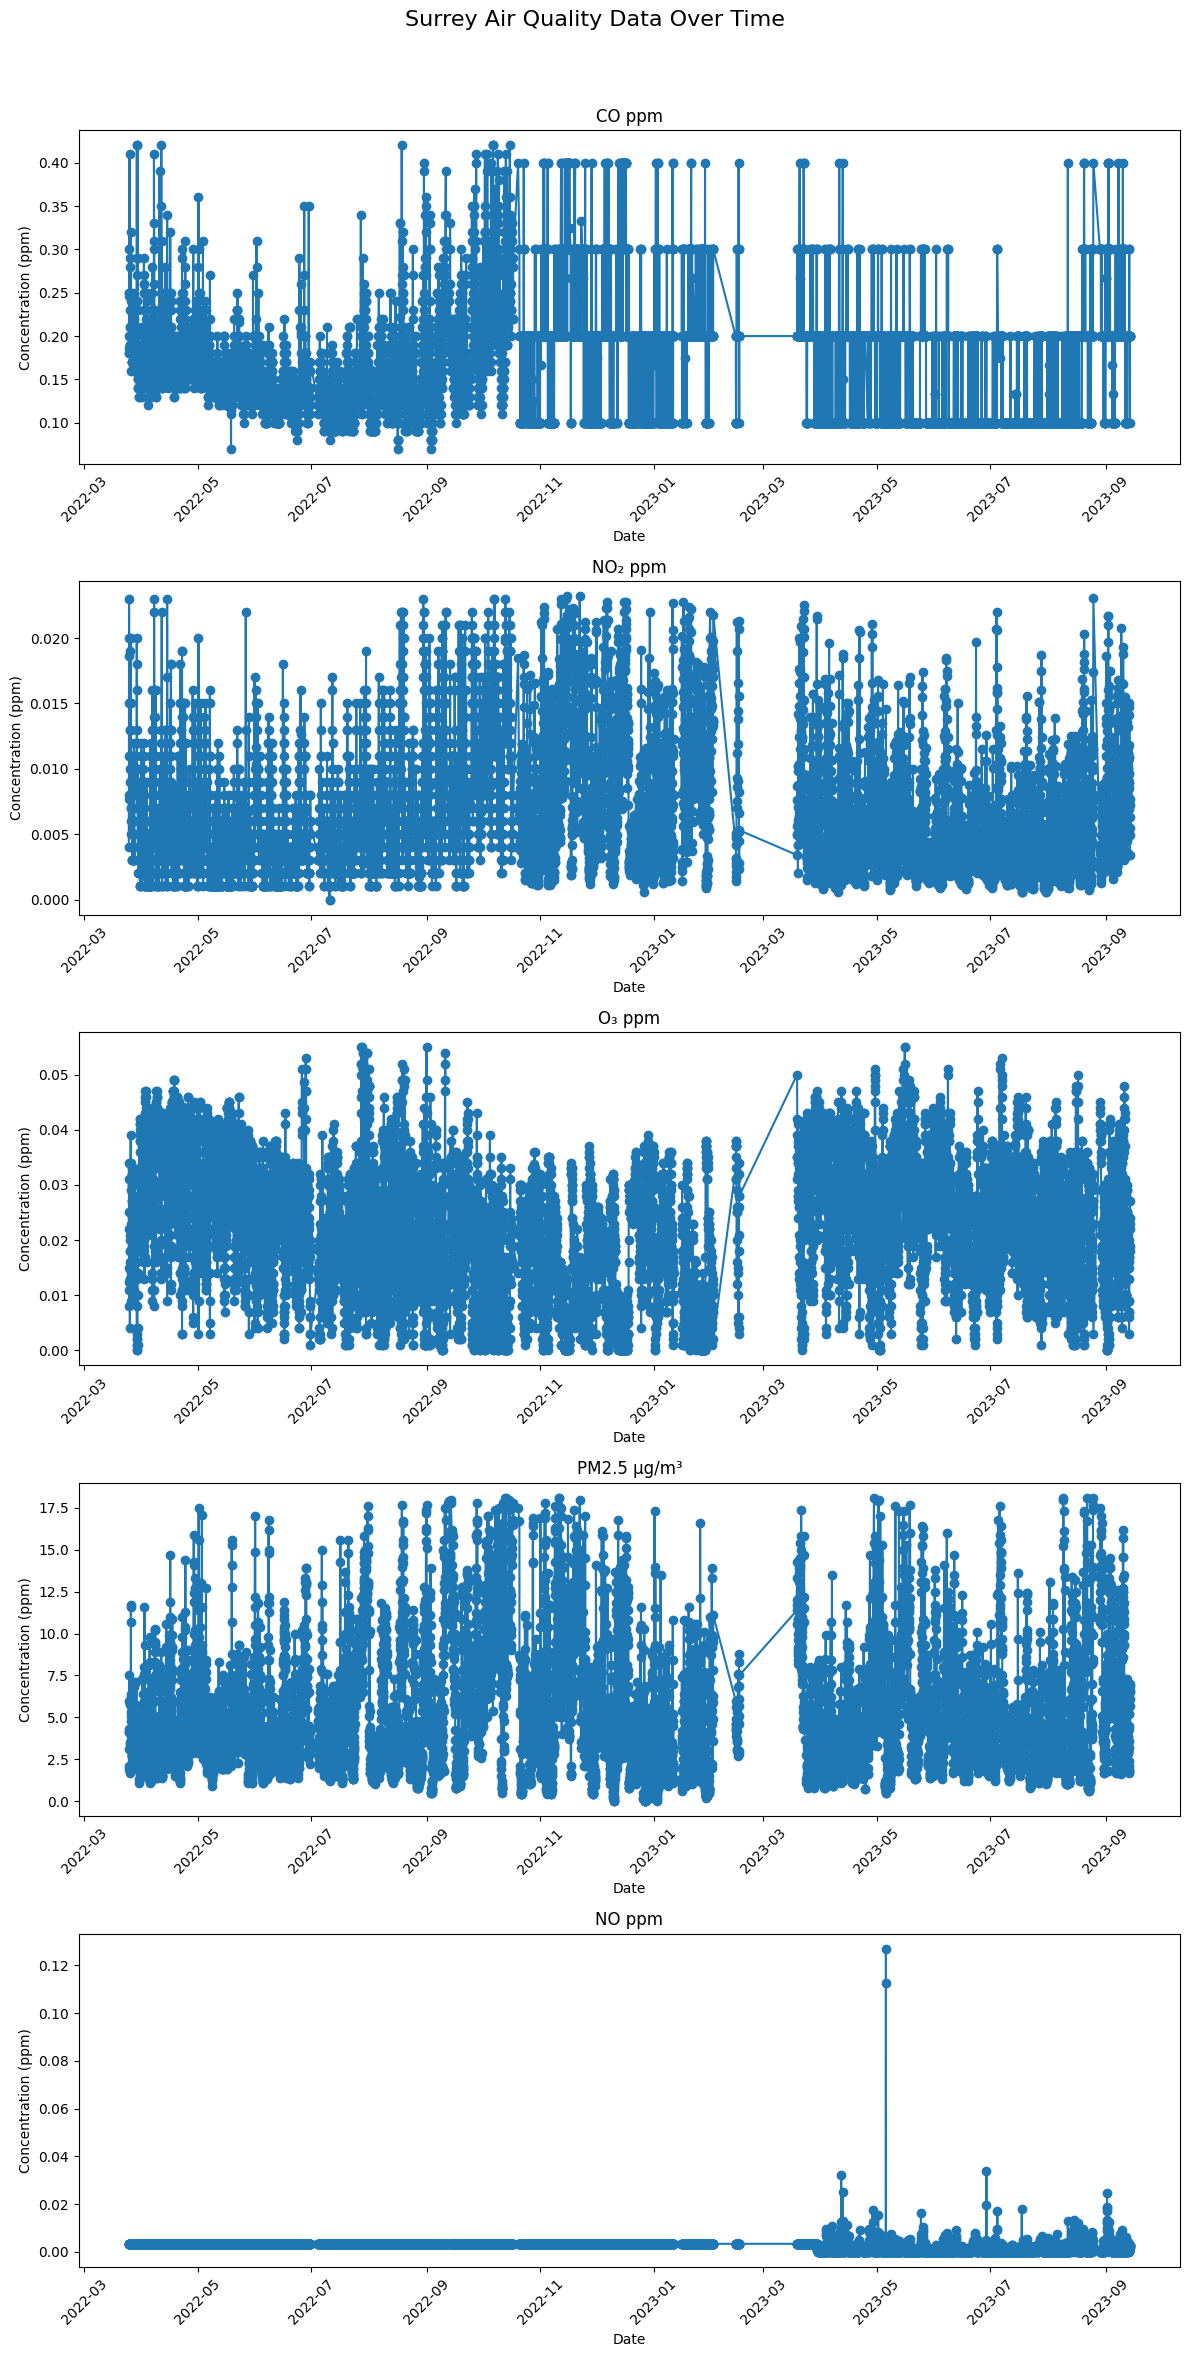

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#Let's plot all the columns in the boston_df grouped but in different plots
columns = ['CO ppm', 'NO₂ ppm', 'O₃ ppm', 'PM2.5 µg/m³', 'NO ppm']


plt.figure(figsize=(12, 8))

#Add a title for all the plots
plt.suptitle('Costa Rica Air Quality Data Over Time', fontsize=16)


plt.plot(costa_rica_df['date'], costa_rica_df['PM2.5 µg/m³'], marker='o')
plt.title('PM2.5 µg/m³')
plt.xlabel('Date')
plt.ylabel('Concentration (ppm)')

plt.show()


plt.figure(figsize=(12, 24))

# Add a title for all the plots
plt.suptitle('Boston Air Quality Data Over Time', fontsize=16)

# Plot each column
for i, column in enumerate(columns, 1):
    plt.subplot(5, 1, i)
    plt.plot(boston_df['date'], boston_df[column], marker='o')
    plt.title(column, fontsize=12, y=1.02)
    plt.xlabel('Date')
    plt.ylabel('Concentration (ppm)')
    plt.xticks(rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#Do the same but for the rest of the cities

#Let's plot all the columns in the annaheim grouped but in different plots

plt.figure(figsize=(12, 24))

#Add a title for all the plots
plt.suptitle('Annaheim Air Quality Data Over Time', fontsize=16)

# Plot each column
for i, column in enumerate(columns, 1):
    plt.subplot(5, 1, i)
    plt.plot(annaheim_df['date'], annaheim_df[column], marker='o')
    plt.title(column)
    plt.xlabel('Date')
    plt.ylabel('Concentration (ppm)')
    plt.xticks(rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#Let's plot all the columns in the annaheim grouped but in different plots

plt.figure(figsize=(12, 24))

#Add a title for all the plots
plt.suptitle('Seattle Air Quality Data Over Time', fontsize=16)

# Plot each column
for i, column in enumerate(columns, 1):
    plt.subplot(5, 1, i)
    plt.plot(seattle_df['date'], seattle_df[column], marker='o')
    plt.title(column)
    plt.xlabel('Date')
    plt.ylabel('Concentration (ppm)')
    plt.xticks(rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Let's plot all the columns in the reseda_df grouped but in different plots

plt.figure(figsize=(12, 24))

# Add a title for all the plots
plt.suptitle('Reseda Air Quality Data Over Time', fontsize=16)

# Plot each column
for i, column in enumerate(columns, 1):
    plt.subplot(5, 1, i)
    plt.plot(reseda_df['date'], reseda_df[column], marker='o')
    plt.title(column)
    plt.xlabel('Date')
    plt.ylabel('Concentration (ppm)')
    plt.xticks(rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Let's plot all the columns in the surrey_df grouped but in different plots

plt.figure(figsize=(12, 24))

# Add a title for all the plots
plt.suptitle('Surrey Air Quality Data Over Time', fontsize=16)

# Plot each column
for i, column in enumerate(columns, 1):
    plt.subplot(5, 1, i)
    plt.plot(surrey_df['date'], surrey_df[column], marker='o')
    plt.title(column)
    plt.xlabel('Date')
    plt.ylabel('Concentration (ppm)')
    plt.xticks(rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In the plots above we can note few things:
* Data from the NO parameter starts being valid in April 2024.
* Since the data is provided hourly we might require a different time unit for better analysis (day, month or year for example)
* There are some points in time were no data is available for most of the parameters. These gaps are aligned in 2023

Let's keep that in the back of our mind so we can revisit it later. Let's start with the correlation analysis

#### Correlation Analysis

In this section we will get the correlation matrixes for each dataset, in order to see what are the possible relations among data.  According to the literature, highly correlated data has a correlation value > 0.7

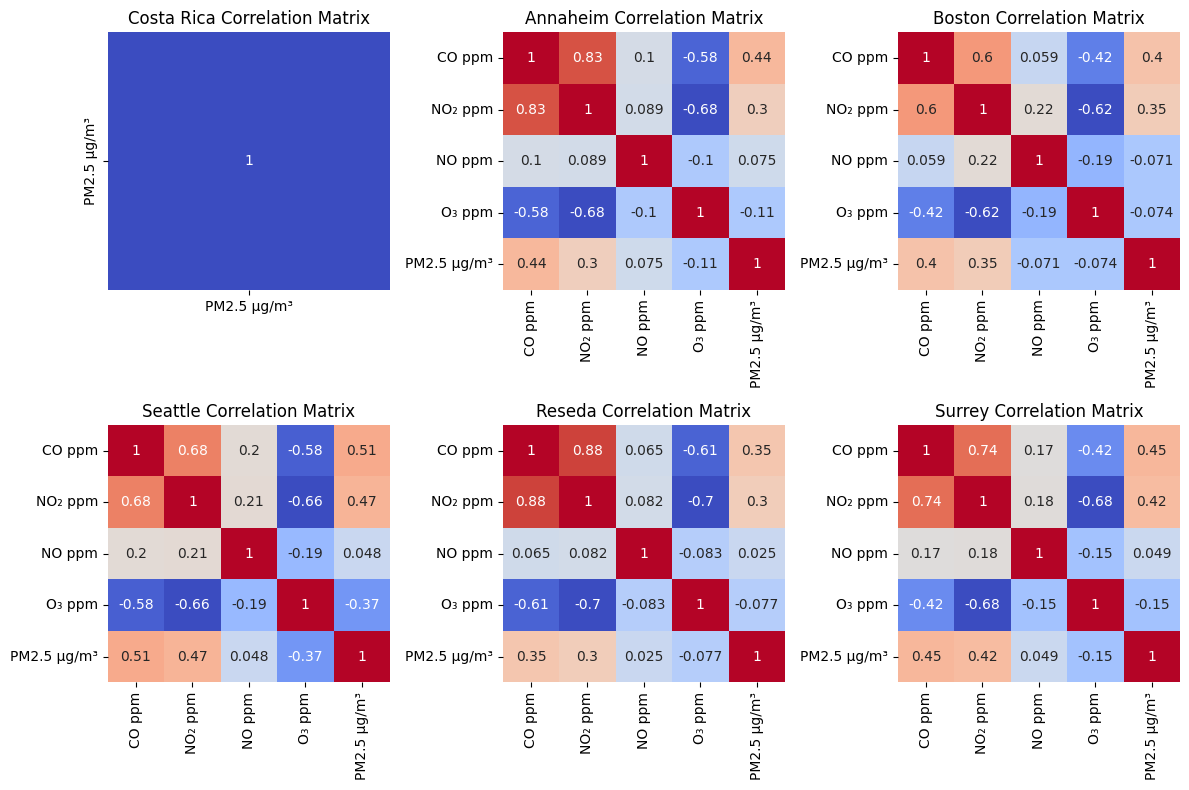

Highly Correlated Pairs for Costa Rica:
[]

Highly Correlated Pairs for Annaheim:
[('NO₂ ppm', 'CO ppm'), ('CO ppm', 'NO₂ ppm')]

Highly Correlated Pairs for Boston:
[]

Highly Correlated Pairs for Seattle:
[]

Highly Correlated Pairs for Reseda:
[('O₃ ppm', 'NO₂ ppm'), ('NO₂ ppm', 'O₃ ppm'), ('NO₂ ppm', 'CO ppm'), ('CO ppm', 'NO₂ ppm')]

Highly Correlated Pairs for Surrey:
[('NO₂ ppm', 'CO ppm'), ('CO ppm', 'NO₂ ppm')]


In [ ]:
# Calculate the correlation matrix for Costa Rica
costa_rica_corr = costa_rica_df.drop('date', axis=1).corr()

# Calculate the correlation matrix for Annaheim
annaheim_corr = annaheim_df.drop('date', axis=1).corr()

# Calculate the correlation matrix for Boston
boston_corr = boston_df.drop('date', axis=1).corr()

# Calculate the correlation matrix for Seattle
seattle_corr = seattle_df.drop('date', axis=1).corr()

# Calculate the correlation matrix for Reseda
reseda_corr = reseda_df.drop('date', axis=1).corr()

# Calculate the correlation matrix for surrey
surrey_corr = surrey_df.drop('date', axis=1).corr()

# Display every correlation matrix using matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size
plt.figure(figsize=(12, 8))

# Plot the correlation matrix for Costa Rica
plt.subplot(2, 3, 1)
sns.heatmap(costa_rica_corr, annot=True, cmap='coolwarm', cbar=False)
plt.title('Costa Rica Correlation Matrix')

# Plot the correlation matrix for Annaheim
plt.subplot(2, 3, 2)
sns.heatmap(annaheim_corr, annot=True, cmap='coolwarm', cbar=False)
plt.title('Annaheim Correlation Matrix')

# Plot the correlation matrix for Boston
plt.subplot(2, 3, 3)
sns.heatmap(boston_corr, annot=True, cmap='coolwarm', cbar=False)
plt.title('Boston Correlation Matrix')

# Plot the correlation matrix for Seattle
plt.subplot(2, 3, 4)
sns.heatmap(seattle_corr, annot=True, cmap='coolwarm', cbar=False)
plt.title('Seattle Correlation Matrix')

# Plot the correlation matrix for Reseda
plt.subplot(2, 3, 5)
sns.heatmap(reseda_corr, annot=True, cmap='coolwarm', cbar=False)
plt.title('Reseda Correlation Matrix')

# Plot the correlation matrix for Surrey
plt.subplot(2, 3, 6)
sns.heatmap(surrey_corr, annot=True, cmap='coolwarm', cbar=False)
plt.title('Surrey Correlation Matrix')


plt.tight_layout()
plt.show()

#Let's study the pairs where abs(corr) > 0.7 High correlation.

# Create a function to get the highly correlated pairs

def get_highly_correlated_pairs(corr_matrix, threshold=0.7):
    # Find the pairs where the absolute correlation value is greater than the threshold
    pairs = (corr_matrix.abs() >= threshold) & (corr_matrix.abs() < 1)

    # Get the indices of the pairs
    pairs = pairs.stack()[pairs.stack()].index.tolist()

    return pairs

# Get the highly correlated pairs for Costa Rica
costa_rica_pairs = list(set(get_highly_correlated_pairs(costa_rica_corr)))

# Get the highly correlated pairs for Annaheim
annaheim_pairs = list(set(get_highly_correlated_pairs(annaheim_corr)))

# Get the highly correlated pairs for Boston
boston_pairs = list(set(get_highly_correlated_pairs(boston_corr)))

# Get the highly correlated pairs for Seattle
seattle_pairs = list(set(get_highly_correlated_pairs(seattle_corr)))

# Get the highly correlated pairs for Reseda
reseda_pairs = list(set(get_highly_correlated_pairs(reseda_corr)))

# Get the highly correlated pairs for Surrey
surrey_pairs = list(set(get_highly_correlated_pairs(surrey_corr)))


# Display the highly correlated pairs
print("Highly Correlated Pairs for Costa Rica:")
print(costa_rica_pairs)

print("\nHighly Correlated Pairs for Annaheim:")
print(annaheim_pairs)

print("\nHighly Correlated Pairs for Boston:")
print(boston_pairs)

print("\nHighly Correlated Pairs for Seattle:")
print(seattle_pairs)

print("\nHighly Correlated Pairs for Reseda:")
print(reseda_pairs)

print("\nHighly Correlated Pairs for Surrey:")
print(surrey_pairs)



We can see that the most interesting correled data are the pairs: (CO, NO2) with positive correlation with and (NO2, O3) being negatively correlated. There are some datasets however, that do not offer these highly correlated pairs. Let's keep in mind that the correlation values we are getting for NO are not valid, as the data was only valid for April 2024 onwards.

Let's try now analysing NO2 and O3 for Reseda, just to see what the data looks like

<ipython-input-11-a2f011dfd312>:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  reseda_df_month['month'] = reseda_df_month['date'].dt.to_period('M')


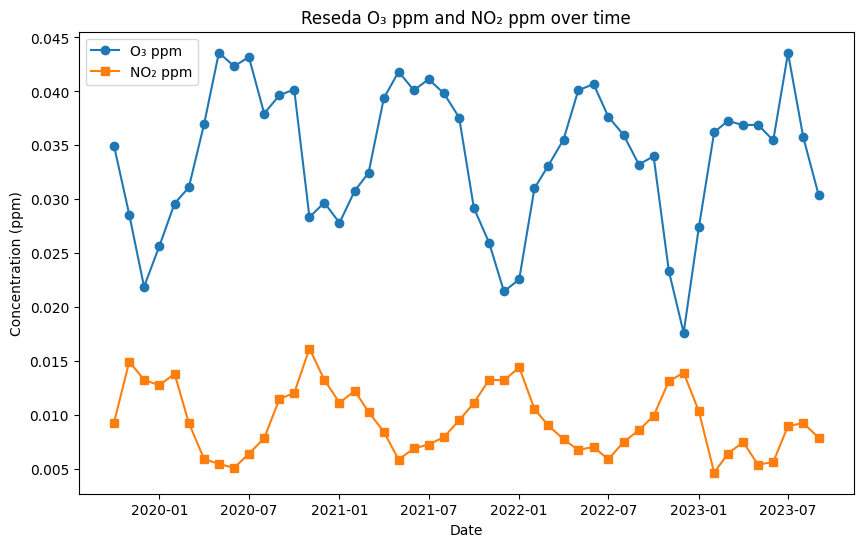

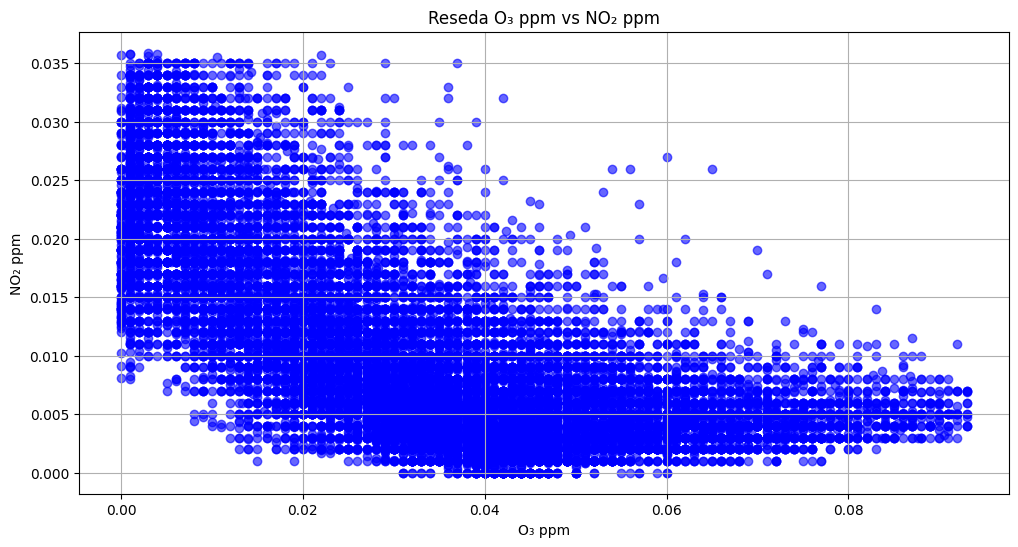

In [ ]:
#Average the reseda over month
reseda_df_month =  reseda_df.copy()

reseda_df_month['date'] = pd.to_datetime(reseda_df_month['date'])
reseda_df_month['month'] = reseda_df_month['date'].dt.to_period('M')
reseda_df_month = reseda_df_month.groupby('month').mean().reset_index()
reseda_df_month['date'] = reseda_df_month['month'].dt.to_timestamp()
reseda_df_month = reseda_df_month.drop('month', axis=1)


plt.figure(figsize=(10, 6))
plt.plot(reseda_df_month['date'], reseda_df_month['O₃ ppm'], label='O₃ ppm', marker='o')
plt.plot(reseda_df_month['date'], reseda_df_month['NO₂ ppm'], label='NO₂ ppm', marker='s')
# Add titles and labels
plt.title('Reseda O₃ ppm and NO₂ ppm over time')
plt.xlabel('Date')
plt.ylabel('Concentration (ppm)')
# Show the legend
plt.legend()

# Display the plot
plt.show()

# Create a scatter plot for O3 ppm vs NO2 ppm
plt.figure(figsize=(12, 6))
plt.scatter(reseda_df['O₃ ppm'], reseda_df['NO₂ ppm'], color='blue', alpha=0.6)
plt.title('Reseda O₃ ppm vs NO₂ ppm')
plt.xlabel('O₃ ppm')
plt.ylabel('NO₂ ppm')
plt.grid(True)
plt.show()


The plot above is actually very interesting, as we can see few things:

* There is a yearly/seasonal behavior on both graphs, the minum and maximum of the data are occurrying roughly with a period of 1 year.
* O3 and NO3 seem to follow the inverse linear relationship predicted by the correlation matrix.
* The scatter plot shows that in fact the lower the O3 the higher the NO2, and vice-versa.
* Visually speaking, the scatter plot seems to have some right skewedness, applying a logarthmic transformation can help aleviate that effect, but it is not considered necessary because the data trend is already clear in this scenario.

To visualize the effect of the O3 and NO2 better, let's min-max scale the dataframes and plot this again

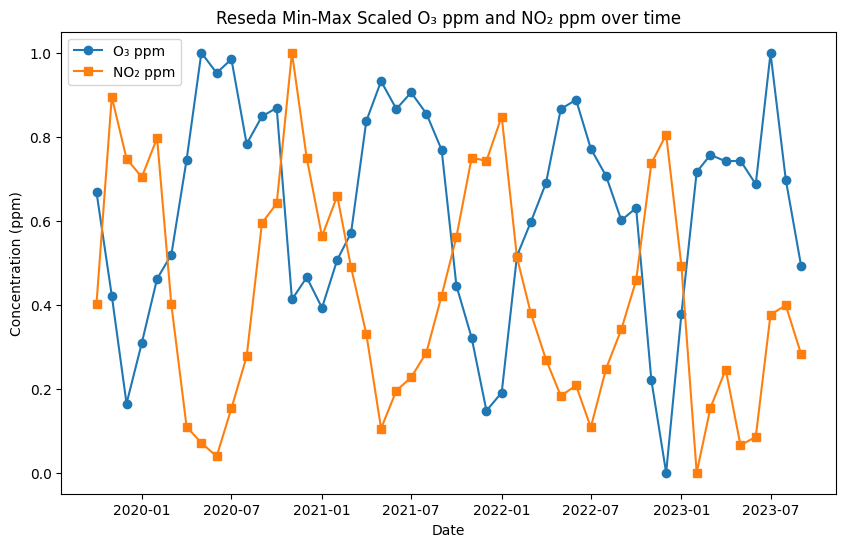

In [ ]:
#Min-max scale reseda month
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Select the columns to scale
columns_to_scale = ['NO₂ ppm', 'O₃ ppm', 'CO ppm', 'PM2.5 µg/m³']

# Scale the selected columns

reseda_df_month_scaled = reseda_df_month.copy()

reseda_df_month_scaled[columns_to_scale] = scaler.fit_transform(reseda_df_month[columns_to_scale])

# Plot the scaled data as before
plt.figure(figsize=(10, 6))
plt.plot(reseda_df_month_scaled['date'], reseda_df_month_scaled['O₃ ppm'], label='O₃ ppm', marker='o')
plt.plot(reseda_df_month_scaled['date'], reseda_df_month_scaled['NO₂ ppm'], label='NO₂ ppm', marker='s')
# Add titles and labels
plt.title('Reseda Min-Max Scaled O₃ ppm and NO₂ ppm over time')
plt.xlabel('Date')
plt.ylabel('Concentration (ppm)')
# Show the legend
plt.legend()

# Display the plot
plt.show()

A similar process can be followed for the rest of correlated data. In the case of positively correlated data, max and mins should happen in similar epochs of time.

Until now we have only ignored NO. But let's try to also check if there is some correlation between parameters when that information is accurate (April 2023 onwards)

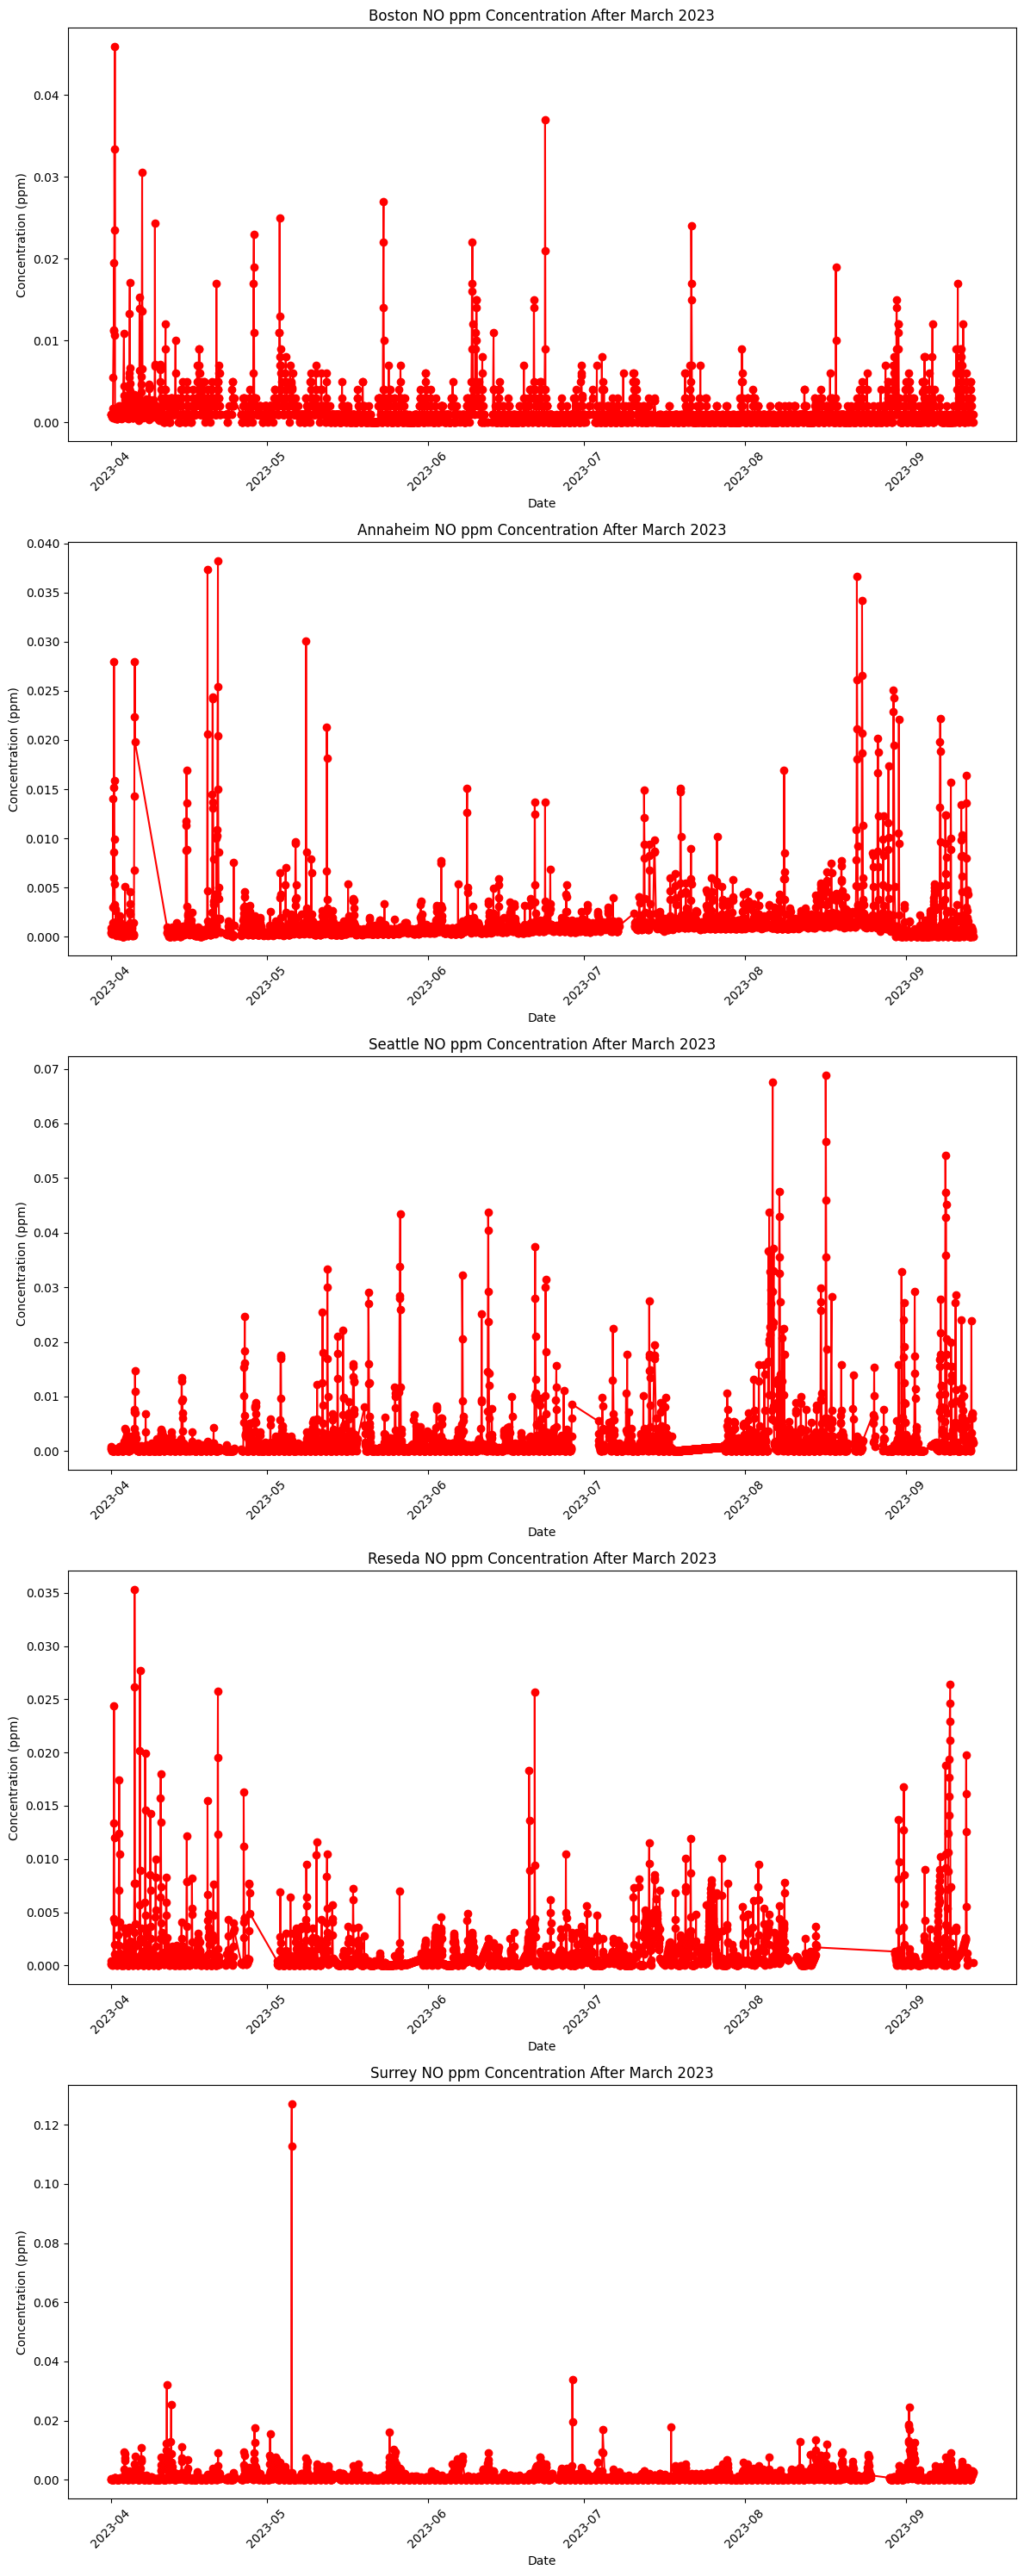

In [ ]:
# Get the data for boston where date > 2023-03
boston_df_2023 = boston_df[boston_df['date'] > '2023-04']

# Plot boston_df_2023 NO data
fig, axs = plt.subplots(5, 1, figsize=(12, 30))

axs[0].plot(boston_df_2023['date'], boston_df_2023['NO ppm'], marker='o', color='r')
axs[0].set_title('Boston NO ppm Concentration After March 2023')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Concentration (ppm)')
axs[0].tick_params(axis='x', rotation=45)

# Get the data for annaheim where date > 2023-03
annaheim_df_2023 = annaheim_df[annaheim_df['date'] > '2023-04']

# Plot annaheim_df_2023 NO data
axs[1].plot(annaheim_df_2023['date'], annaheim_df_2023['NO ppm'], marker='o', color='r')
axs[1].set_title('Annaheim NO ppm Concentration After March 2023')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Concentration (ppm)')
axs[1].tick_params(axis='x', rotation=45)

# Get the data for seattle where date > 2023-03
seattle_df_2023 = seattle_df[seattle_df['date'] > '2023-04']

# Plot seattle_df_2023 NO data
axs[2].plot(seattle_df_2023['date'], seattle_df_2023['NO ppm'], marker='o', color='r')
axs[2].set_title('Seattle NO ppm Concentration After March 2023')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Concentration (ppm)')
axs[2].tick_params(axis='x', rotation=45)

# Get the data for reseda where date > 2023-03
reseda_df_2023 = reseda_df[reseda_df['date'] > '2023-04']

# Plot reseda_df_2023 NO data
axs[3].plot(reseda_df_2023['date'], reseda_df_2023['NO ppm'], marker='o', color='r')
axs[3].set_title('Reseda NO ppm Concentration After March 2023')
axs[3].set_xlabel('Date')
axs[3].set_ylabel('Concentration (ppm)')
axs[3].tick_params(axis='x', rotation=45)

# Get the data for surrey where date > 2023-03
surrey_df_2023 = surrey_df[surrey_df['date'] > '2023-04']

# Plot surrey_df_2023 NO data
axs[4].plot(surrey_df_2023['date'], surrey_df_2023['NO ppm'], marker='o', color='r')
axs[4].set_title('Surrey NO ppm Concentration After March 2023')
axs[4].set_xlabel('Date')
axs[4].set_ylabel('Concentration (ppm)')
axs[4].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Let's get the correlation matrixes:


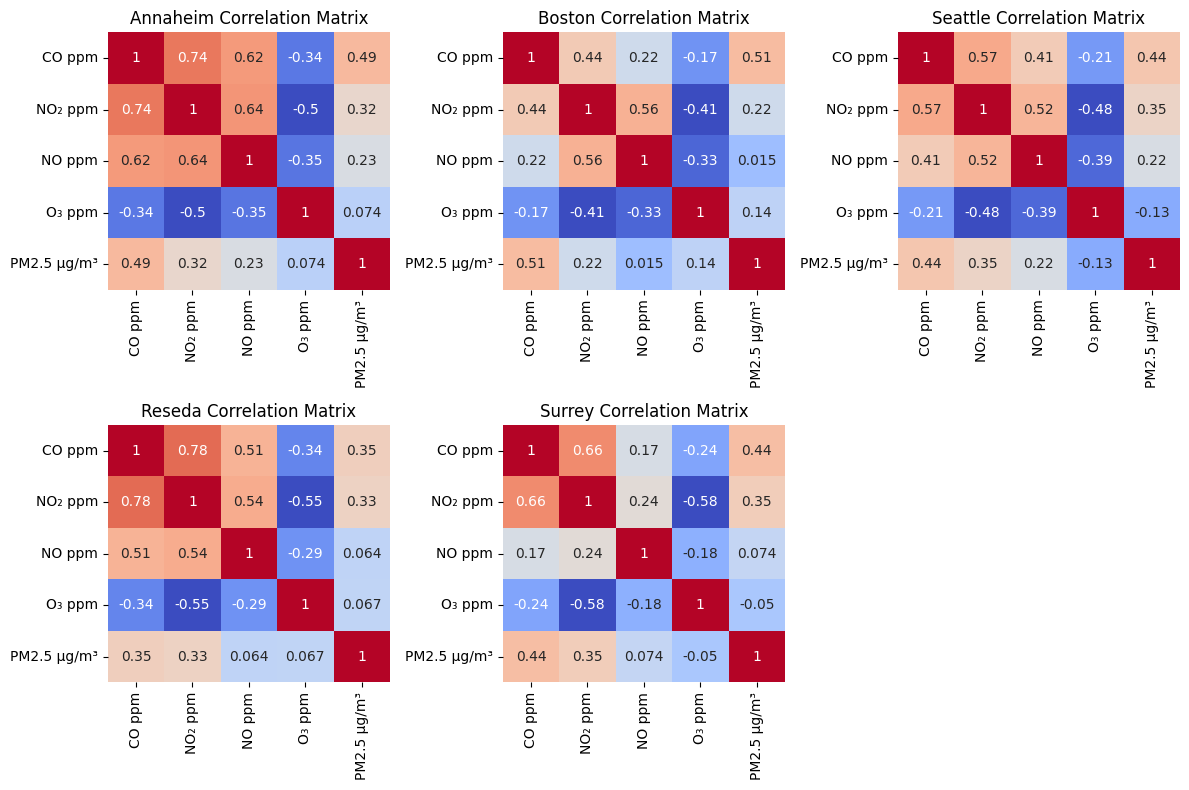


Highly Correlated Pairs for Annaheim:
[('NO₂ ppm', 'CO ppm'), ('CO ppm', 'NO₂ ppm')]

Highly Correlated Pairs for Boston:
[]

Highly Correlated Pairs for Seattle:
[]

Highly Correlated Pairs for Reseda:
[('NO₂ ppm', 'CO ppm'), ('CO ppm', 'NO₂ ppm')]

Highly Correlated Pairs for Surrey:
[]


In [ ]:
# Calculate the correlation matrix for Annaheim
annaheim_corr_2023 = annaheim_df_2023.drop('date', axis=1).corr()

# Calculate the correlation matrix for Boston
boston_corr_2023 = boston_df_2023.drop('date', axis=1).corr()

# Calculate the correlation matrix for Seattle
seattle_corr_2023 = seattle_df_2023.drop('date', axis=1).corr()

# Calculate the correlation matrix for Reseda
reseda_corr_2023 = reseda_df_2023.drop('date', axis=1).corr()

# Calculate the correlation matrix for surrey
surrey_corr_2023 = surrey_df_2023.drop('date', axis=1).corr()

# Display every correlation matrix using matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size
plt.figure(figsize=(12, 8))

# Plot the correlation matrix for Annaheim
plt.subplot(2, 3, 1)
sns.heatmap(annaheim_corr_2023, annot=True, cmap='coolwarm', cbar=False)
plt.title('Annaheim Correlation Matrix')

# Plot the correlation matrix for Boston
plt.subplot(2, 3, 2)
sns.heatmap(boston_corr_2023, annot=True, cmap='coolwarm', cbar=False)
plt.title('Boston Correlation Matrix')

# Plot the correlation matrix for Seattle
plt.subplot(2, 3, 3)
sns.heatmap(seattle_corr_2023, annot=True, cmap='coolwarm', cbar=False)
plt.title('Seattle Correlation Matrix')

# Plot the correlation matrix for Reseda
plt.subplot(2, 3, 4)
sns.heatmap(reseda_corr_2023, annot=True, cmap='coolwarm', cbar=False)
plt.title('Reseda Correlation Matrix')

# Plot the correlation matrix for Surrey
plt.subplot(2, 3, 5)
sns.heatmap(surrey_corr_2023, annot=True, cmap='coolwarm', cbar=False)
plt.title('Surrey Correlation Matrix')


plt.tight_layout()
plt.show()

#Let's study the pairs where abs(corr) > 0.7 High correlation.

# Create a function to get the highly correlated pairs

def get_highly_correlated_pairs(corr_matrix, threshold=0.7):
    # Find the pairs where the absolute correlation value is greater than the threshold
    pairs = (corr_matrix.abs() >= threshold) & (corr_matrix.abs() < 1)

    # Get the indices of the pairs
    pairs = pairs.stack()[pairs.stack()].index.tolist()

    return pairs


# Get the highly correlated pairs for Annaheim
annaheim_pairs = list(set(get_highly_correlated_pairs(annaheim_corr_2023)))

# Get the highly correlated pairs for Boston
boston_pairs = list(set(get_highly_correlated_pairs(boston_corr_2023)))

# Get the highly correlated pairs for Seattle
seattle_pairs = list(set(get_highly_correlated_pairs(seattle_corr_2023)))

# Get the highly correlated pairs for Reseda
reseda_pairs = list(set(get_highly_correlated_pairs(reseda_corr_2023)))

# Get the highly correlated pairs for Surrey
surrey_pairs = list(set(get_highly_correlated_pairs(surrey_corr_2023)))


# Display the highly correlated pairs

print("\nHighly Correlated Pairs for Annaheim:")
print(annaheim_pairs)

print("\nHighly Correlated Pairs for Boston:")
print(boston_pairs)

print("\nHighly Correlated Pairs for Seattle:")
print(seattle_pairs)

print("\nHighly Correlated Pairs for Reseda:")
print(reseda_pairs)

print("\nHighly Correlated Pairs for Surrey:")
print(surrey_pairs)

We can see that in this case the values of correlation with NO got higher, but none are beating the threshold of 0.7 to say there's highly correlated data, so we will not be persuing anything with NO anymore

#### Time Series Analysis

Let's go back to some more time series analysis. First, having hourly values seemed a bit messy to read, let's try to plot by day

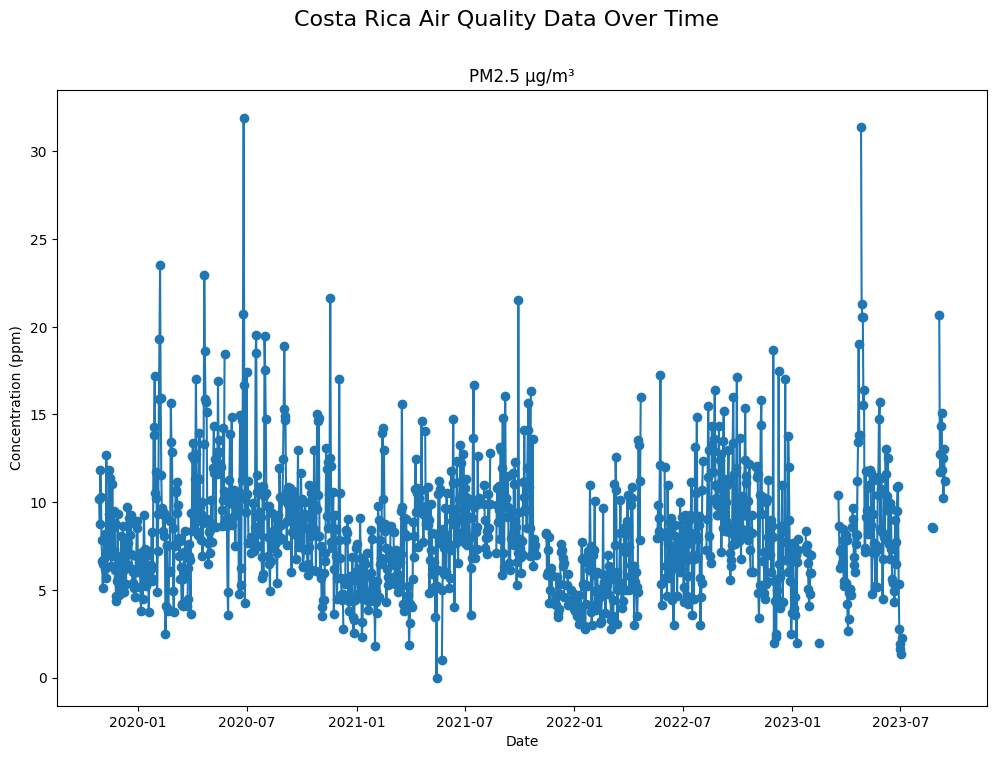

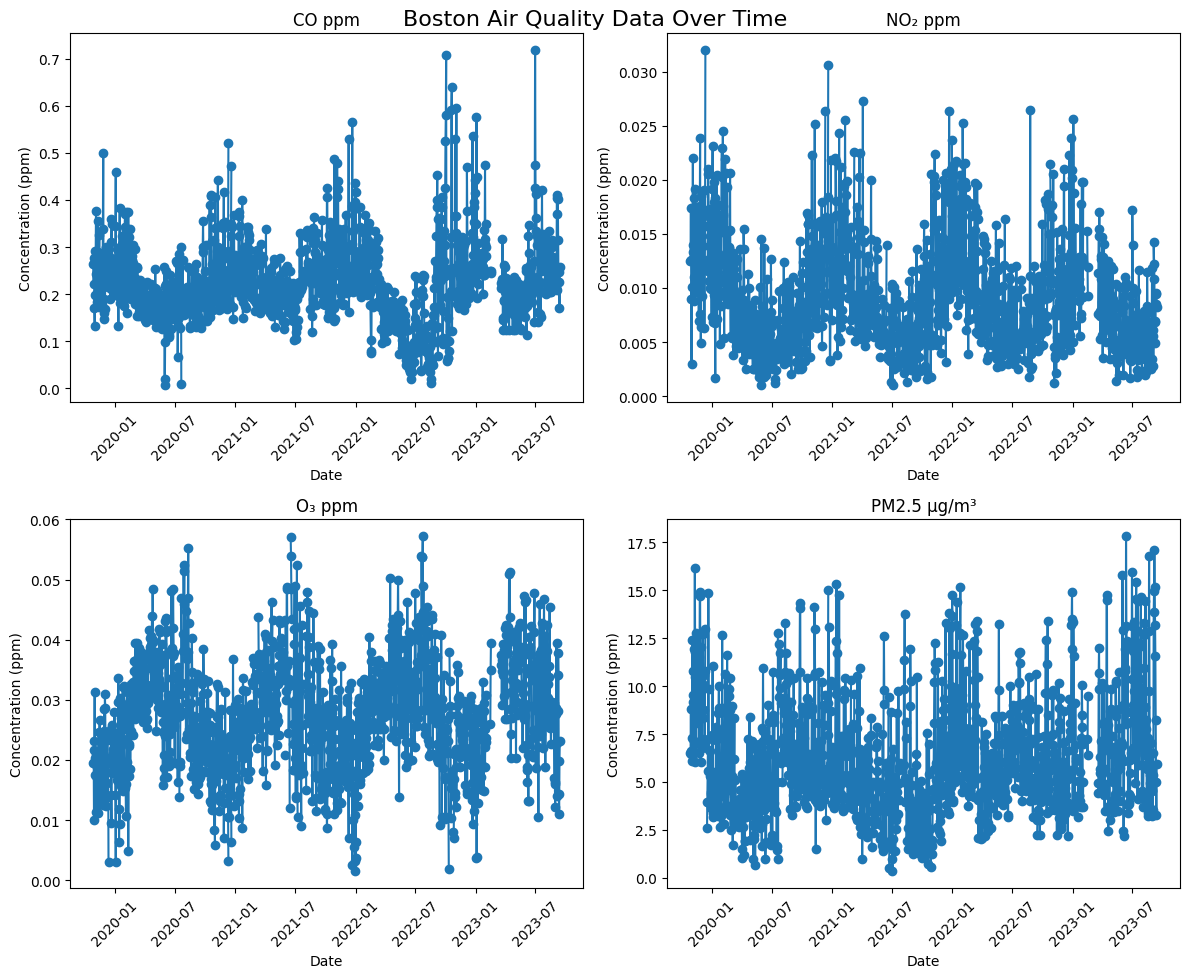

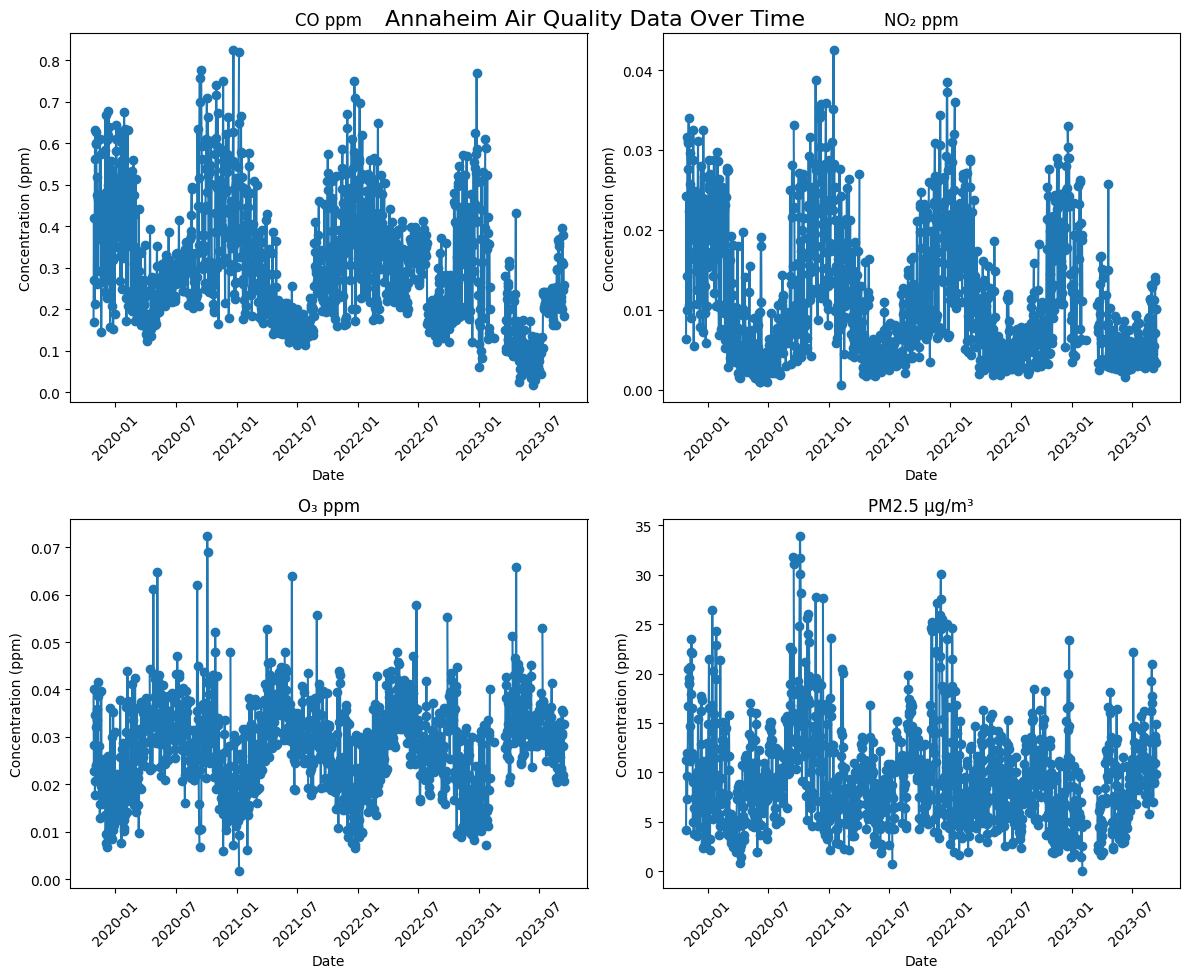

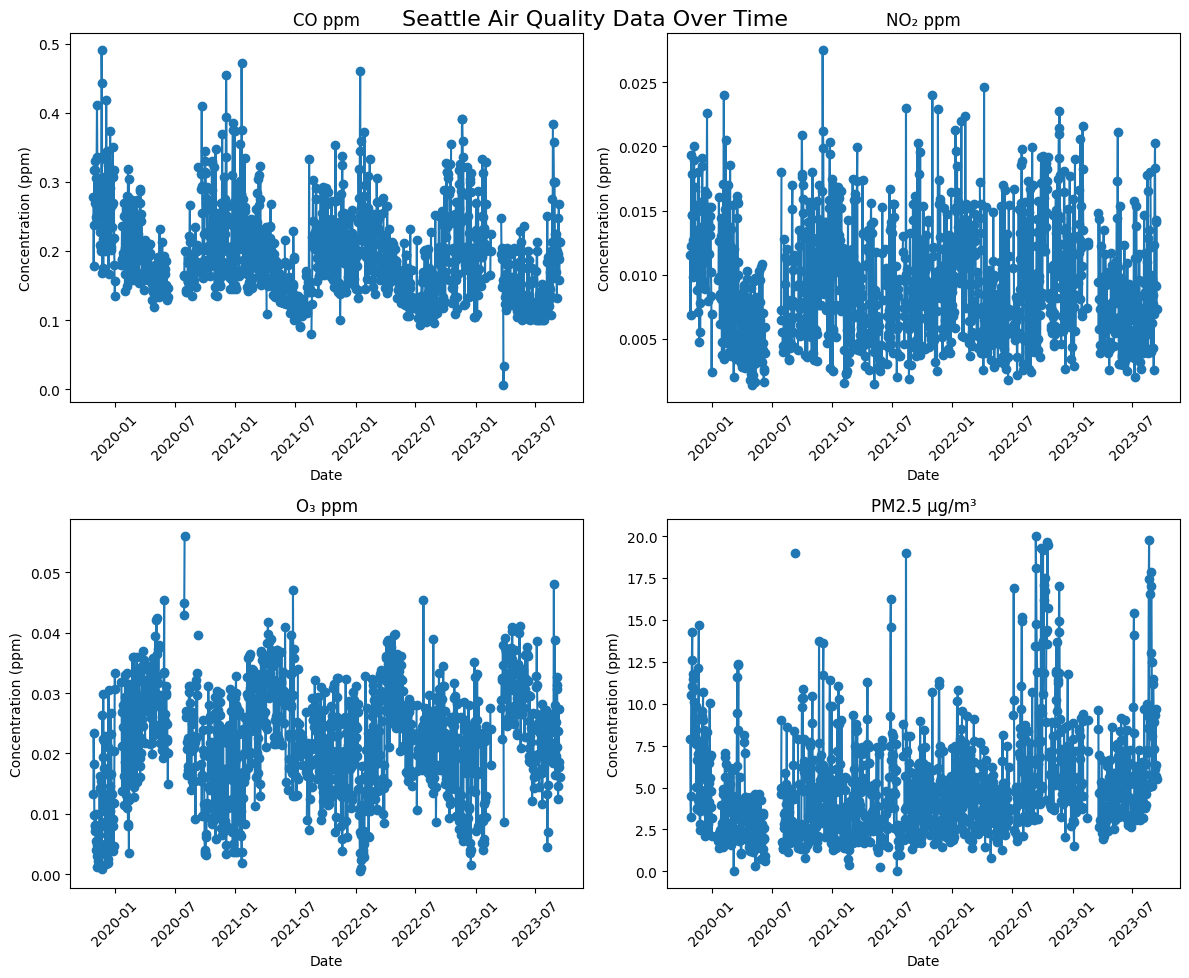

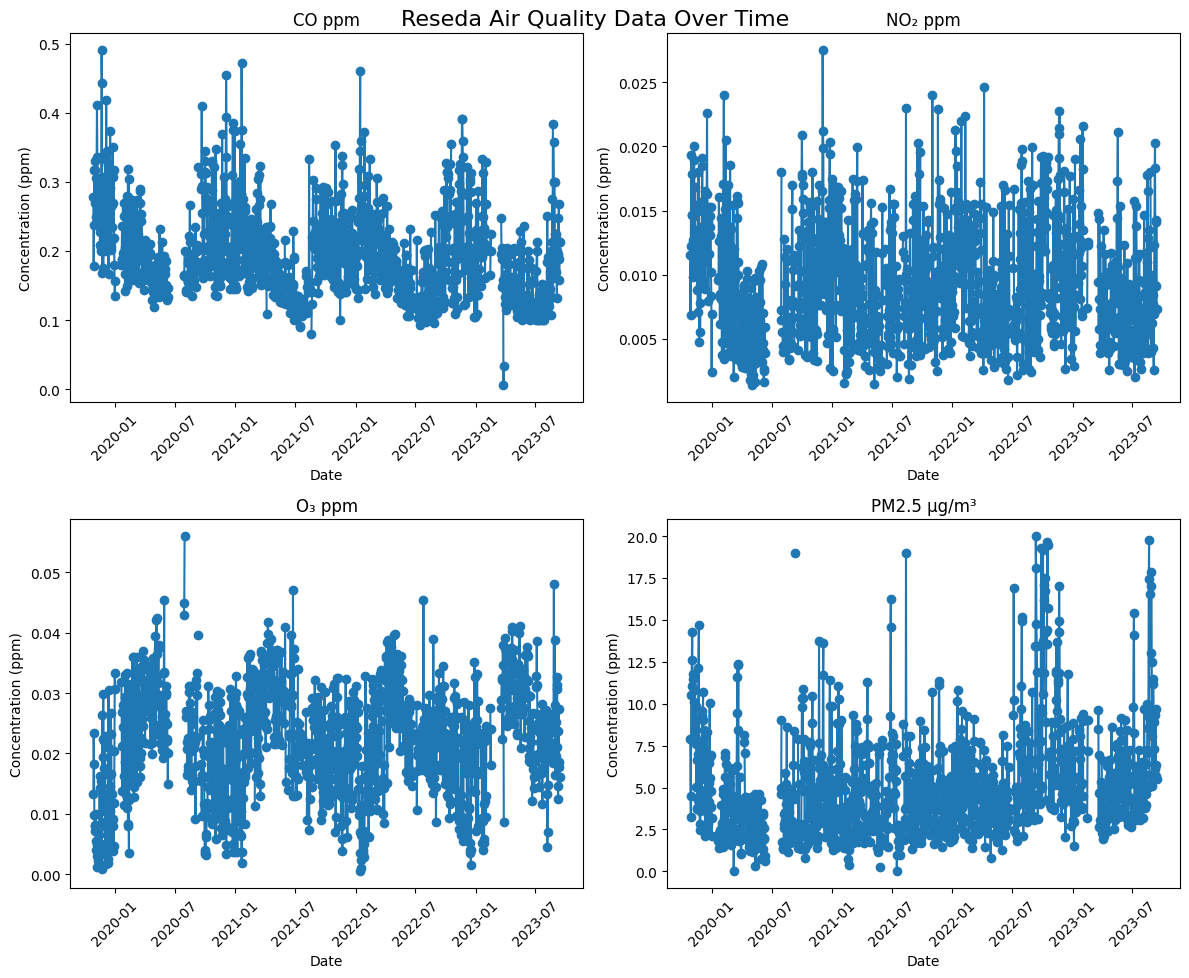

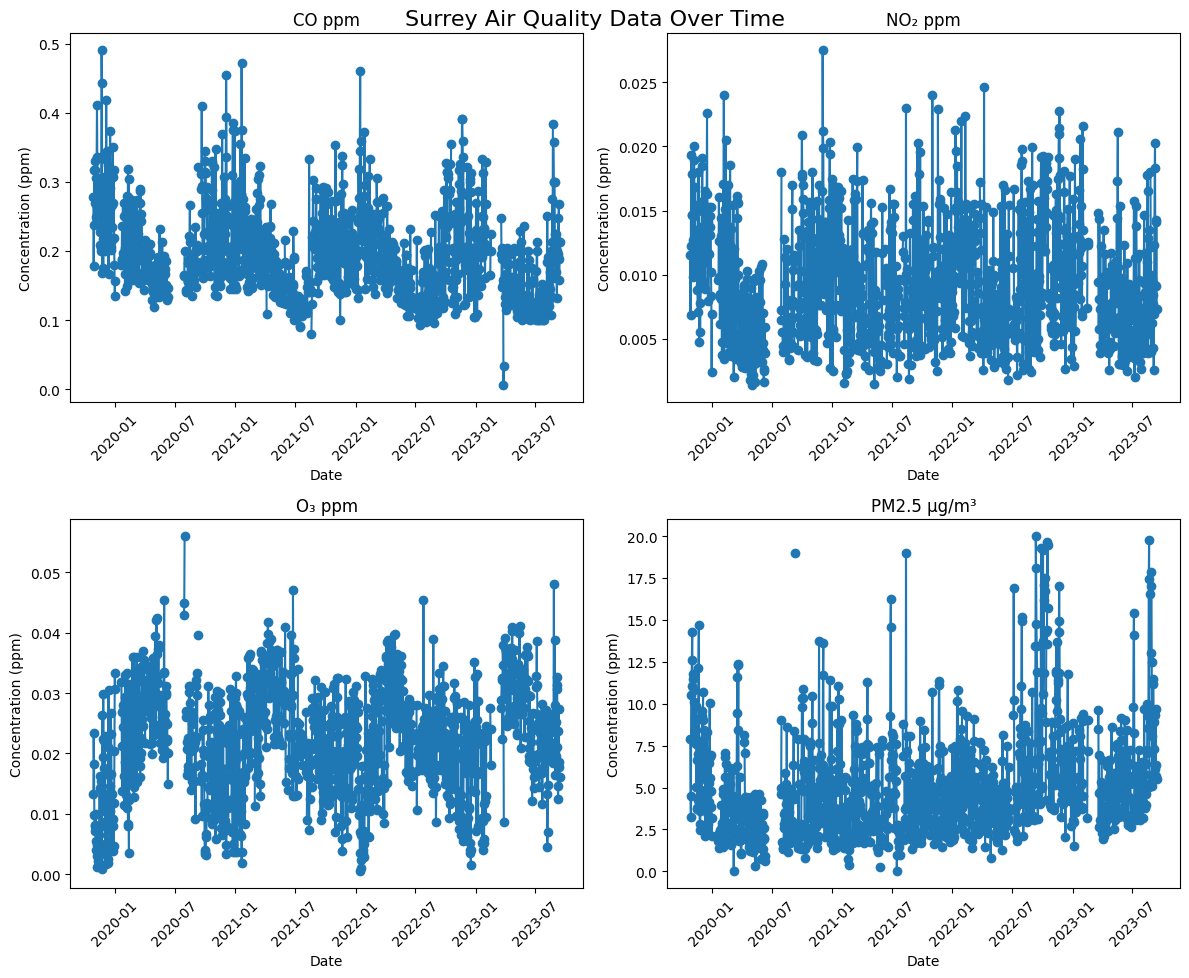

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#Let's plot all the columns in the boston_df grouped but in different plots
columns = ['CO ppm', 'NO₂ ppm', 'O₃ ppm', 'PM2.5 µg/m³']

boston_df_daily = boston_df.resample('D', on='date').mean()
annaheim_df_daily = annaheim_df.resample('D', on='date').mean()
costa_rica_df_daily = costa_rica_df.resample('D', on='date').mean()
seattle_df_daily = seattle_df.resample('D', on='date').mean()
reseda_df_daily = reseda_df.resample('D', on='date').mean()
surrey_df_daily = surrey_df.resample('D', on='date').mean()

plt.figure(figsize=(12, 8))

#Add a title for all the plots
plt.suptitle('Costa Rica Air Quality Data Over Time', fontsize=16)


plt.plot(costa_rica_df_daily.index, costa_rica_df_daily['PM2.5 µg/m³'], marker='o')
plt.title('PM2.5 µg/m³')
plt.xlabel('Date')
plt.ylabel('Concentration (ppm)')

plt.show()


plt.figure(figsize=(12, 24))

#Add a title for all the plots
plt.suptitle('Boston Air Quality Data Over Time', fontsize=16)

# Plot each column
for i, column in enumerate(columns, 1):
    plt.subplot(5, 2, i)
    plt.plot(boston_df_daily.index, boston_df_daily[column], marker='o')
    plt.title(column)
    plt.xlabel('Date')
    plt.ylabel('Concentration (ppm)')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#Do the same but for the rest of the cities

#Let's plot all the columns in the annaheim grouped but in different plots

plt.figure(figsize=(12, 24))

#Add a title for all the plots
plt.suptitle('Annaheim Air Quality Data Over Time', fontsize=16)

# Plot each column
for i, column in enumerate(columns, 1):
    plt.subplot(5, 2, i)
    plt.plot(annaheim_df_daily.index, annaheim_df_daily[column], marker='o')
    plt.title(column)
    plt.xlabel('Date')
    plt.ylabel('Concentration (ppm)')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#Let's plot all the columns in the annaheim grouped but in different plots

plt.figure(figsize=(12, 24))

#Add a title for all the plots
plt.suptitle('Seattle Air Quality Data Over Time', fontsize=16)

# Plot each column
for i, column in enumerate(columns, 1):
    plt.subplot(5, 2, i)
    plt.plot(seattle_df_daily.index, seattle_df_daily[column], marker='o')
    plt.title(column)
    plt.xlabel('Date')
    plt.ylabel('Concentration (ppm)')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Let's plot all the columns in the reseda_df grouped but in different plots

plt.figure(figsize=(12, 24))

# Add a title for all the plots
plt.suptitle('Reseda Air Quality Data Over Time', fontsize=16)

# Plot each column
for i, column in enumerate(columns, 1):
    plt.subplot(5, 2, i)
    plt.plot(seattle_df_daily.index, seattle_df_daily[column], marker='o')
    plt.title(column)
    plt.xlabel('Date')
    plt.ylabel('Concentration (ppm)')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Let's plot all the columns in the surrey_df grouped but in different plots

plt.figure(figsize=(12, 24))

# Add a title for all the plots
plt.suptitle('Surrey Air Quality Data Over Time', fontsize=16)

# Plot each column
for i, column in enumerate(columns, 1):
    plt.subplot(5, 2, i)
    plt.plot(seattle_df_daily.index, seattle_df_daily[column], marker='o')
    plt.title(column)
    plt.xlabel('Date')
    plt.ylabel('Concentration (ppm)')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Data still looks messy. Let's try agregating it by month instead

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1417 entries, 2019-10-28 00:00:00+00:00 to 2023-09-13 00:00:00+00:00
Freq: D
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PM2.5 µg/m³  1190 non-null   float64
dtypes: float64(1)
memory usage: 22.1 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24868 entries, 0 to 24867
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   date         24868 non-null  datetime64[ns, UTC]
 1   PM2.5 µg/m³  24868 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(1)
memory usage: 388.7 KB


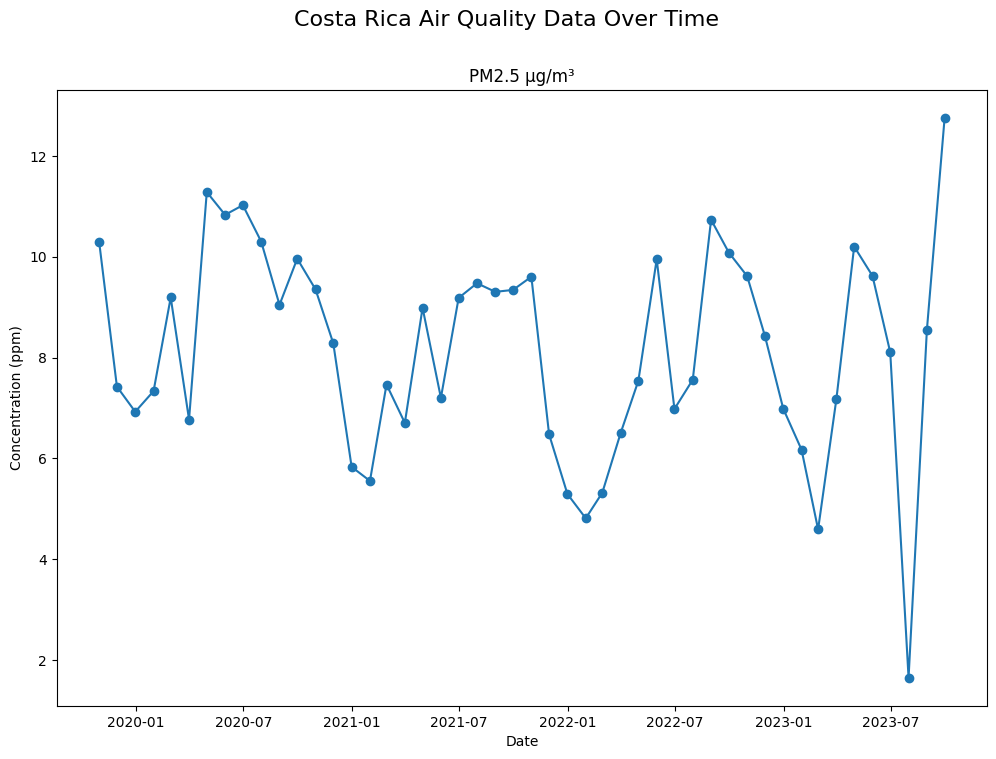

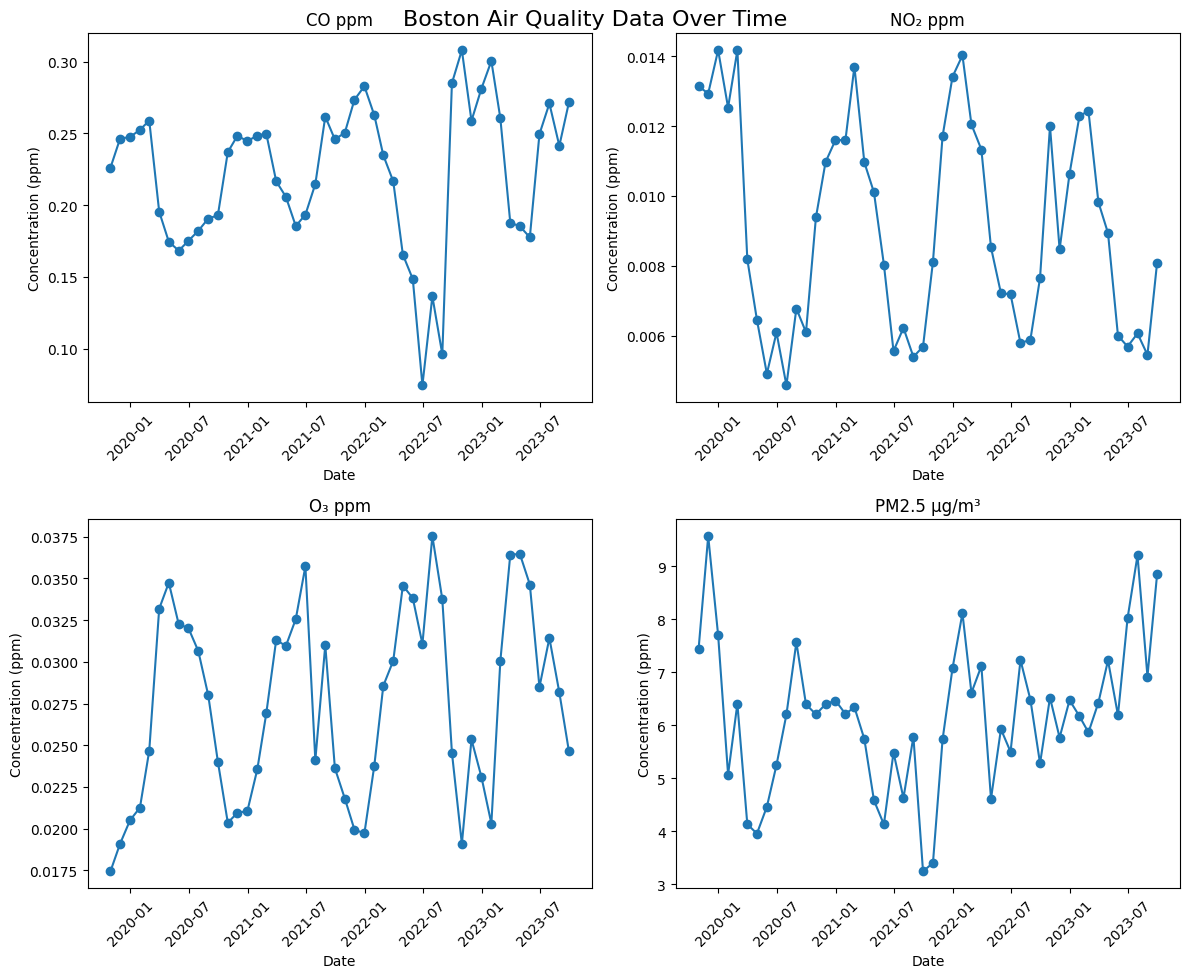

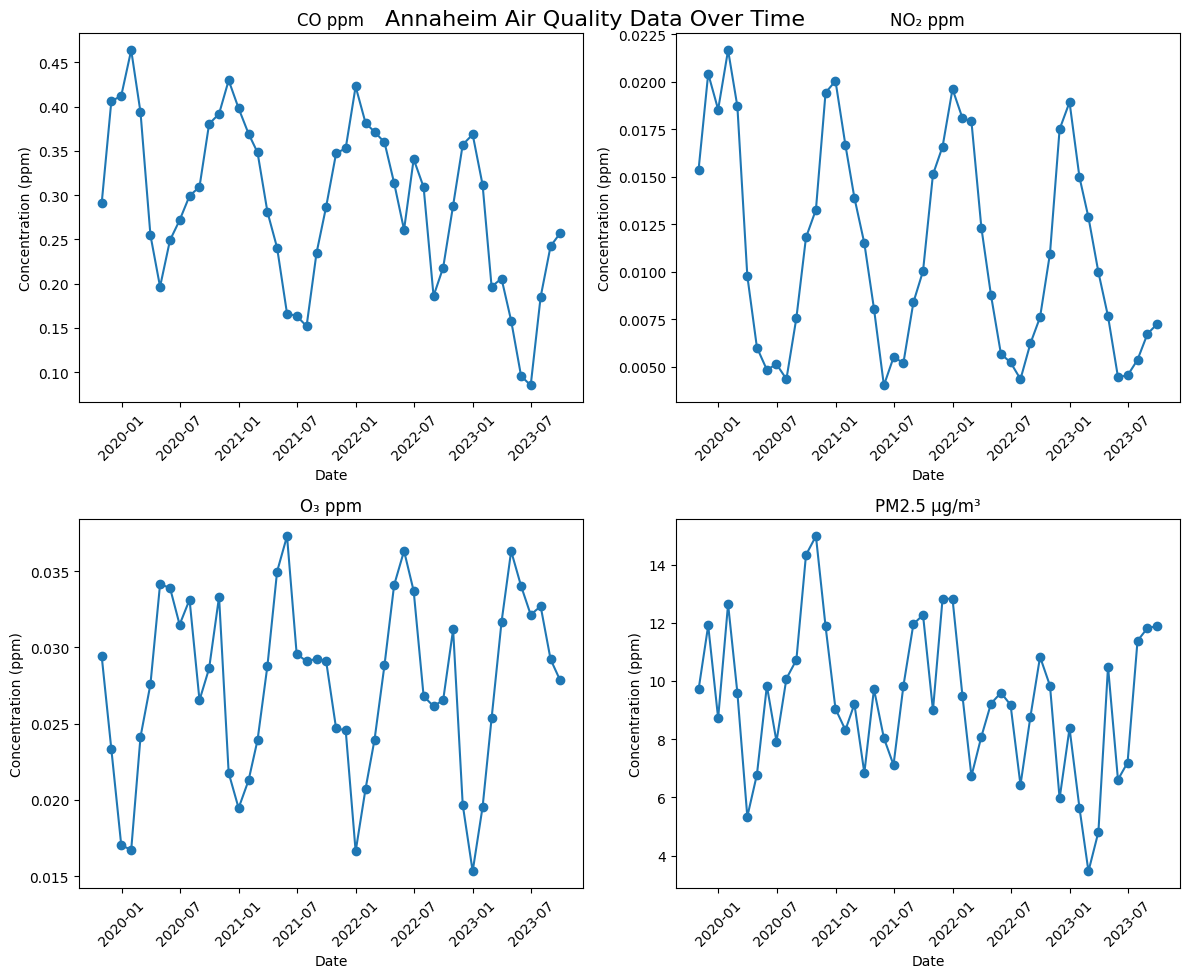

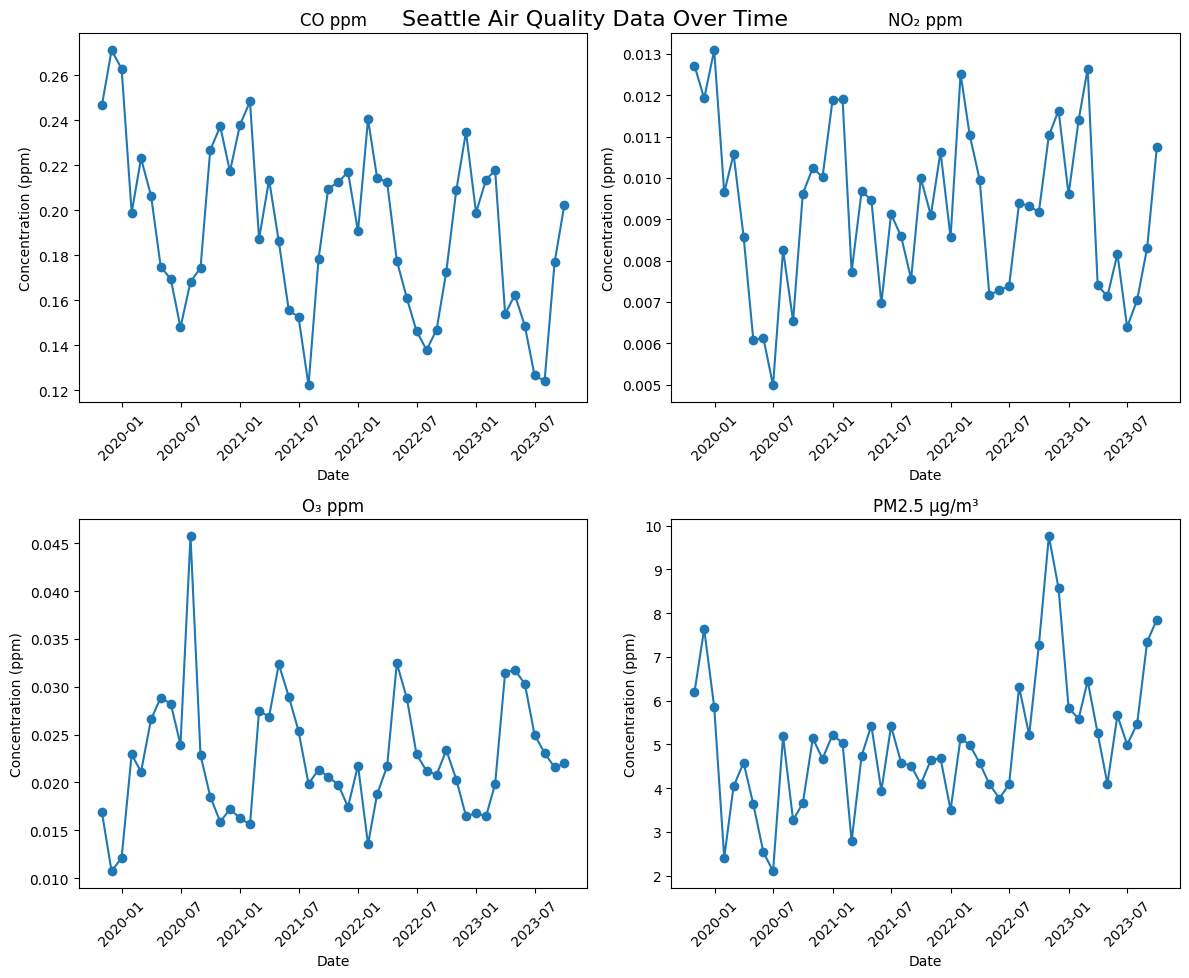

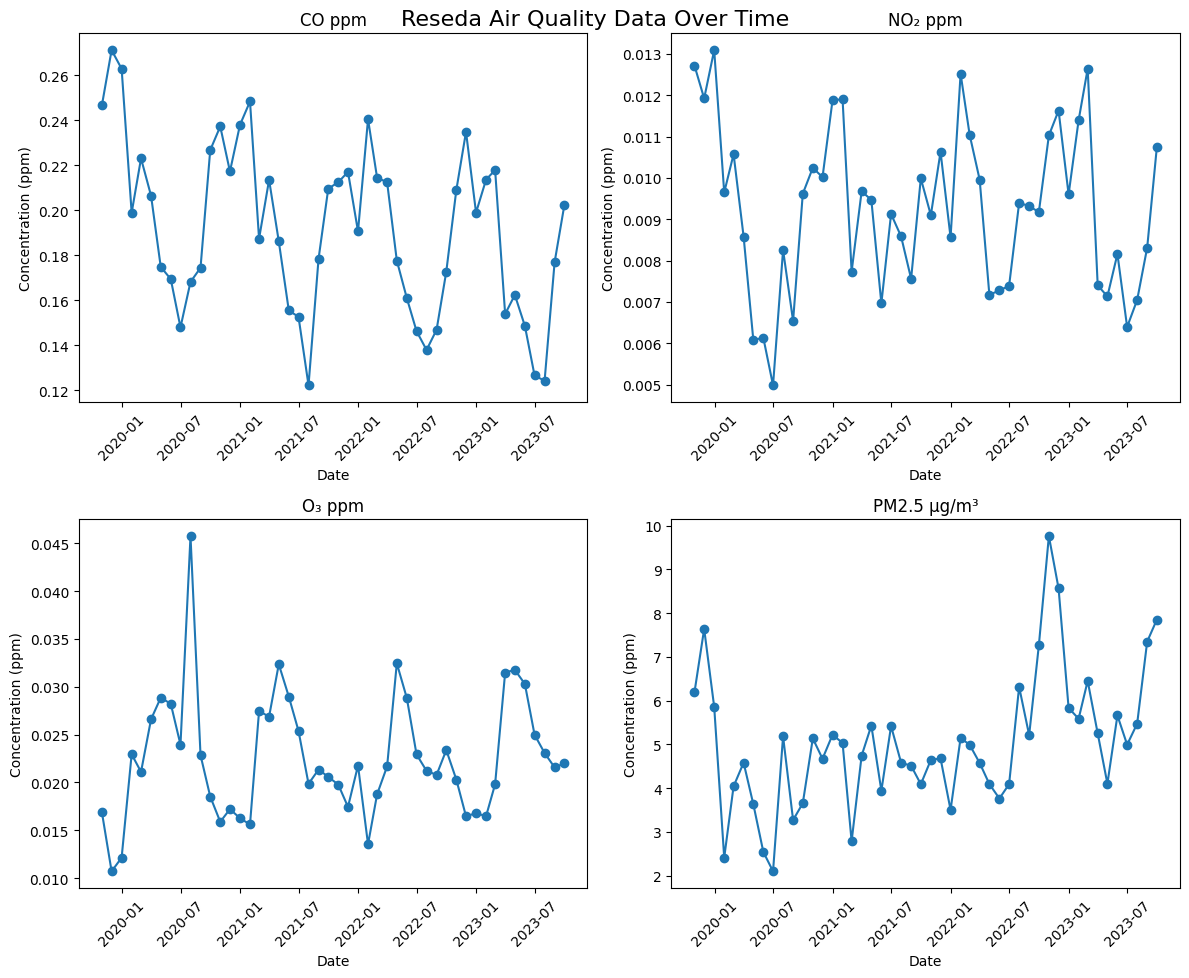

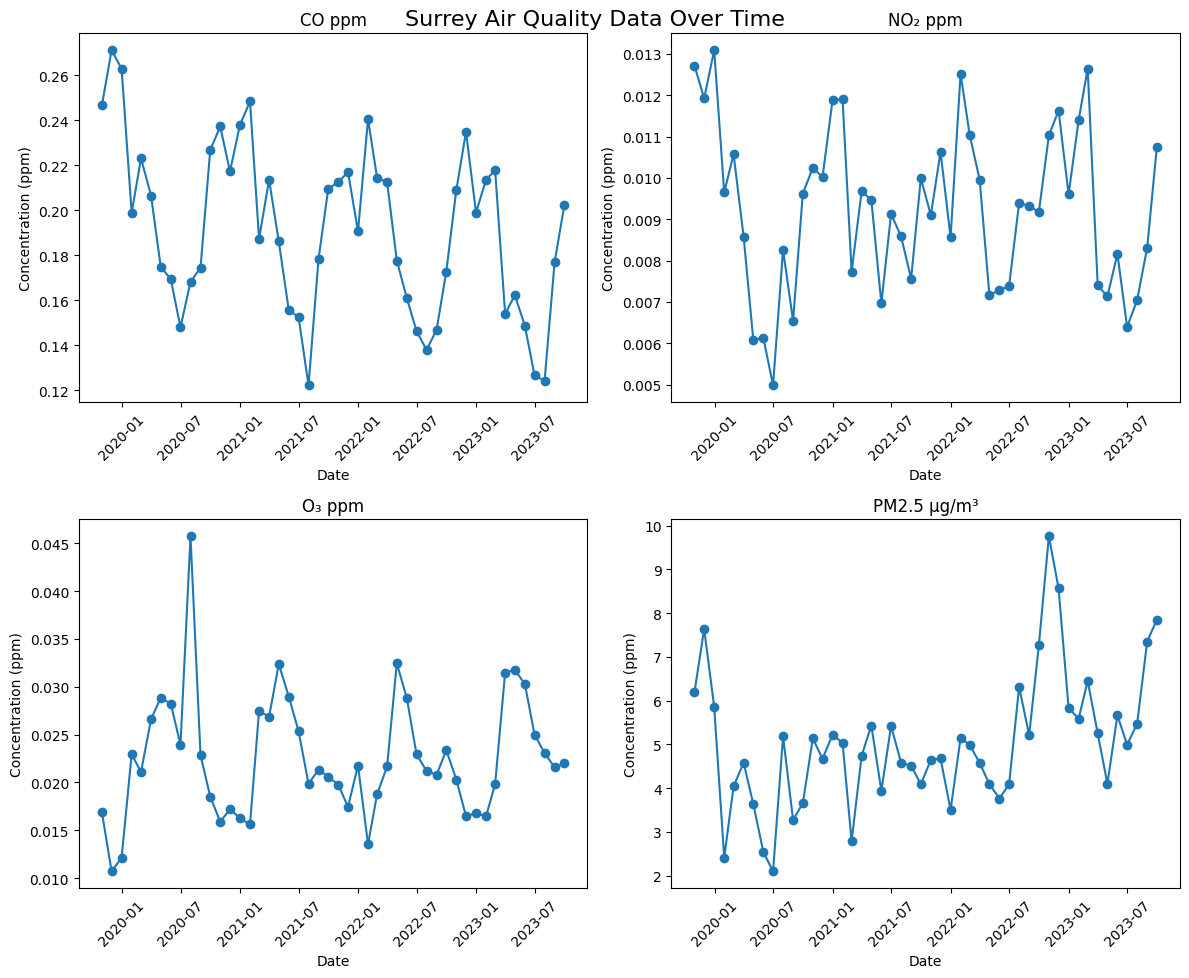

In [ ]:
# Do the same but for months, in the x labels keep the month and year number

# Let's get all the datasets sampled over a month
boston_df_monthly = boston_df.resample('M', on='date').mean()
annaheim_df_monthly = annaheim_df.resample('M', on='date').mean()
costa_rica_df_monthly = costa_rica_df.resample('M', on='date').mean()
seattle_df_monthly = seattle_df.resample('M', on='date').mean()
reseda_df_monthly = reseda_df.resample('M', on='date').mean()
surrey_df_monthly = surrey_df.resample('M', on='date').mean()


costa_rica_df_daily.info()
costa_rica_df.info()

plt.figure(figsize=(12, 8))

#Add a title for all the plots
plt.suptitle('Costa Rica Air Quality Data Over Time', fontsize=16)


plt.plot(costa_rica_df_monthly.index, costa_rica_df_monthly['PM2.5 µg/m³'], marker='o')
plt.title('PM2.5 µg/m³')
plt.xlabel('Date')
plt.ylabel('Concentration (ppm)')

plt.show()


plt.figure(figsize=(12, 24))

#Add a title for all the plots
plt.suptitle('Boston Air Quality Data Over Time', fontsize=16)

# Plot each column
for i, column in enumerate(columns, 1):
    plt.subplot(5, 2, i)
    plt.plot(boston_df_monthly.index, boston_df_monthly[column], marker='o')
    plt.title(column)
    plt.xlabel('Date')
    plt.ylabel('Concentration (ppm)')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#Do the same but for the rest of the cities

#Let's plot all the columns in the annaheim grouped but in different plots

plt.figure(figsize=(12, 24))

#Add a title for all the plots
plt.suptitle('Annaheim Air Quality Data Over Time', fontsize=16)

# Plot each column
for i, column in enumerate(columns, 1):
    plt.subplot(5, 2, i)
    plt.plot(annaheim_df_monthly.index, annaheim_df_monthly[column], marker='o')
    plt.title(column)
    plt.xlabel('Date')
    plt.ylabel('Concentration (ppm)')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#Let's plot all the columns in the annaheim grouped but in different plots

plt.figure(figsize=(12, 24))

#Add a title for all the plots
plt.suptitle('Seattle Air Quality Data Over Time', fontsize=16)

# Plot each column
for i, column in enumerate(columns, 1):
    plt.subplot(5, 2, i)
    plt.plot(seattle_df_monthly.index, seattle_df_monthly[column], marker='o')
    plt.title(column)
    plt.xlabel('Date')
    plt.ylabel('Concentration (ppm)')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Let's plot all the columns in the reseda_df grouped but in different plots

plt.figure(figsize=(12, 24))

# Add a title for all the plots
plt.suptitle('Reseda Air Quality Data Over Time', fontsize=16)

# Plot each column
for i, column in enumerate(columns, 1):
    plt.subplot(5, 2, i)
    plt.plot(seattle_df_monthly.index, seattle_df_monthly[column], marker='o')
    plt.title(column)
    plt.xlabel('Date')
    plt.ylabel('Concentration (ppm)')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Let's plot all the columns in the surrey_df grouped but in different plots

plt.figure(figsize=(12, 24))

# Add a title for all the plots
plt.suptitle('Surrey Air Quality Data Over Time', fontsize=16)

# Plot each column
for i, column in enumerate(columns, 1):
    plt.subplot(5, 2, i)
    plt.plot(seattle_df_monthly.index, seattle_df_monthly[column], marker='o')
    plt.title(column)
    plt.xlabel('Date')
    plt.ylabel('Concentration (ppm)')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


This looks way better, this is the about the glanurality we would like to see. There's a few thing we can notice:

* For most of the dataframes, there's a cyclic tendency with a period of a year, which is expected because of the changes in climate usually happens around the same time periods.

Let's try now to identify what's the general trend for the data by calculating a linear trend line.

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1417 entries, 2019-10-28 00:00:00+00:00 to 2023-09-13 00:00:00+00:00
Freq: D
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PM2.5 µg/m³  1190 non-null   float64
dtypes: float64(1)
memory usage: 22.1 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24868 entries, 0 to 24867
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   date         24868 non-null  datetime64[ns, UTC]
 1   PM2.5 µg/m³  24868 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(1)
memory usage: 388.7 KB


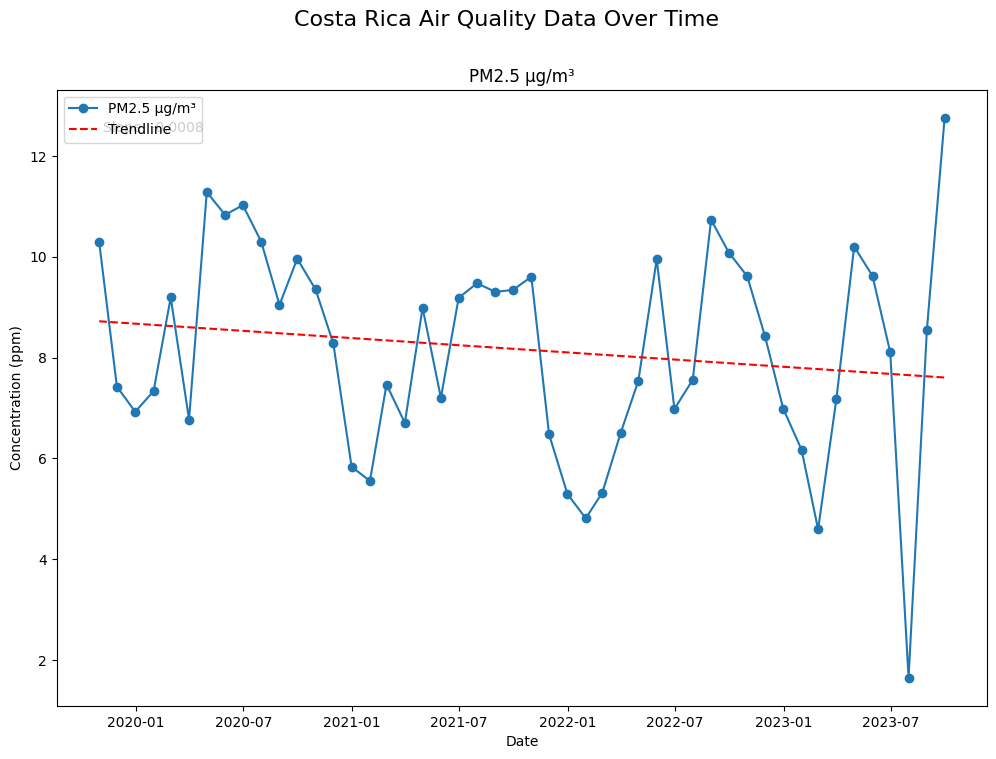

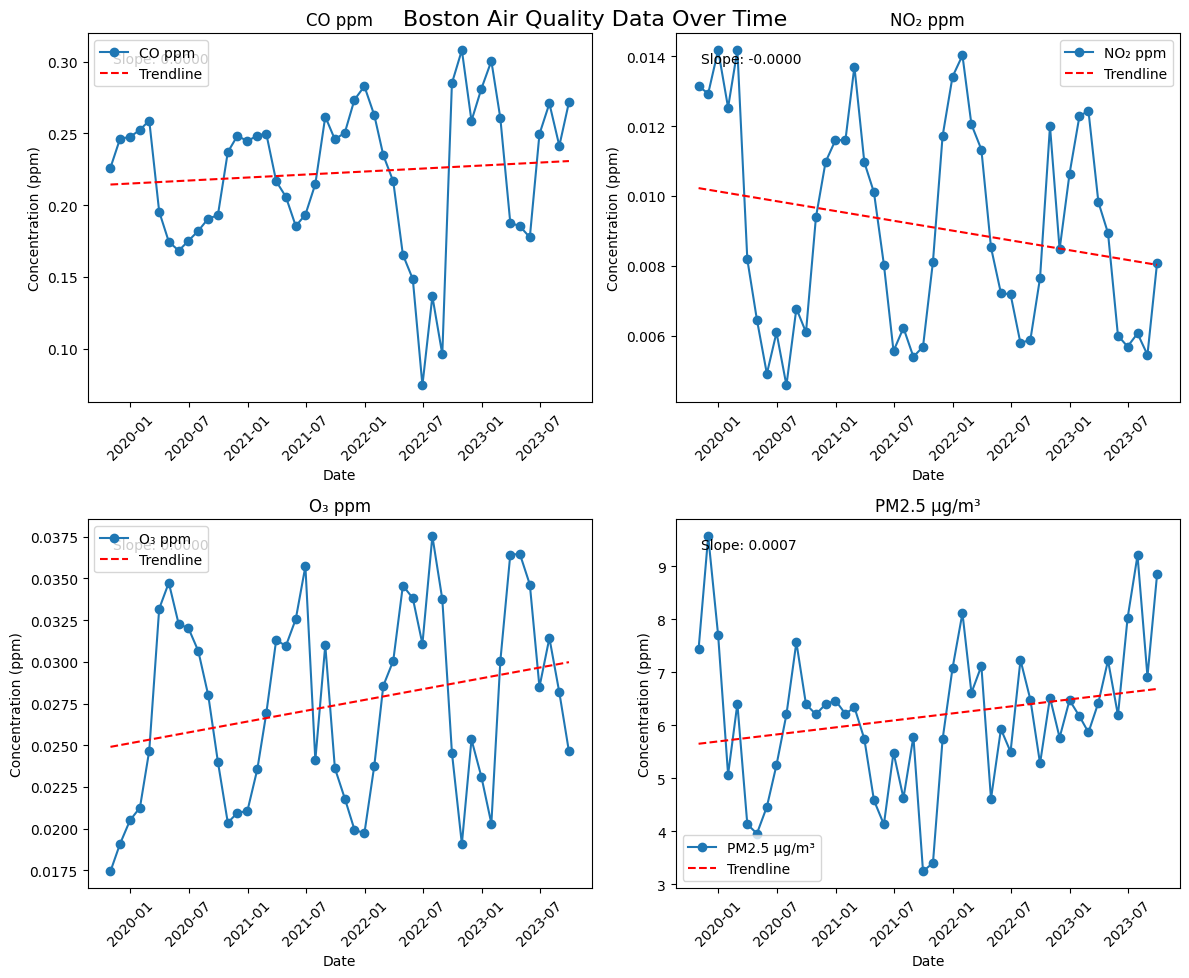

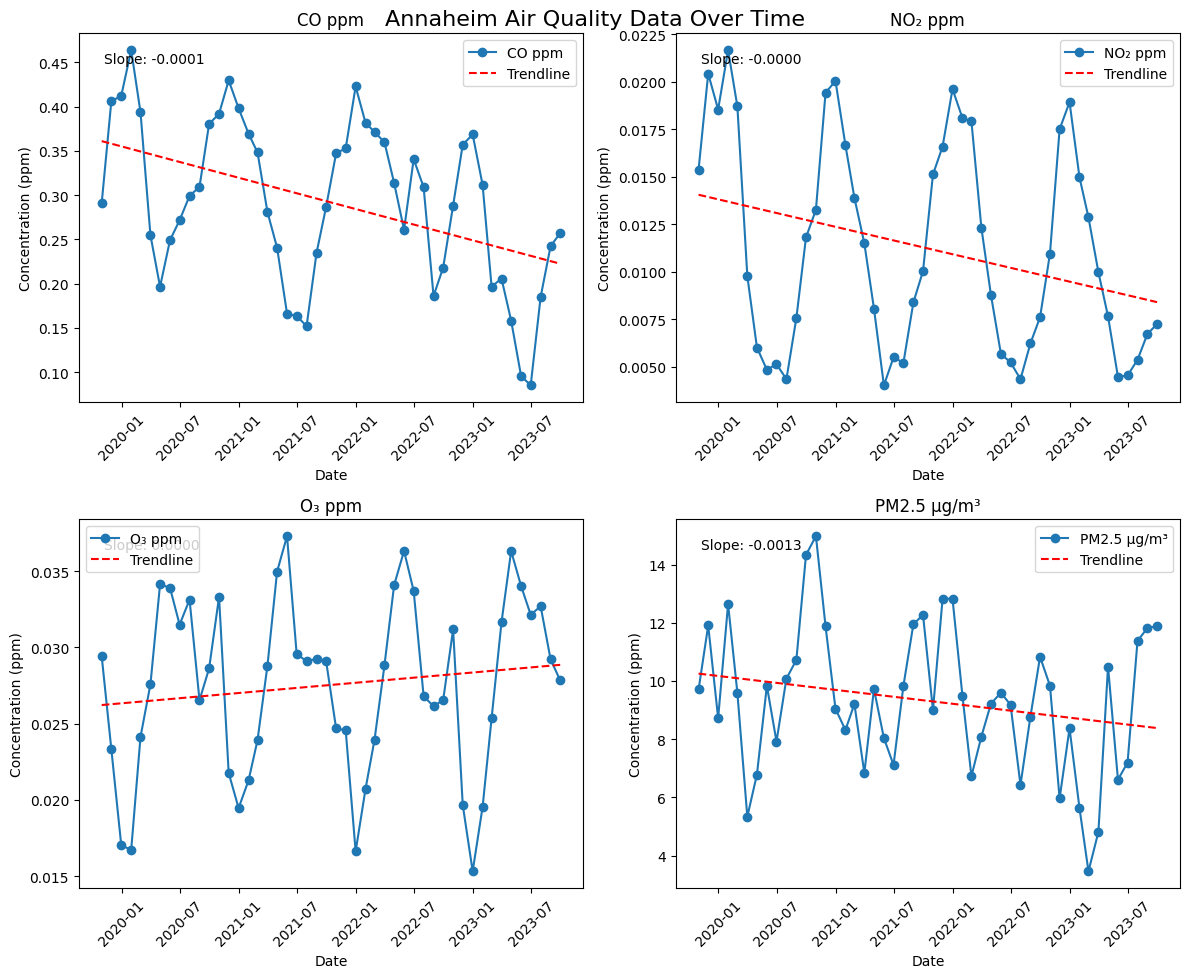

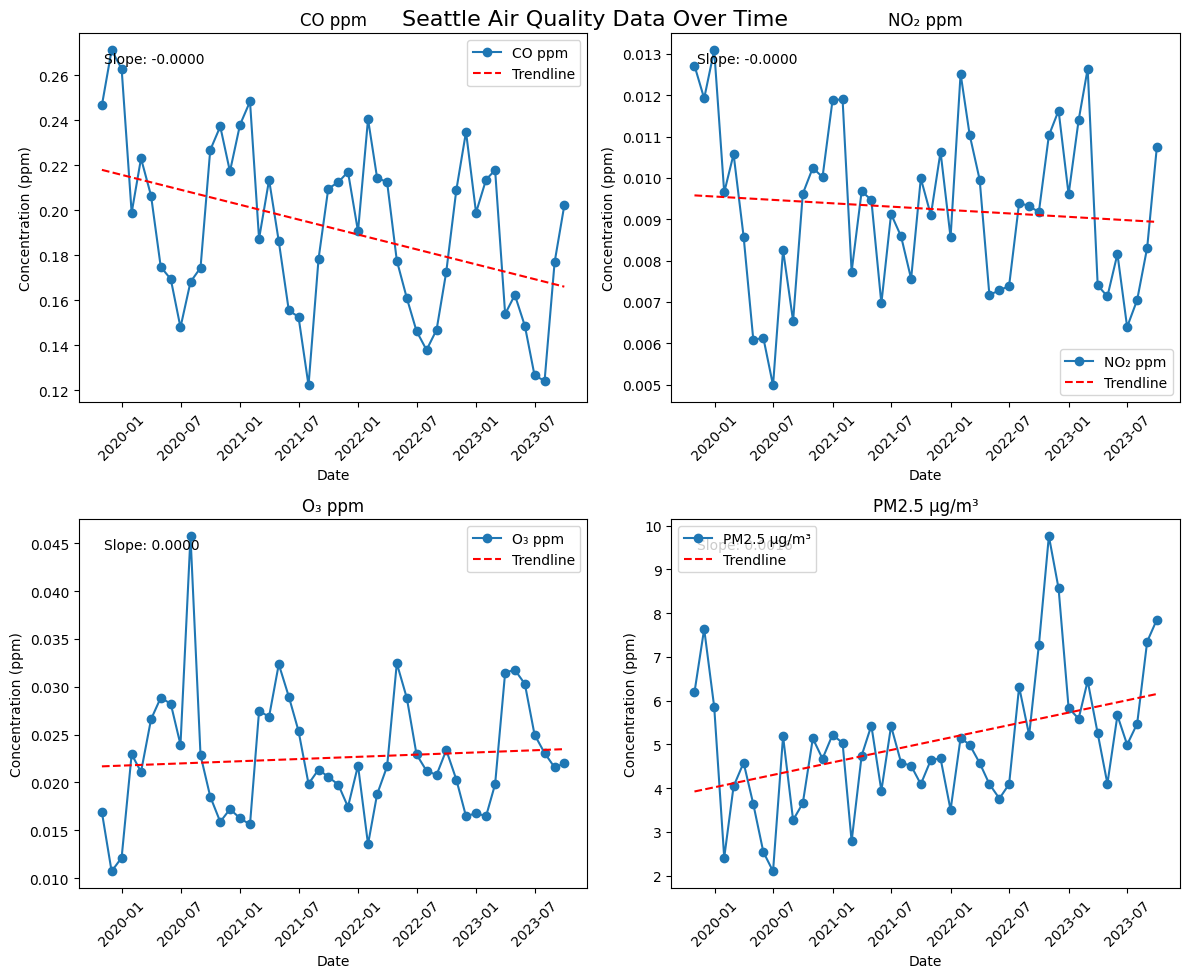

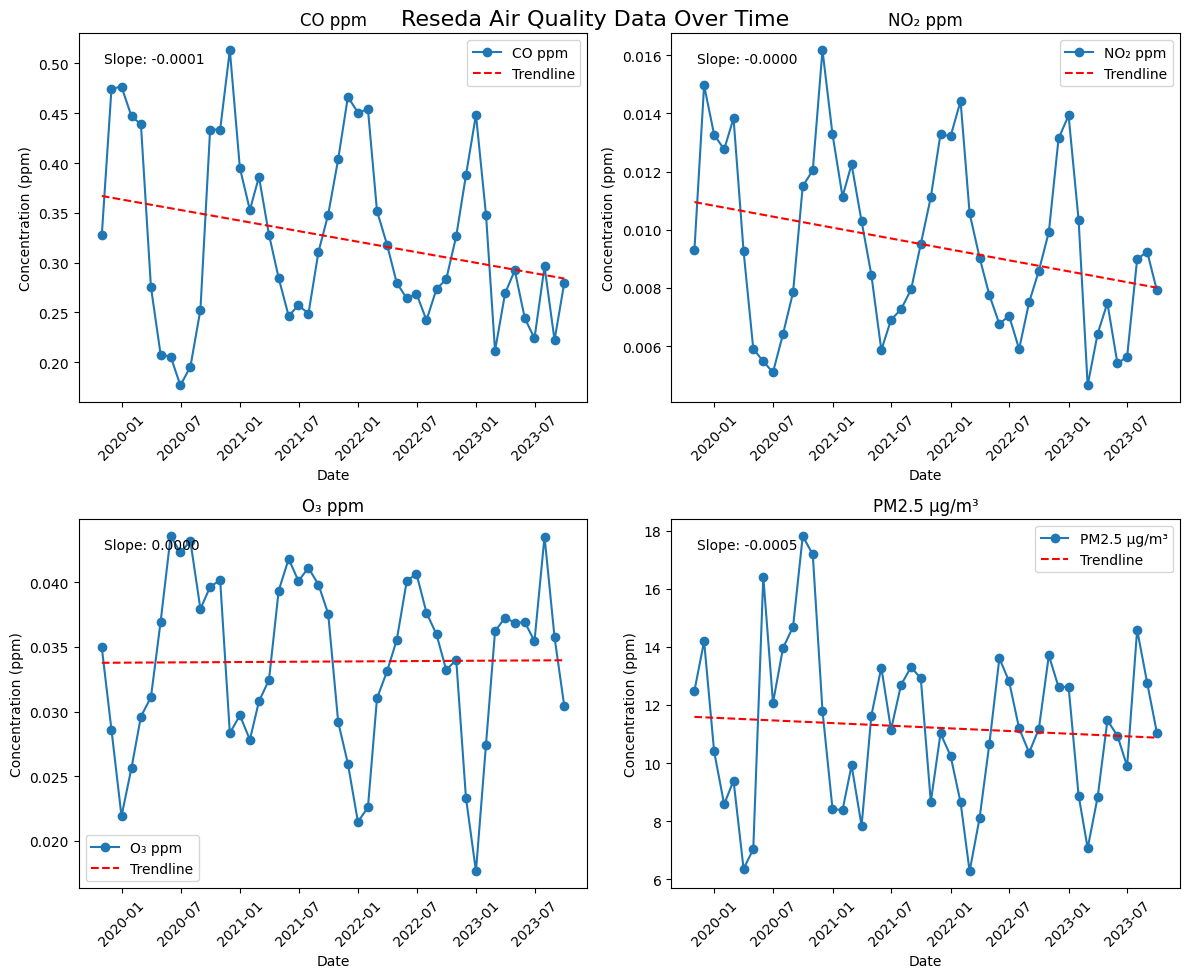

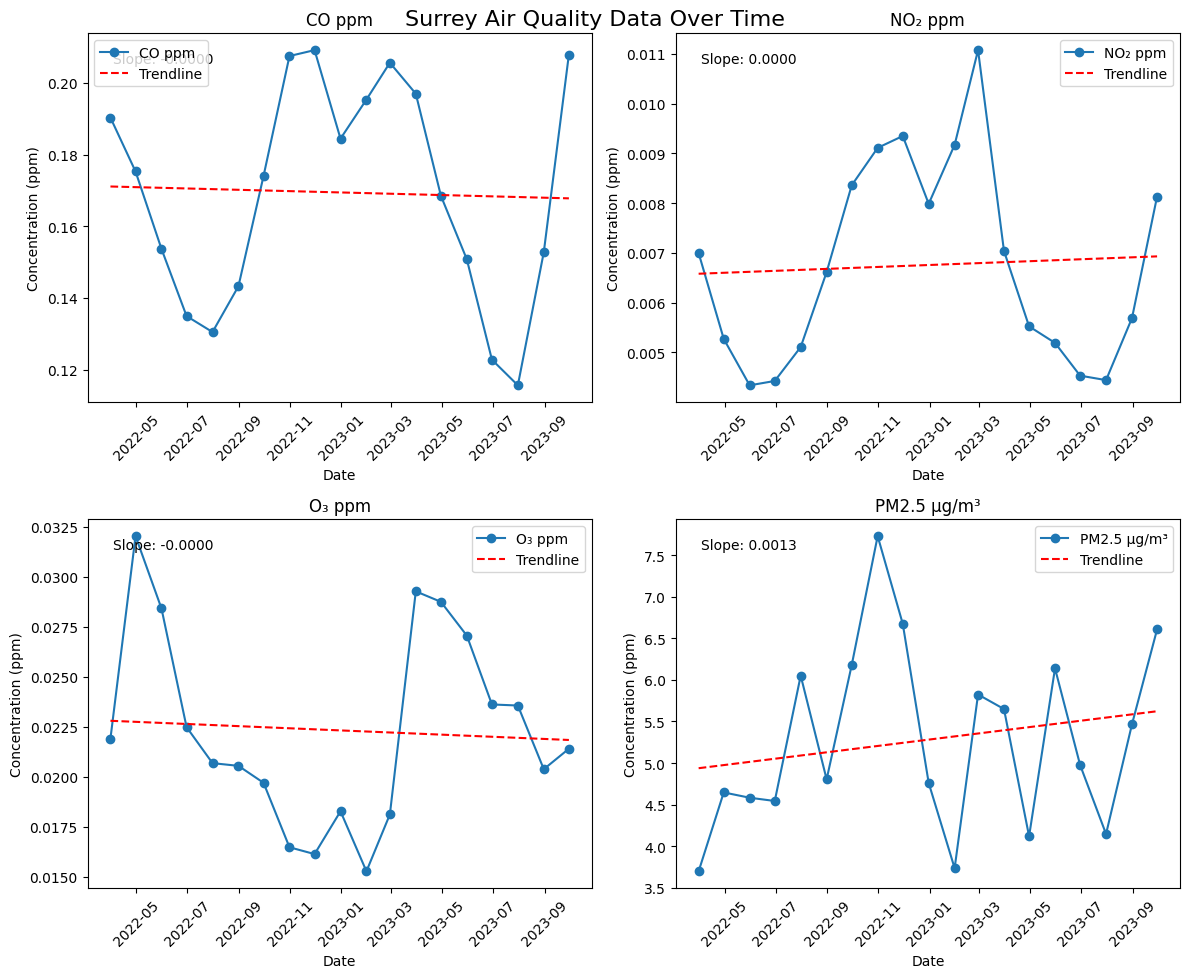

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Do the same but for months, in the x labels keep the month and year number

# Let's get all the datasets sampled over a month
boston_df_monthly = boston_df.resample('M', on='date').mean()
annaheim_df_monthly = annaheim_df.resample('M', on='date').mean()
costa_rica_df_monthly = costa_rica_df.resample('M', on='date').mean()
seattle_df_monthly = seattle_df.resample('M', on='date').mean()
reseda_df_monthly = reseda_df.resample('M', on='date').mean()
surrey_df_monthly = surrey_df.resample('M', on='date').mean()

costa_rica_df_daily.info()
costa_rica_df.info()

plt.figure(figsize=(12, 8))

# Add a title for all the plots
plt.suptitle('Costa Rica Air Quality Data Over Time', fontsize=16)

# Plot Costa Rica data with trendline
plt.plot(costa_rica_df_monthly.index, costa_rica_df_monthly['PM2.5 µg/m³'], marker='o', label='PM2.5 µg/m³')
z = np.polyfit(mpl.dates.date2num(costa_rica_df_monthly.index), costa_rica_df_monthly['PM2.5 µg/m³'], 1)
p = np.poly1d(z)
plt.plot(costa_rica_df_monthly.index, p(mpl.dates.date2num(costa_rica_df_monthly.index)), "r--", label='Trendline')
plt.title('PM2.5 µg/m³')
plt.xlabel('Date')
plt.ylabel('Concentration (ppm)')
plt.legend()
plt.text(0.05, 0.95, f'Slope: {z[0]:.4f}', transform=plt.gca().transAxes, verticalalignment='top')

plt.show()

plt.figure(figsize=(12, 24))

# Add a title for all the plots
plt.suptitle('Boston Air Quality Data Over Time', fontsize=16)

# Plot each column with trendline
for i, column in enumerate(columns, 1):
    plt.subplot(5, 2, i)
    plt.plot(boston_df_monthly.index, boston_df_monthly[column], marker='o', label=column)
    z = np.polyfit(mpl.dates.date2num(boston_df_monthly.index), boston_df_monthly[column], 1)
    p = np.poly1d(z)
    plt.plot(boston_df_monthly.index, p(mpl.dates.date2num(boston_df_monthly.index)), "r--", label='Trendline')
    plt.title(column)
    plt.xlabel('Date')
    plt.ylabel('Concentration (ppm)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.text(0.05, 0.95, f'Slope: {z[0]:.4f}', transform=plt.gca().transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()

# Do the same but for the rest of the cities

# Let's plot all the columns in the annaheim grouped but in different plots

plt.figure(figsize=(12, 24))

# Add a title for all the plots
plt.suptitle('Annaheim Air Quality Data Over Time', fontsize=16)

# Plot each column with trendline
for i, column in enumerate(columns, 1):
    plt.subplot(5, 2, i)
    plt.plot(annaheim_df_monthly.index, annaheim_df_monthly[column], marker='o', label=column)
    z = np.polyfit(mpl.dates.date2num(annaheim_df_monthly.index), annaheim_df_monthly[column], 1)
    p = np.poly1d(z)
    plt.plot(annaheim_df_monthly.index, p(mpl.dates.date2num(annaheim_df_monthly.index)), "r--", label='Trendline')
    plt.title(column)
    plt.xlabel('Date')
    plt.ylabel('Concentration (ppm)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.text(0.05, 0.95, f'Slope: {z[0]:.4f}', transform=plt.gca().transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()

# Let's plot all the columns in the seattle grouped but in different plots

plt.figure(figsize=(12, 24))

# Add a title for all the plots
plt.suptitle('Seattle Air Quality Data Over Time', fontsize=16)

# Plot each column with trendline
for i, column in enumerate(columns, 1):
    plt.subplot(5, 2, i)
    plt.plot(seattle_df_monthly.index, seattle_df_monthly[column], marker='o', label=column)
    z = np.polyfit(mpl.dates.date2num(seattle_df_monthly.index), seattle_df_monthly[column], 1)
    p = np.poly1d(z)
    plt.plot(seattle_df_monthly.index, p(mpl.dates.date2num(seattle_df_monthly.index)), "r--", label='Trendline')
    plt.title(column)
    plt.xlabel('Date')
    plt.ylabel('Concentration (ppm)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.text(0.05, 0.95, f'Slope: {z[0]:.4f}', transform=plt.gca().transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()

# Let's plot all the columns in the reseda_df grouped but in different plots

plt.figure(figsize=(12, 24))

# Add a title for all the plots
plt.suptitle('Reseda Air Quality Data Over Time', fontsize=16)

# Plot each column with trendline
for i, column in enumerate(columns, 1):
    plt.subplot(5, 2, i)
    plt.plot(reseda_df_monthly.index, reseda_df_monthly[column], marker='o', label=column)
    z = np.polyfit(mpl.dates.date2num(reseda_df_monthly.index), reseda_df_monthly[column], 1)
    p = np.poly1d(z)
    plt.plot(reseda_df_monthly.index, p(mpl.dates.date2num(reseda_df_monthly.index)), "r--", label='Trendline')
    plt.title(column)
    plt.xlabel('Date')
    plt.ylabel('Concentration (ppm)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.text(0.05, 0.95, f'Slope: {z[0]:.4f}', transform=plt.gca().transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()

# Let's plot all the columns in the surrey_df grouped but in different plots

plt.figure(figsize=(12, 24))

# Add a title for all the plots
plt.suptitle('Surrey Air Quality Data Over Time', fontsize=16)

# Plot each column with trendline
for i, column in enumerate(columns, 1):
    plt.subplot(5, 2, i)
    plt.plot(surrey_df_monthly.index, surrey_df_monthly[column], marker='o', label=column)
    z = np.polyfit(mpl.dates.date2num(surrey_df_monthly.index), surrey_df_monthly[column], 1)
    p = np.poly1d(z)
    plt.plot(surrey_df_monthly.index, p(mpl.dates.date2num(surrey_df_monthly.index)), "r--", label='Trendline')
    plt.title(column)
    plt.xlabel('Date')
    plt.ylabel('Concentration (ppm)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.text(0.05, 0.95, f'Slope: {z[0]:.4f}', transform=plt.gca().transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()

## Conclusions

 * The data extracted from offers plenty of data points to properly assess air quality. However, it requries extensive cleaning to avoid pitfalls like negative values and missing dates, which requires data intuition and a preliminary EDA before the substancial EDA to have proper, useful data,

 * The univariate analysis of the different sensors present in the chosen cities shows that the city of Surrey is the one with the lowest levels of air pollution.

 * Taking as a reference the complete data set for Costa Rica specifically over the years, it shows a downward trend for PM2.5, where the same is true for Reseda, for the other cities, the trend is upward.

 * Most air quality metrics follow a cyclic pattern with a period of one year.

## Recommendations

* After performing the cleaning and EDA we recommend to continue the dataset analysis using more advanced techniques.

* Taking Costa Rica as a reference, it is of utmost importance to give maintenance to the air quality sensors and at the same time in our country to give greater importance to the collection of this type of data that for future analysis are of great relevance.

* The availilty of aditioanl sensors in Costa Rica should be of special interest as, along data from other countries, it can provide insights on how air quality should be handled. Right now it is limited at a single variable which difficults any kind of deeper analysis.  